<a href="https://colab.research.google.com/github/YoMekki/CO2Forecasting/blob/main/ARIMA_CO2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/owid-co2-data.csv')

In [ ]:
df.head()

,country,year,iso_code,population,gdp,cement_co2,cement_co2_per_capita,co2,co2_growth_abs,co2_growth_prct,...,share_global_cumulative_other_co2,share_global_flaring_co2,share_global_gas_co2,share_global_luc_co2,share_global_oil_co2,share_global_other_co2,total_ghg,total_ghg_excluding_lucf,trade_co2,trade_co2_share
0,Afghanistan,1850,AFG,3752993.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.121,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1851,AFG,3769828.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.118,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,1852,AFG,3787706.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.116,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,1853,AFG,3806634.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.115,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,1854,AFG,3825655.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.114,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Filter for relevant columns (Year and CO2 emissions)
df_subset = df[['year', 'co2']]

# Drop rows with missing CO2 values
df_subset = df_subset.dropna()

# Ensure year is numeric for time series analysis
df_subset['year'] = pd.to_numeric(df_subset['year'])

# Set the year column as the index
df_subset.set_index('year', inplace=True)

# Sort the data by year for consistency
df_subset = df_subset.sort_index()

# Display basic stats to verify cleaning
print("Cleaned Data Summary:")
print(df_subset.describe())
print("\nFirst few rows of the cleaned dataset:")
print(df_subset.head())


Cleaned Data Summary:
                co2
count  31349.000000
mean     379.988086
std     1799.875801
min        0.000000
25%        0.125000
50%        3.109000
75%       43.660000
max    37123.852000

First few rows of the cleaned dataset:
      co2
year     
1750  0.0
1750  0.0
1750  0.0
1750  0.0
1750  0.0


In [ ]:
# Aggregate by year, calculating the mean CO2 emissions for each year
df_aggregated = df_subset.groupby('year').mean()

# Display summary after aggregation
print("Aggregated Data Summary:")
print(df_aggregated.describe())
print("\nFirst few rows of the aggregated dataset:")
print(df_aggregated.head())


Aggregated Data Summary:
              co2
count  272.000000
mean   210.099359
std    268.108212
min      1.650176
25%      7.352036
50%     90.005548
75%    259.718880
max    970.200181

First few rows of the aggregated dataset:
           co2
year          
1750  1.650176
1751  1.650176
1752  1.650706
1753  1.650706
1754  1.651412


In [ ]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
adf_result = adfuller(df_aggregated['co2'])
print("ADF Test Results:")
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print("Critical Values:", adf_result[4])


ADF Test Results:
ADF Statistic: 2.528941287423769
p-value: 0.9990585926358786
Critical Values: {'1%': -3.4557539868570775, '5%': -2.8727214497041422, '10%': -2.572728476331361}


ADF Test Results After Differencing:
ADF Statistic: -1.9873082009667067
p-value: 0.2921655872555107
Critical Values: {'1%': -3.456360306409983, '5%': -2.8729872043802356, '10%': -2.572870232500465}


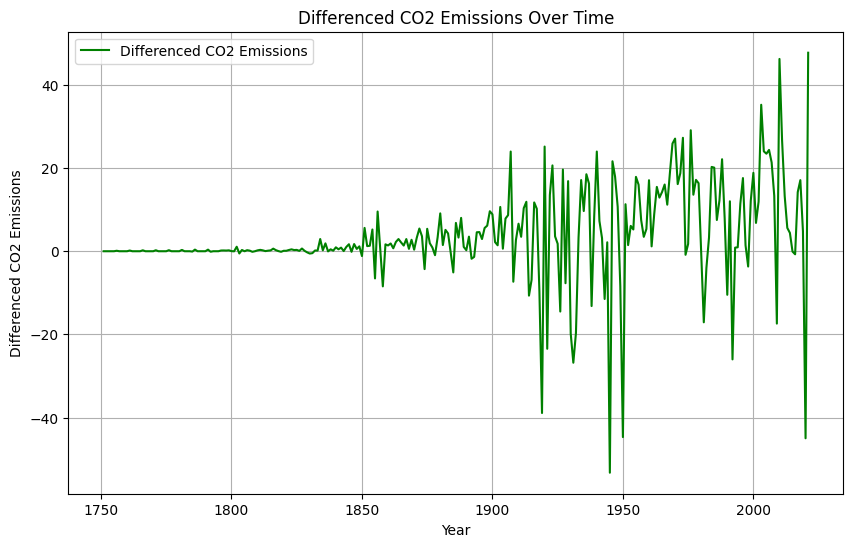

In [ ]:
# Apply first-order differencing
df_aggregated['co2_diff'] = df_aggregated['co2'].diff()

# Drop NaN values caused by differencing
df_diff = df_aggregated.dropna()

# Perform ADF test again
adf_result_diff = adfuller(df_diff['co2_diff'])
print("ADF Test Results After Differencing:")
print(f"ADF Statistic: {adf_result_diff[0]}")
print(f"p-value: {adf_result_diff[1]}")
print("Critical Values:", adf_result_diff[4])

# Plot the differenced data
plt.figure(figsize=(10, 6))
plt.plot(df_diff.index, df_diff['co2_diff'], label='Differenced CO2 Emissions', color='green')
plt.title("Differenced CO2 Emissions Over Time")
plt.xlabel("Year")
plt.ylabel("Differenced CO2 Emissions")
plt.legend()
plt.grid()
plt.show()


ADF Test Results After Second-Order Differencing:
ADF Statistic: -5.635533808274121
p-value: 1.065237106594285e-06
Critical Values: {'1%': -3.4564641849494113, '5%': -2.873032730098417, '10%': -2.572894516864816}


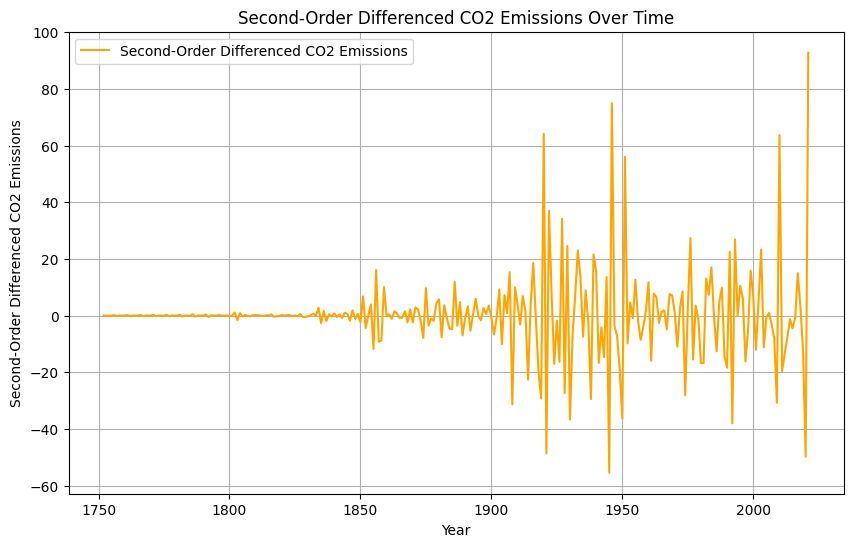

In [ ]:
# Apply second-order differencing
df_aggregated['co2_diff2'] = df_aggregated['co2'].diff().diff()

# Drop NaN values caused by differencing
df_diff2 = df_aggregated.dropna()

# Perform ADF test again
adf_result_diff2 = adfuller(df_diff2['co2_diff2'])
print("ADF Test Results After Second-Order Differencing:")
print(f"ADF Statistic: {adf_result_diff2[0]}")
print(f"p-value: {adf_result_diff2[1]}")
print("Critical Values:", adf_result_diff2[4])

# Plot the second-order differenced data
plt.figure(figsize=(10, 6))
plt.plot(df_diff2.index, df_diff2['co2_diff2'], label='Second-Order Differenced CO2 Emissions', color='orange')
plt.title("Second-Order Differenced CO2 Emissions Over Time")
plt.xlabel("Year")
plt.ylabel("Second-Order Differenced CO2 Emissions")
plt.legend()
plt.grid()
plt.savefig("ADF Test Results.tiff", format='tiff')
plt.show()


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46523 entries, 0 to 46522
Data columns (total 74 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   country                                    46523 non-null  object 
 1   year                                       46523 non-null  int64  
 2   iso_code                                   39862 non-null  object 
 3   population                                 38574 non-null  float64
 4   gdp                                        14551 non-null  float64
 5   cement_co2                                 24974 non-null  float64
 6   cement_co2_per_capita                      22714 non-null  float64
 7   co2                                        31349 non-null  float64
 8   co2_growth_abs                             28944 non-null  float64
 9   co2_growth_prct                            25032 non-null  float64
 10  co2_including_luc     

In [ ]:
df['gdp'] = df['gdp'].fillna(df['gdp'].median())
df['cement_co2'] = df['cement_co2'].fillna(df['cement_co2'].median())


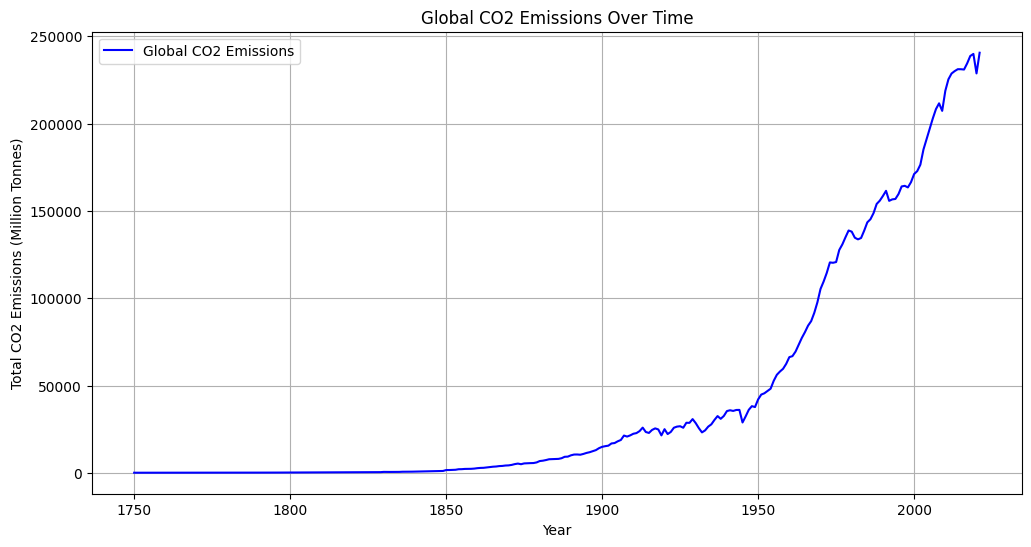

In [ ]:
import matplotlib.pyplot as plt

# Filter for relevant columns (Year and CO2 emissions)
df_global_co2 = df[['year', 'co2']]

# Group by year to get the total global CO2 emissions per year
df_global_co2 = df_global_co2.groupby('year')['co2'].sum()

# Plot the global CO2 emissions over time
plt.figure(figsize=(12, 6))
plt.plot(df_global_co2.index, df_global_co2.values, label='Global CO2 Emissions', color='blue')
plt.title("Global CO2 Emissions Over Time")
plt.xlabel("Year")
plt.ylabel("Total CO2 Emissions (Million Tonnes)")
plt.grid(True)
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Usin

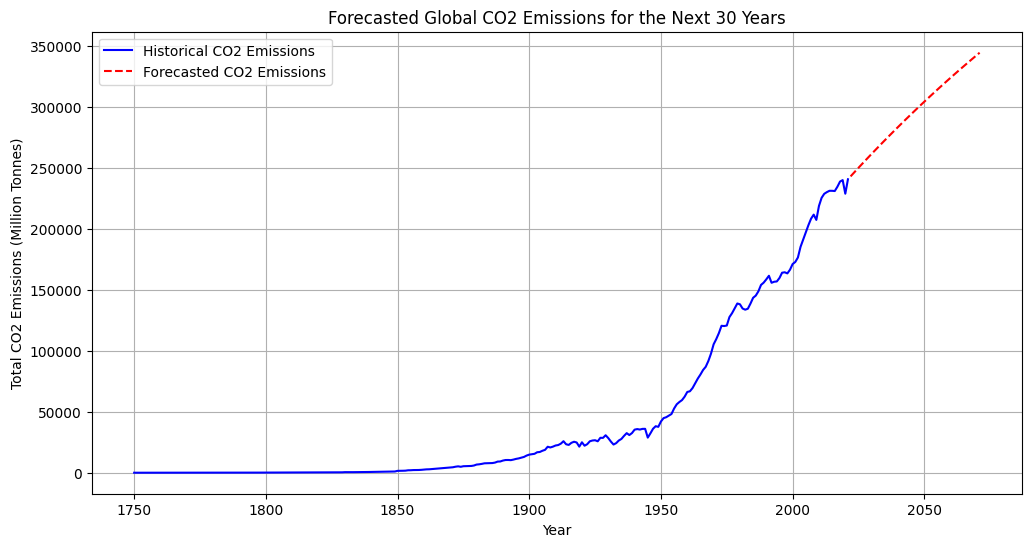

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Fit ARIMA model (adjust p, d, q as needed)
model = ARIMA(df_global_co2, order=(1,1,1))  # ARIMA(p, d, q)
model_fit = model.fit()

# Forecast the next 50 years
forecast_years = 50
forecast = model_fit.forecast(steps=forecast_years)

# Generate the future years
future_years = np.arange(df_global_co2.index[-1] + 1, df_global_co2.index[-1] + 1 + forecast_years)

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(df_global_co2.index, df_global_co2.values, label='Historical CO2 Emissions', color='blue')
plt.plot(future_years, forecast, label='Forecasted CO2 Emissions', color='red', linestyle='--')
plt.title(f"Forecasted Global CO2 Emissions for the Next 30 Years")
plt.xlabel("Year")
plt.ylabel("Total CO2 Emissions (Million Tonnes)")
plt.legend()
plt.grid(True)
plt.savefig("Forecasted Global CO2 Emissions for the Next 30 Years.tiff", format='tiff')
plt.show()


In [ ]:
# Remove any row where the index is 'year'
df_global_co2 = df_global_co2[df_global_co2.index != 'year']

# Ensure the index is numeric
df_global_co2.index = pd.to_numeric(df_global_co2.index)

# Confirm the structure of the data
print(df_global_co2.head())
print(df_global_co2.index)


year
1750    56.106
1751    56.106
1752    56.124
1753    56.124
1754    56.148
Name: co2, dtype: float64
Index([1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759,
       ...
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021],
      dtype='int64', name='year', length=272)


In [ ]:
pip install pmdarima


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=4885.996, Time=1.24 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=5037.561, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=4981.750, Time=0.07 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=4889.019, Time=2.33 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=5035.639, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=5.16 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=4891.958, Time=2.47 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=4888.514, Time=3.26 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=4884.201, Time=6.16 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=6.60 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,2,3)(0,0,0)[0] intercept   : AIC=4883.483, Time=5.86 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,2,3)(0,0,0)[0] intercept   : AIC=4885.715, Time=11.71 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,2,4)(0,0,0)[0] intercept   : AIC=4877.890, Time=6.75 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,2,4)(0,0,0)[0] intercept   : AIC=4883.916, Time=9.43 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,2,4)(0,0,0)[0] intercept   : AIC=4879.100, Time=6.12 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,2,5)(0,0,0)[0] intercept   : AIC=inf, Time=5.92 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,2,5)(0,0,0)[0] intercept   : AIC=4888.886, Time=4.42 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,2,5)(0,0,0)[0] intercept   : AIC=4881.414, Time=3.61 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,2,4)(0,0,0)[0]             : AIC=4882.225, Time=6.09 sec

Best model:  ARIMA(3,2,4)(0,0,0)[0] intercept
Total fit time: 87.443 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


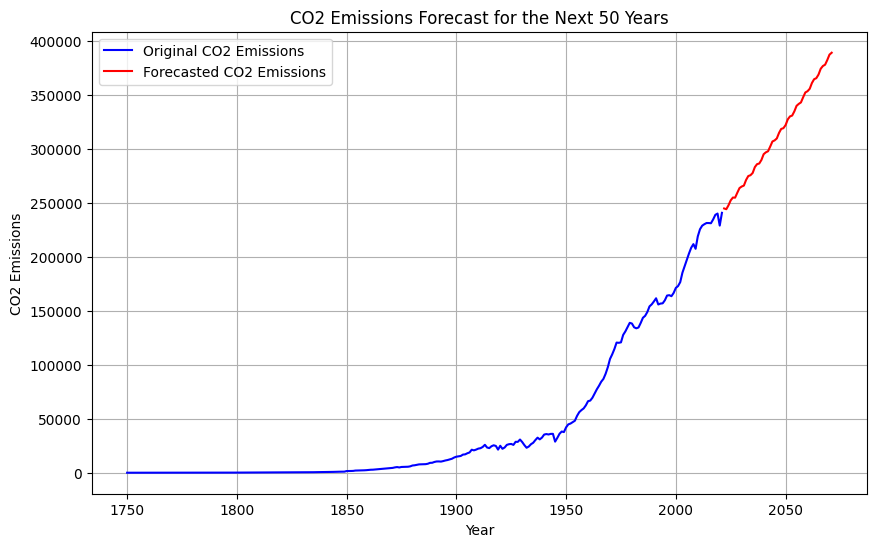

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  272
Model:               SARIMAX(3, 2, 4)   Log Likelihood               -2429.945
Date:                Thu, 09 Jan 2025   AIC                           4877.890
Time:                        11:54:19   BIC                           4910.276
Sample:                             0   HQIC                          4890.895
                                - 272                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     48.0725     50.632      0.949      0.342     -51.165     147.310
ar.L1         -1.1172      0.053    -21.036      0.000      -1.221      -1.013
ar.L2         -1.1961      0.036    -33.357      0.0

In [ ]:
import pandas as pd
import pmdarima as pm
import matplotlib.pyplot as plt

# Example data (replace this with your actual data)
# Make sure the 'year' column is numeric and the 'co2' column is clean

# Fit the auto ARIMA model
model = pm.auto_arima(df_global_co2, seasonal=False, stepwise=True, trace=True)

# Forecast the next 50 years
forecast = model.predict(n_periods=50)

# Plot the original data and the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df_global_co2.index, df_global_co2.values, label="Original CO2 Emissions", color='blue')
plt.plot(range(df_global_co2.index[-1] + 1, df_global_co2.index[-1] + 51), forecast, label="Forecasted CO2 Emissions", color='red')
plt.xlabel("Year")
plt.ylabel("CO2 Emissions")
plt.title("CO2 Emissions Forecast for the Next 50 Years")
plt.legend()
plt.grid()
plt.show()

# Optionally, print the model summary
print(model.summary())


<ipython-input-17-1fd2e7b94ff1>:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_global_co2 = df_global_co2.fillna(method='ffill')  # You can also use 'bfill' or other methods
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


R-squared (R²): 0.9991798527796887


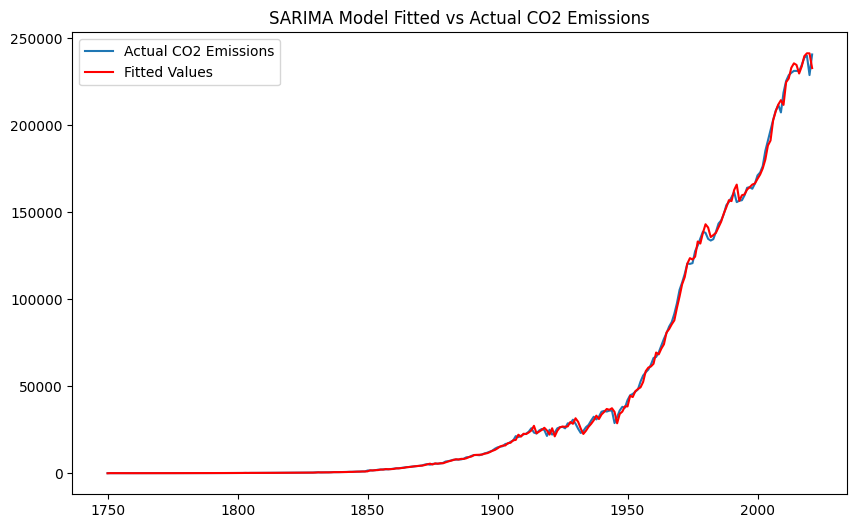

In [ ]:
# Convert 'df_global_co2' to numeric (coerce errors to NaN)
df_global_co2 = pd.to_numeric(df_global_co2, errors='coerce')

# Handle missing values by filling them with the previous value or forward filling
df_global_co2 = df_global_co2.fillna(method='ffill')  # You can also use 'bfill' or other methods

# Now fit the SARIMA model again
sarima_model = SARIMAX(df_global_co2,
                       order=(3, 2, 4),     # ARIMA order (p, d, q)
                       seasonal_order=(1, 1, 1, 12),  # Seasonal components (P, D, Q, s)
                       enforce_stationarity=False,
                       enforce_invertibility=False)

# Fit the model
sarima_result = sarima_model.fit()

# Get the fitted values
fitted_values = sarima_result.fittedvalues

# Calculate R-squared (R²) on the training data
from sklearn.metrics import r2_score
r_squared = r2_score(df_global_co2, fitted_values)
print(f"R-squared (R²): {r_squared}")

# Plot the fitted values vs. actual values
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(df_global_co2, label='Actual CO2 Emissions')
plt.plot(fitted_values, label='Fitted Values', color='red')
plt.legend()
plt.title('SARIMA Model Fitted vs Actual CO2 Emissions')
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
<ipython-input-18-2dffe31a4cdd>:14: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(years=1), periods=forecast_steps, freq='Y')


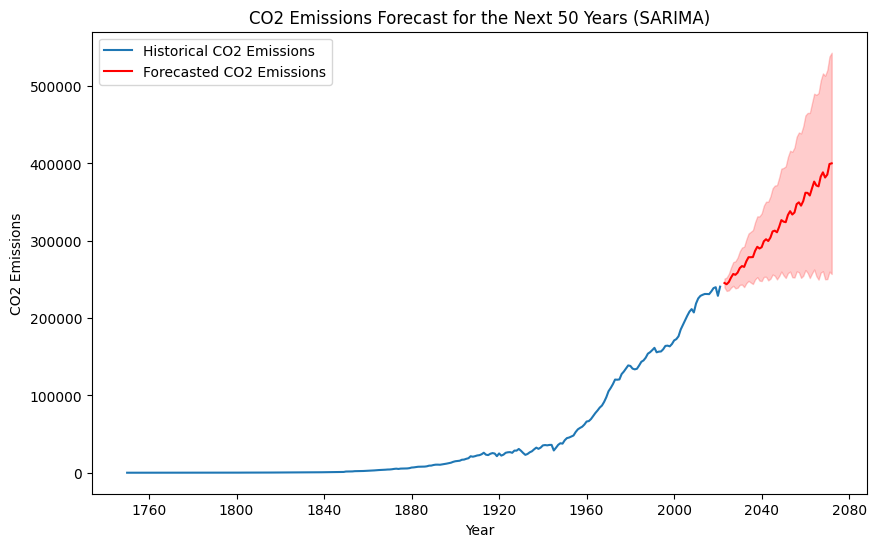

In [ ]:
# Ensure 'year' is part of the index and properly recognized
df_global_co2.index = pd.to_datetime(df_global_co2.index, format='%Y')  # Ensure index is datetime format

# Forecasting the next 50 years
forecast_steps = 50

# Get the last date in the dataset (i.e., the last year)
last_date = df_global_co2.index[-1]

# Forecast using the SARIMA model
forecast = sarima_result.get_forecast(steps=forecast_steps)

# Create a forecast index starting from the last date in the dataset
forecast_index = pd.date_range(start=last_date + pd.DateOffset(years=1), periods=forecast_steps, freq='Y')

# Get the forecasted values
forecast_values = forecast.predicted_mean

# Plotting the forecast
plt.figure(figsize=(10, 6))
plt.plot(df_global_co2.index, df_global_co2, label='Historical CO2 Emissions')
plt.plot(forecast_index, forecast_values, label='Forecasted CO2 Emissions', color='red')
plt.fill_between(forecast_index, forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1], color='red', alpha=0.2)
plt.legend()
plt.title(f"CO2 Emissions Forecast for the Next 50 Years (SARIMA)")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions")
plt.show()


In [ ]:
from sklearn.metrics import r2_score

# Get the fitted values from the SARIMA model
fitted_values = sarima_result.fittedvalues

# We will compare the fitted values with the actual historical data
# R² calculation (only for the historical data)
r_squared = r2_score(df_global_co2, fitted_values)

print(f"R-squared (R²) for the historical data: {r_squared}")


R-squared (R²) for the historical data: 0.9991798527796887


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-20-e3fc96bdac5f>:33: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  forecast_index = pd.date_range(start=start_forecast, periods=forecast_steps, freq='Y')


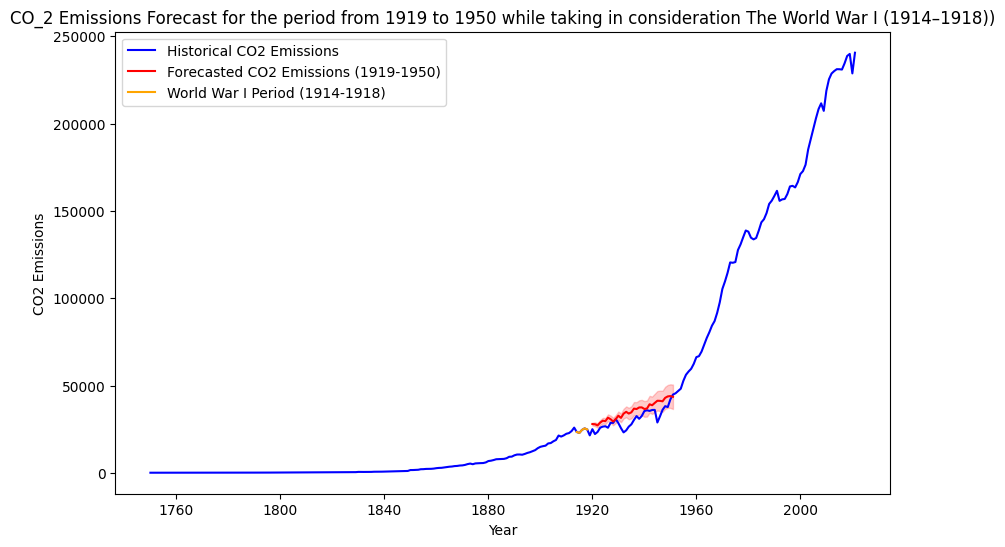

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ensure 'year' is part of the index and properly recognized
df_global_co2.index = pd.to_datetime(df_global_co2.index, format='%Y')  # Ensure index is datetime format

# Define the training period (1751 to 1918)
start_train = '1751'
end_train = '1918'

# Define the forecasting period (1919 to 1950)
start_forecast = '1919'
end_forecast = '1950'

# Train data from 1751 to 1918
train_data = df_global_co2.loc[start_train:end_train]  # Use string for year-based index

# Define SARIMA model (you can adjust p, d, q, P, D, Q, and seasonal_periods if needed)
sarima_model = SARIMAX(train_data,
                      order=(2, 1, 2),  # Non-seasonal ARIMA part (p, d, q)
                      seasonal_order=(1, 1, 1, 12))  # Seasonal components (P, D, Q, s)

# Fit the SARIMA model
sarima_result = sarima_model.fit()

# Forecasting from 1919 to 1950 (for 32 years)
forecast_steps = pd.to_datetime(end_forecast, format='%Y').year - pd.to_datetime(start_forecast, format='%Y').year + 1

forecast = sarima_result.get_forecast(steps=forecast_steps)

# Create a forecast index starting from 1919
forecast_index = pd.date_range(start=start_forecast, periods=forecast_steps, freq='Y')

# Get the forecasted values
forecast_values = forecast.predicted_mean

# Plotting the historical CO2 emissions and forecasted values
plt.figure(figsize=(10, 6))

# Plot the historical data (1751 to 1918) in blue
plt.plot(df_global_co2.index, df_global_co2, label='Historical CO2 Emissions', color='blue')

# Plot the forecasted CO2 emissions (1919 to 1950) in red
plt.plot(forecast_index, forecast_values, label='Forecasted CO2 Emissions (1919-1950)', color='red')
# Define the World War I period (1914-1918)
start_wwi = '1914'
end_wwi = '1918'
# Plot the World War I period data (1914 to 1918) in orange
wwi_data = df_global_co2.loc[start_wwi:end_wwi]
plt.plot(wwi_data.index, wwi_data, color='orange', label='World War I Period (1914-1918)')

# Plot the confidence intervals for the forecasted values
plt.fill_between(forecast_index, forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1], color='red', alpha=0.2)

# Labels and title
plt.legend()
plt.title(f"CO_2 Emissions Forecast for the period from 1919 to 1950 while taking in consideration The World War I (1914–1918))")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions")
plt.savefig("CO_2 Emissions Forecast for the period from 1919 to 1950 while taking in consideration The World War I (1914–1918).tiff", format='tiff')
plt.show()


In [ ]:
from sklearn.metrics import r2_score

# Get the fitted values from the SARIMA model
fitted_values = sarima_result.fittedvalues

# We will compare the fitted values with the actual historical data
# R² calculation (only for the historical data)
r_squared = r2_score(train_data, fitted_values)

print(f"R-squared (R²) for the historical data: {r_squared}")


R-squared (R²) for the historical data: 0.9969020332377454


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
<ipython-input-22-4220ce2ee05b>:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  forecast_index = pd.date_range(start=start_forecast, periods=forecast_steps, freq='Y')


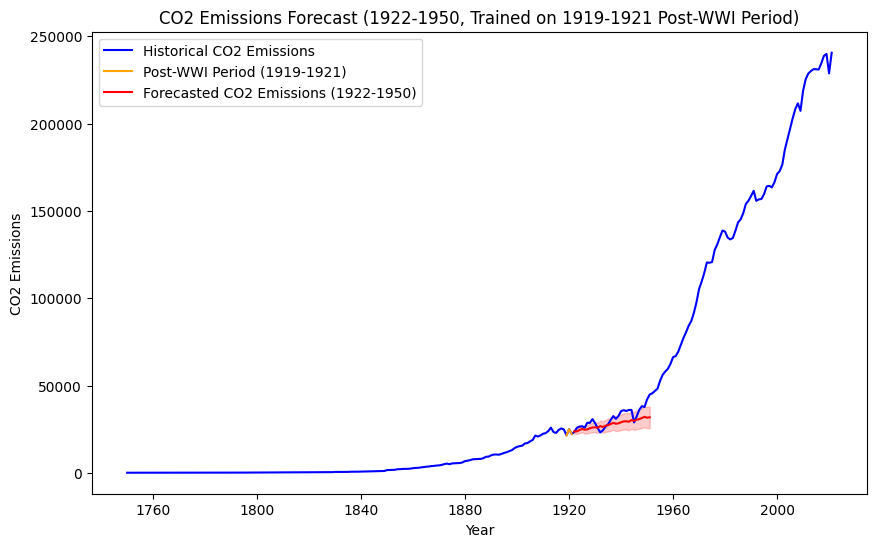

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ensure 'year' is part of the index and properly recognized
df_global_co2.index = pd.to_datetime(df_global_co2.index, format='%Y')  # Ensure index is datetime format

# Define the training period (1751 to 1921)
start_train = '1751'
end_train = '1921'

# Define the post wwI (1919 to 1921)
start_post = '1919'
end_post = '1921'

# Define the forecasting period (1922 to 1950)
start_forecast = '1921'
end_forecast = '1950'

# Train data from 1919 to 1921
train_data = df_global_co2.loc[start_train:end_train]  # Use string for year-based index

# Define SARIMA model (you can adjust p, d, q, P, D, Q, and seasonal_periods if needed)
sarima_model = SARIMAX(train_data,
                      order=(1, 1, 1),  # Non-seasonal ARIMA part (p, d, q)
                      seasonal_order=(0, 1, 1, 12))  # Seasonal components (P, D, Q, s)

# Fit the SARIMA model
sarima_result = sarima_model.fit()

# Forecasting from 1922 to 1950 (29 years)
forecast_steps = pd.to_datetime(end_forecast, format='%Y').year - pd.to_datetime(start_forecast, format='%Y').year + 1

forecast = sarima_result.get_forecast(steps=forecast_steps)

# Create a forecast index starting from 1922
forecast_index = pd.date_range(start=start_forecast, periods=forecast_steps, freq='Y')

# Get the forecasted values
forecast_values = forecast.predicted_mean

# Plotting the historical CO2 emissions and forecasted values
plt.figure(figsize=(10, 6))

# Plot the historical data in blue
plt.plot(df_global_co2.index, df_global_co2, label='Historical CO2 Emissions', color='blue')

# Highlight the post-WWI training period (1919-1921) in orange
train_data_period = df_global_co2.loc[start_post:end_post]
plt.plot(train_data_period.index, train_data_period, color='orange', label='Post-WWI Period (1919-1921)')

# Plot the forecasted CO2 emissions (1922 to 1950) in red
plt.plot(forecast_index, forecast_values, label='Forecasted CO2 Emissions (1922-1950)', color='red')

# Plot the confidence intervals for the forecasted values
plt.fill_between(forecast_index, forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1], color='red', alpha=0.2)

# Labels and title
plt.legend()
plt.title(f"CO2 Emissions Forecast (1922-1950, Trained on 1919-1921 Post-WWI Period)")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions")
plt.savefig("CO2 Emissions Forecast (1922-1950, Trained on 1919-1921 Post-WWI Period.tiff", format='tiff')
plt.show()


In [ ]:
from sklearn.metrics import r2_score

# Get the fitted values from the SARIMA model (for the training period 1919-1921)
fitted_values = sarima_result.fittedvalues

# Compare the fitted values with the actual training data (1919-1921)
r_squared = r2_score(train_data, fitted_values)

print(f"R-squared (R²) for the training period (1919-1921): {r_squared}")


R-squared (R²) for the training period (1919-1921): 0.9927900714471688


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-24-1d5a0344fbf2>:33: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  forecast_index = pd.date_range(start=start_forecast, periods=forecast_steps, freq='Y')


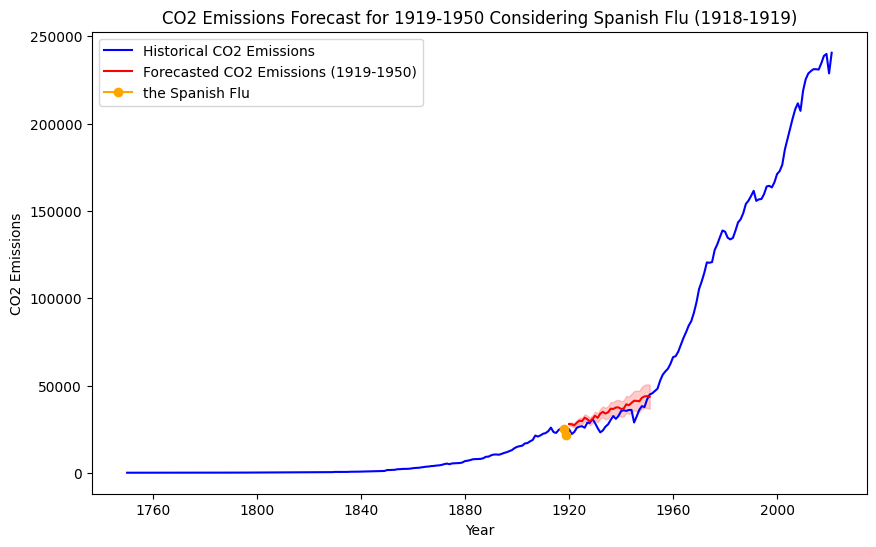

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ensure 'year' is part of the index and properly recognized
df_global_co2.index = pd.to_datetime(df_global_co2.index, format='%Y')  # Ensure index is datetime format

# Define the training period (1751 to 1918)
start_train = '1751'
end_train = '1918'

# Define the forecasting period (1919 to 1950)
start_forecast = '1919'
end_forecast = '1950'

# Train data from 1751 to 1918
train_data = df_global_co2.loc[start_train:end_train]  # Use string for year-based index

# Define SARIMA model (you can adjust p, d, q, P, D, Q, and seasonal_periods if needed)
sarima_model = SARIMAX(train_data,
                      order=(2, 1, 2),  # Non-seasonal ARIMA part (p, d, q)
                      seasonal_order=(1, 1, 1, 12))  # Seasonal components (P, D, Q, s)

# Fit the SARIMA model
sarima_result = sarima_model.fit()

# Forecasting from 1919 to 1950 (for 32 years)
forecast_steps = pd.to_datetime(end_forecast, format='%Y').year - pd.to_datetime(start_forecast, format='%Y').year + 1

forecast = sarima_result.get_forecast(steps=forecast_steps)

# Create a forecast index starting from 1919
forecast_index = pd.date_range(start=start_forecast, periods=forecast_steps, freq='Y')

# Get the forecasted values
forecast_values = forecast.predicted_mean

# Plotting the historical CO2 emissions and forecasted values
plt.figure(figsize=(10, 6))

# Plot the historical data (1751 to 1918) in blue
plt.plot(df_global_co2.index, df_global_co2, label='Historical CO2 Emissions', color='blue')

# Plot the forecasted CO2 emissions (1919 to 1950) in red
plt.plot(forecast_index, forecast_values, label='Forecasted CO2 Emissions (1919-1950)', color='red')

# Define the Spanish Flu period (1918-1919)
start_flu = '1918'
end_flu = '1919'
# Highlight the 1991 period (Mount Pinatubo and Kuwaiti oil fires)
highlight_start = '1918'
highlight_end = '1919'
highlight_data = df_global_co2.loc[highlight_start:highlight_end]
plt.plot(highlight_data.index, highlight_data, color='orange', marker='o', label='the Spanish Flu')

# Plot the confidence intervals for the forecasted values
plt.fill_between(forecast_index, forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1], color='red', alpha=0.2)

# Labels and title
plt.legend()
plt.title(f"CO2 Emissions Forecast for 1919-1950 Considering Spanish Flu (1918-1919)")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions")
plt.savefig("CO2 Emissions Forecast for 1919-1950 Considering Spanish Flu (1918-1919).tiff", format='tiff')
plt.show()


In [ ]:
from sklearn.metrics import r2_score

# Get the fitted values from the SARIMA model
fitted_values = sarima_result.fittedvalues

# We will compare the fitted values with the actual historical data
# R² calculation (only for the historical data)
r_squared = r2_score(train_data, fitted_values)

print(f"R-squared (R²) for the training period (1751-1918): {r_squared:.4f}")


R-squared (R²) for the training period (1751-1918): 0.9969


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-26-1c6c015a77f3>:34: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' i

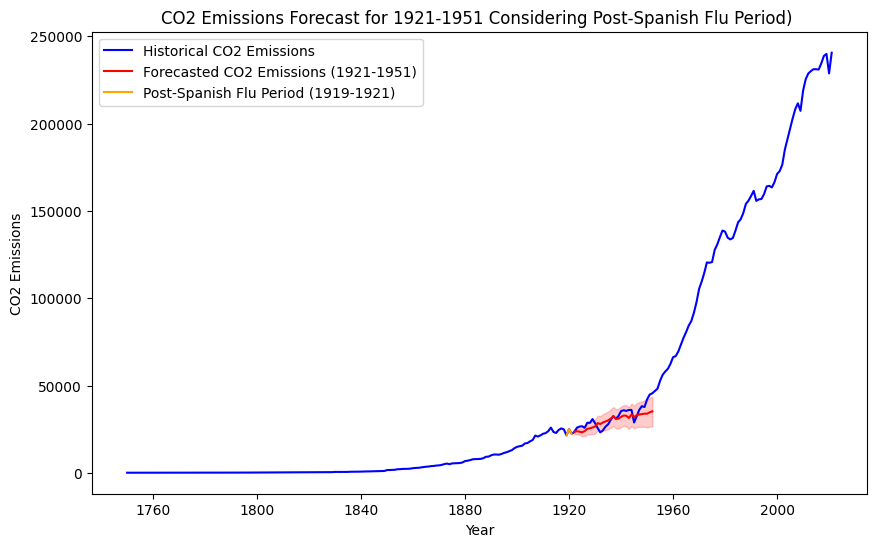

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score

# Ensure 'year' is part of the index and properly recognized
df_global_co2.index = pd.to_datetime(df_global_co2.index, format='%Y')  # Ensure index is datetime format

# Define the training period (1751 to 1918)
start_train = '1751'
end_train = '1921'

# Define the forecasting period (1921 to 1951)
start_forecast = '1921'
end_forecast = '1951'

# Train data from 1751 to 1918
train_data = df_global_co2.loc[start_train:end_train]  # Use string for year-based index

# Define SARIMA model (you can adjust p, d, q, P, D, Q, and seasonal_periods if needed)
sarima_model = SARIMAX(train_data,
                      order=(2, 1, 2),  # Non-seasonal ARIMA part (p, d, q)
                      seasonal_order=(1, 1, 1, 12))  # Seasonal components (P, D, Q, s)

# Fit the SARIMA model
sarima_result = sarima_model.fit()

# Forecasting from 1921 to 1951 (31 years)
forecast_steps = pd.to_datetime(end_forecast, format='%Y').year - pd.to_datetime(start_forecast, format='%Y').year + 1

forecast = sarima_result.get_forecast(steps=forecast_steps)

# Create a forecast index starting from 1921
forecast_index = pd.date_range(start=start_forecast, periods=forecast_steps, freq='Y')

# Get the forecasted values
forecast_values = forecast.predicted_mean

# Plotting the historical CO2 emissions and forecasted values
plt.figure(figsize=(10, 6))

# Plot the historical data (1751 to 1918) in blue
plt.plot(df_global_co2.index, df_global_co2, label='Historical CO2 Emissions', color='blue')

# Plot the forecasted CO2 emissions (1921 to 1951) in red
plt.plot(forecast_index, forecast_values, label='Forecasted CO2 Emissions (1921-1951)', color='red')

# Define the post-Spanish Flu period (1919-1921)
start_spanish_flu = '1919'
end_spanish_flu = '1921'

# Plot the post-Spanish Flu period data (1919 to 1921) in orange
spanish_flu_data = df_global_co2.loc[start_spanish_flu:end_spanish_flu]
plt.plot(spanish_flu_data.index, spanish_flu_data, color='orange', label='Post-Spanish Flu Period (1919-1921)')

# Plot the confidence intervals for the forecasted values
plt.fill_between(forecast_index, forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1], color='red', alpha=0.2)

# Labels and title
plt.legend()
plt.title(f"CO2 Emissions Forecast for 1921-1951 Considering Post-Spanish Flu Period) ")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions")
plt.savefig("CO2 Emissions Forecast for 1921-1951 Considering Post-Spanish Flu Period).tiff", format='tiff')
plt.show()




In [ ]:
from sklearn.metrics import r2_score

# Get the fitted values from the SARIMA model (for the training period 1919-1921)
fitted_values = sarima_result.fittedvalues

# Compare the fitted values with the actual training data (1919-1921)
r_squared = r2_score(train_data, fitted_values)

print(f"R-squared (R²) for the training period (1919-1921): {r_squared}")

R-squared (R²) for the training period (1919-1921): 0.9944818824359652


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-28-000a1e2a29e9>:34: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  forecast_index = pd.date_range(start=start_forecast, periods=forecast_steps, freq='Y')


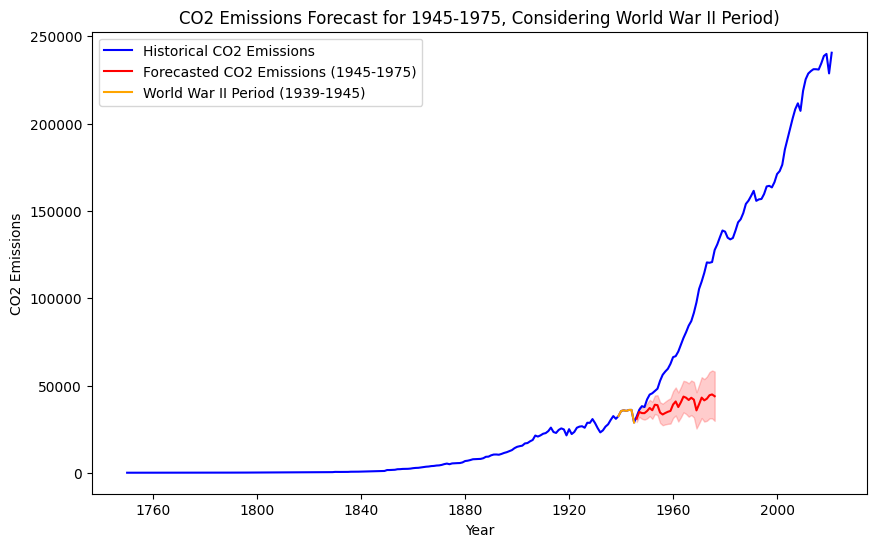

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score

# Ensure 'year' is part of the index and properly recognized
df_global_co2.index = pd.to_datetime(df_global_co2.index, format='%Y')  # Ensure index is datetime format

# Define the training period (1751 to 1939)
start_train = '1751'
end_train = '1945'

# Define the forecasting period (1945 to 1975)
start_forecast = '1945'
end_forecast = '1975'

# Train data from 1751 to 1939
train_data = df_global_co2.loc[start_train:end_train]  # Use string for year-based index

# Define SARIMA model (you can adjust p, d, q, P, D, Q, and seasonal_periods if needed)
sarima_model = SARIMAX(train_data,
                      order=(2, 1, 2),  # Non-seasonal ARIMA part (p, d, q)
                      seasonal_order=(1, 1, 1, 12))  # Seasonal components (P, D, Q, s)

# Fit the SARIMA model
sarima_result = sarima_model.fit()

# Forecasting from 1945 to 1975 (31 years)
forecast_steps = pd.to_datetime(end_forecast, format='%Y').year - pd.to_datetime(start_forecast, format='%Y').year + 1

forecast = sarima_result.get_forecast(steps=forecast_steps)

# Create a forecast index starting from 1945
forecast_index = pd.date_range(start=start_forecast, periods=forecast_steps, freq='Y')

# Get the forecasted values
forecast_values = forecast.predicted_mean

# Plotting the historical CO2 emissions and forecasted values
plt.figure(figsize=(10, 6))

# Plot the historical data (1751 to 1939) in blue
plt.plot(df_global_co2.index, df_global_co2, label='Historical CO2 Emissions', color='blue')

# Plot the forecasted CO2 emissions (1945 to 1975) in red
plt.plot(forecast_index, forecast_values, label='Forecasted CO2 Emissions (1945-1975)', color='red')

# Define the World War II period (1939-1945)
start_wwii = '1939'
end_wwii = '1945'

# Plot the World War II period data (1939 to 1945) in orange
wwii_data = df_global_co2.loc[start_wwii:end_wwii]
plt.plot(wwii_data.index, wwii_data, color='orange', label='World War II Period (1939-1945)')

# Plot the confidence intervals for the forecasted values
plt.fill_between(forecast_index, forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1], color='red', alpha=0.2)

# Labels and title
plt.legend()
plt.title(f"CO2 Emissions Forecast for 1945-1975, Considering World War II Period)")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions")
plt.savefig("CO2 Emissions Forecast for 1945-1975, Considering World War II Period)).tiff", format='tiff')
plt.show()




In [ ]:
from sklearn.metrics import r2_score

# Get the fitted values from the SARIMA model (for the training period 1939-1945)
fitted_values = sarima_result.fittedvalues

# Compare the fitted values with the actual training data (1939-1945)
r_squared = r2_score(train_data, fitted_values)

print(f"R-squared (R²) for the training period (1939-1945): {r_squared}")

R-squared (R²) for the training period (1939-1945): 0.9932753680500037


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-30-36ef829a2b38>:34: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  forecast_index = pd.date_range(start=start_forecast, periods=forecast_steps, freq='Y')


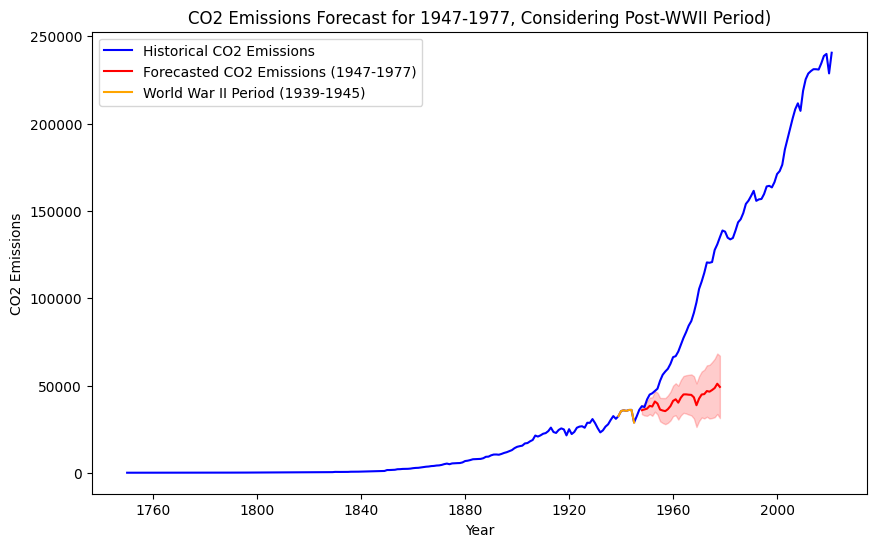

R-squared (R²) for the training period (1751-1945): 0.9937


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score

# Ensure 'year' is part of the index and properly recognized
df_global_co2.index = pd.to_datetime(df_global_co2.index, format='%Y')  # Ensure index is datetime format

# Define the training period (1751 to 1945)
start_train = '1751'
end_train = '1947'

# Define the forecasting period (1947 to 1977)
start_forecast = '1947'
end_forecast = '1977'

# Train data from 1751 to 1945
train_data = df_global_co2.loc[start_train:end_train]  # Use string for year-based index

# Define SARIMA model (you can adjust p, d, q, P, D, Q, and seasonal_periods if needed)
sarima_model = SARIMAX(train_data,
                      order=(2, 1, 2),  # Non-seasonal ARIMA part (p, d, q)
                      seasonal_order=(1, 1, 1, 12))  # Seasonal components (P, D, Q, s)

# Fit the SARIMA model
sarima_result = sarima_model.fit()

# Forecasting from 1947 to 1977 (31 years)
forecast_steps = pd.to_datetime(end_forecast, format='%Y').year - pd.to_datetime(start_forecast, format='%Y').year + 1

forecast = sarima_result.get_forecast(steps=forecast_steps)

# Create a forecast index starting from 1947
forecast_index = pd.date_range(start=start_forecast, periods=forecast_steps, freq='Y')

# Get the forecasted values
forecast_values = forecast.predicted_mean

# Plotting the historical CO2 emissions and forecasted values
plt.figure(figsize=(10, 6))

# Plot the historical data (1751 to 1945) in blue
plt.plot(df_global_co2.index, df_global_co2, label='Historical CO2 Emissions', color='blue')

# Plot the forecasted CO2 emissions (1947 to 1977) in red
plt.plot(forecast_index, forecast_values, label='Forecasted CO2 Emissions (1947-1977)', color='red')

# Define the World War II period (1939-1945)
start_wwii = '1939'
end_wwii = '1945'

# Plot the World War II period data (1939 to 1945) in orange
wwii_data = df_global_co2.loc[start_wwii:end_wwii]
plt.plot(wwii_data.index, wwii_data, color='orange', label='World War II Period (1939-1945)')

# Plot the confidence intervals for the forecasted values
plt.fill_between(forecast_index, forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1], color='red', alpha=0.2)

# Labels and title
plt.legend()
plt.title(f"CO2 Emissions Forecast for 1947-1977, Considering Post-WWII Period)")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions")
plt.savefig("CO2 Emissions Forecast for 1947-1977, Considering Post-WWII Period.tiff", format='tiff')
plt.show()

# Calculate R-squared for the training period
fitted_values = sarima_result.fittedvalues.loc[start_train:end_train]

# Calculate R² for the training period
r_squared_training = r2_score(train_data, fitted_values)

print(f"R-squared (R²) for the training period (1751-1945): {r_squared_training:.4f}")


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-31-89453adcb6cc>:34: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  forecast_index = pd.date_range(start=start_forecast, periods=forecast_steps, freq='Y')


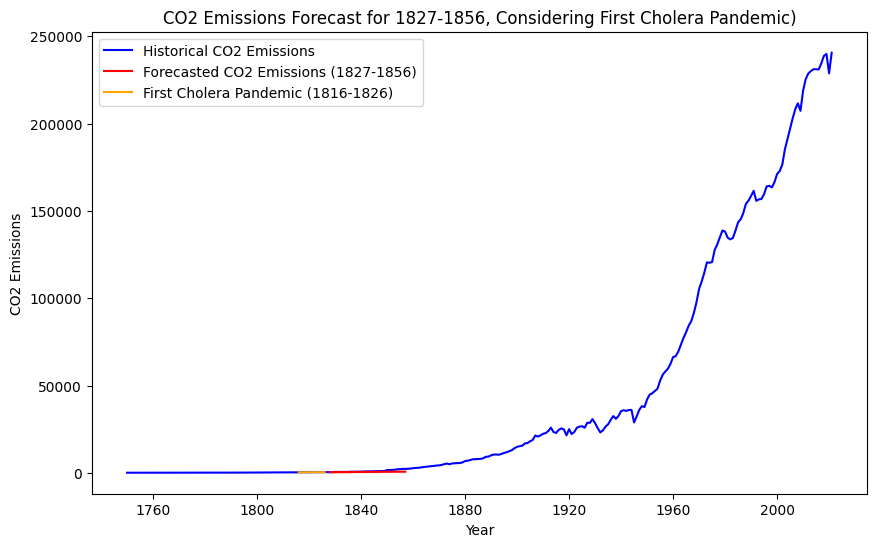

R-squared (R²) for the training period (1751-1826): 0.9854


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score

# Ensure 'year' is part of the index and properly recognized
df_global_co2.index = pd.to_datetime(df_global_co2.index, format='%Y')  # Ensure index is datetime format

# Define the training period (1751 to 1826)
start_train = '1751'
end_train = '1826'

# Define the forecasting period (1827 to 1856)
start_forecast = '1827'
end_forecast = '1856'

# Train data from 1751 to 1826
train_data = df_global_co2.loc[start_train:end_train]  # Use string for year-based index

# Define SARIMA model (adjust p, d, q, P, D, Q, and seasonal_periods as needed)
sarima_model = SARIMAX(train_data,
                      order=(2, 1, 2),  # Non-seasonal ARIMA part (p, d, q)
                      seasonal_order=(1, 1, 1, 12))  # Seasonal components (P, D, Q, s)

# Fit the SARIMA model
sarima_result = sarima_model.fit()

# Forecasting from 1827 to 1856 (30 years)
forecast_steps = pd.to_datetime(end_forecast, format='%Y').year - pd.to_datetime(start_forecast, format='%Y').year + 1

forecast = sarima_result.get_forecast(steps=forecast_steps)

# Create a forecast index starting from 1827
forecast_index = pd.date_range(start=start_forecast, periods=forecast_steps, freq='Y')

# Get the forecasted values
forecast_values = forecast.predicted_mean

# Plotting the historical CO2 emissions and forecasted values
plt.figure(figsize=(10, 6))

# Plot the historical data (1751 to 1826) in blue
plt.plot(df_global_co2.index, df_global_co2, label='Historical CO2 Emissions', color='blue')

# Plot the forecasted CO2 emissions (1827 to 1856) in red
plt.plot(forecast_index, forecast_values, label='Forecasted CO2 Emissions (1827-1856)', color='red')

# Define the First Cholera Pandemic period (1816-1826)
start_cholera = '1816'
end_cholera = '1826'

# Plot the cholera pandemic period data (1816 to 1826) in orange
cholera_data = df_global_co2.loc[start_cholera:end_cholera]
plt.plot(cholera_data.index, cholera_data, color='orange', label='First Cholera Pandemic (1816-1826)')

# Plot the confidence intervals for the forecasted values
plt.fill_between(forecast_index, forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1], color='red', alpha=0.2)

# Labels and title
plt.legend()
plt.title(f"CO2 Emissions Forecast for 1827-1856, Considering First Cholera Pandemic)")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions")
plt.savefig("CO2 Emissions Forecast for 1827-1856, Considering First Cholera Pandemic.tiff", format='tiff')
plt.show()

# Calculate R-squared for the training period
fitted_values = sarima_result.fittedvalues.loc[start_train:end_train]

# Calculate R² for the training period
r_squared_training = r2_score(train_data, fitted_values)

print(f"R-squared (R²) for the training period (1751-1826): {r_squared_training:.4f}")


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
<ipython-input-32-7a4267e3996e>:34: FutureWarning: 'Y' is deprecated and will be removed in a future versio

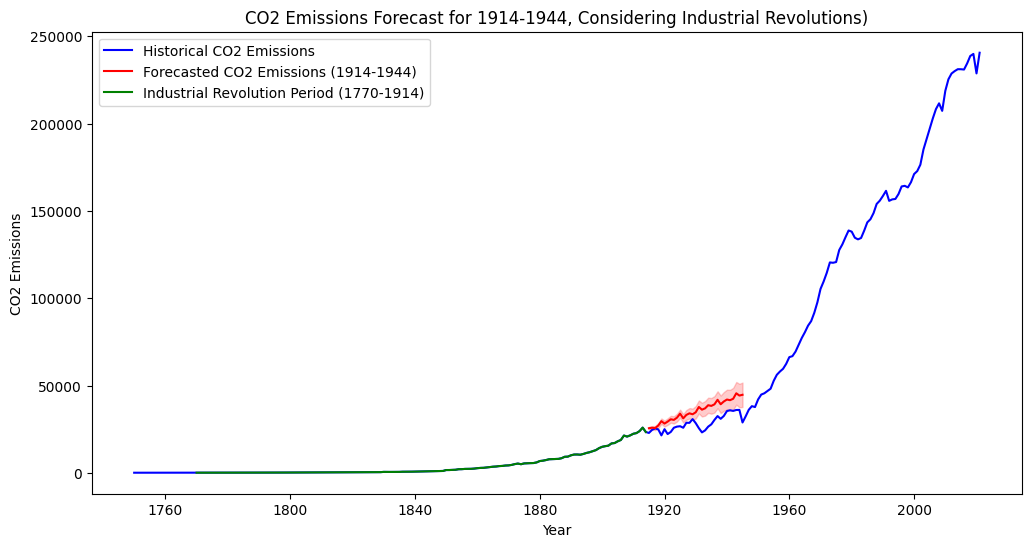

R-squared (R²) for the training period (1770-1914): 0.9968


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score

# Ensure 'year' is part of the index and properly recognized
df_global_co2.index = pd.to_datetime(df_global_co2.index, format='%Y')  # Ensure index is datetime format

# Define the training period (1770 to 1914)
start_train = '1770'
end_train = '1914'

# Define the forecasting period (1914 to 1944)
start_forecast = '1914'
end_forecast = '1944'

# Train data from 1770 to 1914
train_data = df_global_co2.loc[start_train:end_train]  # Use string for year-based index

# Define SARIMA model (adjust p, d, q, P, D, Q, and seasonal_periods as needed)
sarima_model = SARIMAX(train_data,
                      order=(2, 1, 2),  # Non-seasonal ARIMA part (p, d, q)
                      seasonal_order=(1, 1, 1, 12))  # Seasonal components (P, D, Q, s)

# Fit the SARIMA model
sarima_result = sarima_model.fit()

# Forecasting from 1914 to 1944 (31 years)
forecast_steps = pd.to_datetime(end_forecast, format='%Y').year - pd.to_datetime(start_forecast, format='%Y').year + 1

forecast = sarima_result.get_forecast(steps=forecast_steps)

# Create a forecast index starting from 1914
forecast_index = pd.date_range(start=start_forecast, periods=forecast_steps, freq='Y')

# Get the forecasted values
forecast_values = forecast.predicted_mean

# Plotting the historical CO2 emissions and forecasted values
plt.figure(figsize=(12, 6))

# Plot the historical data (1770 to 1914) in blue
plt.plot(df_global_co2.index, df_global_co2, label='Historical CO2 Emissions', color='blue')

# Plot the forecasted CO2 emissions (1914 to 1944) in red
plt.plot(forecast_index, forecast_values, label='Forecasted CO2 Emissions (1914-1944)', color='red')

# Define the Industrial Revolution period (1770 to 1914)
start_industrial = '1770'
end_industrial = '1914'

# Plot the Industrial Revolution period data (1770 to 1914) in green
industrial_data = df_global_co2.loc[start_industrial:end_industrial]
plt.plot(industrial_data.index, industrial_data, color='green', label='Industrial Revolution Period (1770-1914)')

# Plot the confidence intervals for the forecasted values
plt.fill_between(forecast_index, forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1], color='red', alpha=0.2)

# Labels and title
plt.legend()
plt.title(f"CO2 Emissions Forecast for 1914-1944, Considering Industrial Revolutions)")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions")
plt.savefig("CO2 Emissions Forecast for 1914-1944, Considering Industrial Revolutions.tiff", format='tiff')
plt.show()

# Calculate R-squared for the training period
fitted_values = sarima_result.fittedvalues.loc[start_train:end_train]

# Calculate R² for the training period
r_squared_training = r2_score(train_data, fitted_values)

print(f"R-squared (R²) for the training period (1770-1914): {r_squared_training:.4f}")


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-33-a472caa36888>:34: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  forecast_index = pd.date_range(start=start_forecast, periods=forecast_steps, freq='Y')


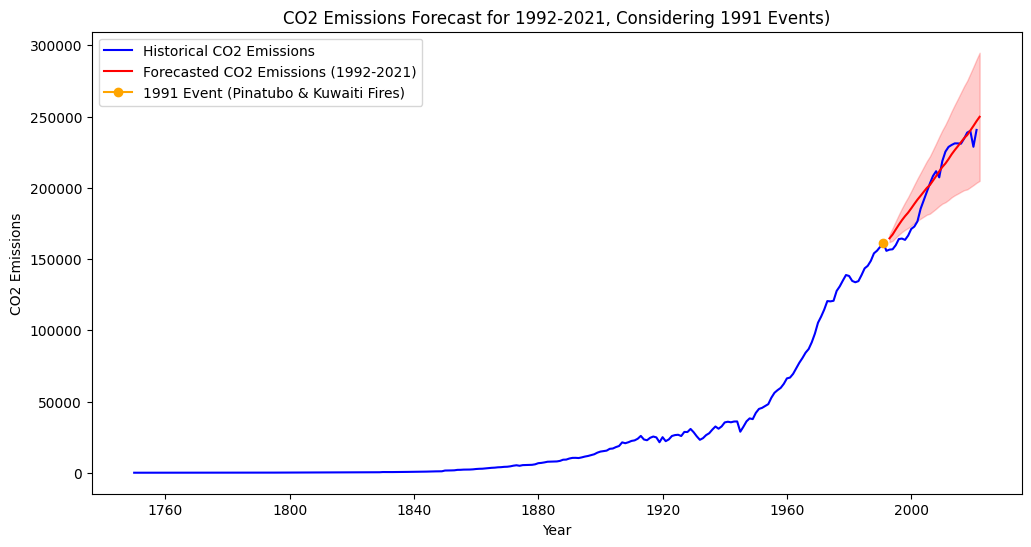

R-squared (R²) for the training period (1751-1991): 0.9989


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score

# Ensure 'year' is part of the index and properly recognized
df_global_co2.index = pd.to_datetime(df_global_co2.index, format='%Y')  # Ensure index is datetime format

# Define the training period (1751 to 1991)
start_train = '1751'
end_train = '1991'

# Define the forecasting period (1992 to 2021)
start_forecast = '1992'
end_forecast = '2021'

# Train data from 1751 to 1991
train_data = df_global_co2.loc[start_train:end_train]  # Use string for year-based index

# Define SARIMA model (adjust p, d, q, P, D, Q, and seasonal_periods as needed)
sarima_model = SARIMAX(train_data,
                      order=(2, 1, 2),  # Non-seasonal ARIMA part (p, d, q)
                      seasonal_order=(1, 1, 1, 12))  # Seasonal components (P, D, Q, s)

# Fit the SARIMA model
sarima_result = sarima_model.fit()

# Forecasting from 1992 to 2021 (30 years)
forecast_steps = pd.to_datetime(end_forecast, format='%Y').year - pd.to_datetime(start_forecast, format='%Y').year + 1

forecast = sarima_result.get_forecast(steps=forecast_steps)

# Create a forecast index starting from 1992
forecast_index = pd.date_range(start=start_forecast, periods=forecast_steps, freq='Y')

# Get the forecasted values
forecast_values = forecast.predicted_mean

# Plotting the historical CO2 emissions and forecasted values
plt.figure(figsize=(12, 6))

# Plot the historical data (1751 to 1991) in blue
plt.plot(df_global_co2.index, df_global_co2, label='Historical CO2 Emissions', color='blue')

# Plot the forecasted CO2 emissions (1992 to 2021) in red
plt.plot(forecast_index, forecast_values, label='Forecasted CO2 Emissions (1992-2021)', color='red')

# Highlight the 1991 period (Mount Pinatubo and Kuwaiti oil fires)
highlight_start = '1991'
highlight_end = '1991'
highlight_data = df_global_co2.loc[highlight_start:highlight_end]
plt.plot(highlight_data.index, highlight_data, color='orange', marker='o', label='1991 Event (Pinatubo & Kuwaiti Fires)')

# Plot the confidence intervals for the forecasted values
plt.fill_between(forecast_index, forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1], color='red', alpha=0.2)

# Labels and title
plt.legend()
plt.title(f"CO2 Emissions Forecast for 1992-2021, Considering 1991 Events)")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions")
plt.savefig("CO2 Emissions Forecast for 1992-2021, Considering 1991 Events.tiff", format='tiff')
plt.show()

# Calculate R-squared for the training period
fitted_values = sarima_result.fittedvalues.loc[start_train:end_train]

# Calculate R² for the training period
r_squared_training = r2_score(train_data, fitted_values)

print(f"R-squared (R²) for the training period (1751-1991): {r_squared_training:.4f}")


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Model Performance Comparison:
                                MAE          RMSE         R²
SARIMA                  1397.951250   1541.651536   0.915337
ARIMA                   2310.110299   2703.001127   0.739736
Exponential Smoothing   7700.624000   9336.629752  -2.105290
Prophet                 2152.030182   2576.421849   0.763541
LSTM                   30387.178880  30845.630959 -32.892935


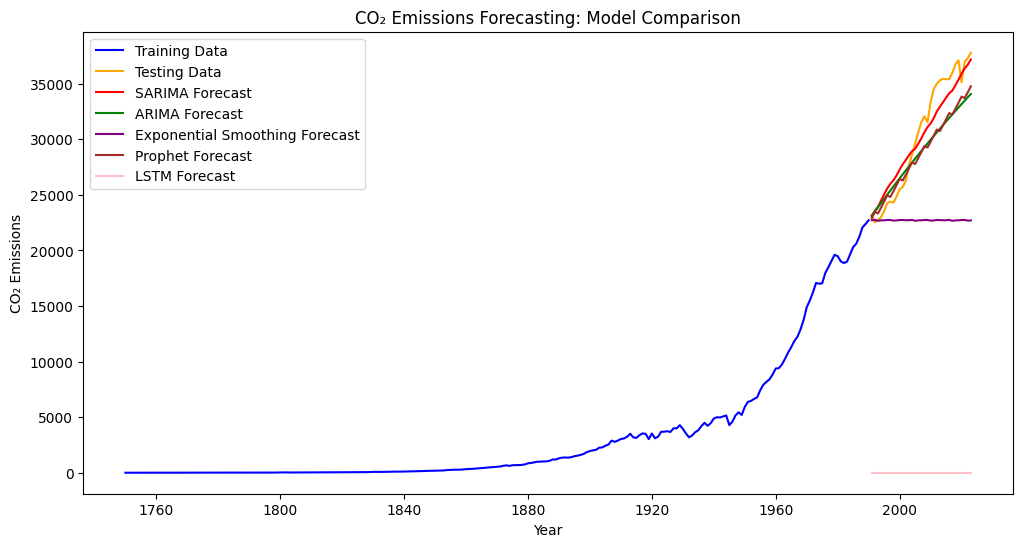

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load the dataset
url = "https://github.com/owid/co2-data/raw/master/owid-co2-data.csv"
df = pd.read_csv(url)

# Filter the dataset for global CO₂ emissions
df_global = df[df['country'] == 'World'][['year', 'co2']]
df_global = df_global.dropna().set_index('year')
df_global.index = pd.to_datetime(df_global.index, format='%Y')

# Split data into training and testing sets
train_data = df_global.loc[:'1990']
test_data = df_global.loc['1991':]

# Define evaluation metrics
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2 = r2_score(true, predicted)
    return mae, rmse, r2

# Initialize results dictionary
results = {}

# ---------------- SARIMA ---------------- #
sarima_model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit()
sarima_forecast = sarima_fit.get_forecast(steps=len(test_data)).predicted_mean
results['SARIMA'] = evaluate_model(test_data, sarima_forecast)

# ---------------- ARIMA ---------------- #
arima_model = ARIMA(train_data, order=(1, 1, 1))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(test_data))
results['ARIMA'] = evaluate_model(test_data, arima_forecast)

# ---------------- Exponential Smoothing ---------------- #
es_model = ExponentialSmoothing(train_data, seasonal='add', seasonal_periods=12)
es_fit = es_model.fit()
es_forecast = es_fit.forecast(steps=len(test_data))
results['Exponential Smoothing'] = evaluate_model(test_data, es_forecast)

# ---------------- Prophet ---------------- #
prophet_data = train_data.reset_index()
prophet_data.columns = ['ds', 'y']
prophet_model = Prophet()
prophet_model.fit(prophet_data)
future = prophet_model.make_future_dataframe(periods=len(test_data), freq='Y')
prophet_forecast = prophet_model.predict(future)['yhat'].iloc[-len(test_data):].values
results['Prophet'] = evaluate_model(test_data.values, prophet_forecast)

# ---------------- LSTM ---------------- #
# Prepare data for LSTM
def create_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data)-look_back):
        X.append(data[i:(i+look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 1
train_data_lstm = train_data.values
test_data_lstm = test_data.values

# Reshape the data for LSTM [samples, time steps, features]
train_data_lstm = train_data_lstm.reshape((train_data_lstm.shape[0], 1, train_data_lstm.shape[1]))
test_data_lstm = test_data_lstm.reshape((test_data_lstm.shape[0], 1, test_data_lstm.shape[1]))

# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=False, input_shape=(train_data_lstm.shape[1], train_data_lstm.shape[2])))
lstm_model.add(Dense(units=1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
lstm_model.fit(train_data_lstm, train_data.values, epochs=50, batch_size=32, verbose=0)

# Predict with LSTM
lstm_forecast = lstm_model.predict(test_data_lstm)
results['LSTM'] = evaluate_model(test_data.values, lstm_forecast)

# Compare Results
results_df = pd.DataFrame(results, index=['MAE', 'RMSE', 'R²']).T

# Display Results
print("Model Performance Comparison:")
print(results_df)

# Plotting the forecasts
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data', color='blue')
plt.plot(test_data, label='Testing Data', color='orange')
plt.plot(test_data.index, sarima_forecast, label='SARIMA Forecast', color='red')
plt.plot(test_data.index, arima_forecast, label='ARIMA Forecast', color='green')
plt.plot(test_data.index, es_forecast, label='Exponential Smoothing Forecast', color='purple')
plt.plot(test_data.index, prophet_forecast, label='Prophet Forecast', color='brown')
plt.plot(test_data.index, lstm_forecast, label='LSTM Forecast', color='pink')
plt.legend()
plt.title('CO₂ Emissions Forecasting: Model Comparison')
plt.xlabel('Year')
plt.ylabel('CO₂ Emissions')
plt.savefig("CO₂ Emissions Forecasting: Model Comparison.tiff", format='tiff')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Load your dataset (assuming df_global_co2 is already preprocessed with 'year' as index)
# df_global_co2 = pd.read_csv('your_data.csv', parse_dates=['year'], index_col='year')


In [ ]:
# Convert Series to DataFrame
df_global_co2 = df_global_co2.to_frame()

# Check the first few rows to ensure the data is correctly structured
print(df_global_co2.head())



               co2
year              
1750-01-01  56.106
1751-01-01  56.106
1752-01-01  56.124
1753-01-01  56.124
1754-01-01  56.148


T-statistic: [2.52663168]
P-value: [0.03241402]


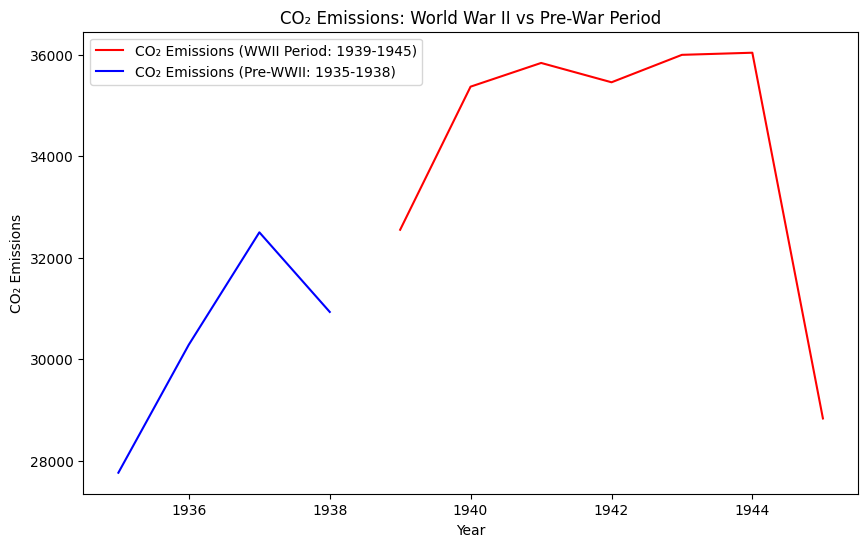

Reject the null hypothesis: There is a significant deviation in CO₂ emissions during WWII.


In [ ]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# Define the event period (WWII: 1939-1945) and baseline period (pre-WWII: 1935-1938)
event_period = df_global_co2.loc['1939-01-01':'1945-01-01']
baseline_period = df_global_co2.loc['1935-01-01':'1938-01-01']

# Perform the t-test (independent samples) between the event period and baseline period
t_stat, p_value = stats.ttest_ind(event_period, baseline_period, nan_policy='omit')

# Print the result of the t-test
print("T-statistic:", t_stat)
print("P-value:", p_value)

# Visualize the CO2 emissions during the WWII and pre-WWII periods
plt.figure(figsize=(10, 6))
plt.plot(event_period.index, event_period, label="CO₂ Emissions (WWII Period: 1939-1945)", color='red')
plt.plot(baseline_period.index, baseline_period, label="CO₂ Emissions (Pre-WWII: 1935-1938)", color='blue')

plt.title('CO₂ Emissions: World War II vs Pre-War Period')
plt.xlabel('Year')
plt.ylabel('CO₂ Emissions')
plt.legend(loc='upper left')
plt.savefig("CO₂ Emissions: World War II vs Pre-War Period'.tiff", format='tiff')
plt.show()

# Hypothesis testing interpretation
if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant deviation in CO₂ emissions during WWII.")
else:
    print("Fail to reject the null hypothesis: No significant deviation in CO₂ emissions during WWII.")


In [ ]:
# Define the event period (1816-1826) and the extended baseline period (1810-1815)
event_period_cholera = df_global_co2.loc['1816-01-01':'1826-12-31']
#Extend the baseline period (1805-1815) for more data points
extended_baseline_period_cholera = df_global_co2.loc['1805-01-01':'1815-12-31']

# Perform the t-test again with the extended baseline period
t_statistic_cholera_extended, p_value_cholera_extended = stats.ttest_ind(event_period_cholera, extended_baseline_period_cholera, equal_var=False)

# Display the test results
print(f"Event period (1816-1826) data:\n{event_period_cholera}\n")
print(f"Extended baseline period (1805-1815) data:\n{extended_baseline_period_cholera}\n")
print(f"T-statistic: {t_statistic_cholera_extended}")
print(f"P-value: {p_value_cholera_extended}")

# Interpret the results
if p_value_cholera_extended < 0.05:
    print("Reject the null hypothesis: There is a significant deviation in CO₂ emissions during the cholera event period.")
else:
    print("Fail to reject the null hypothesis: No significant deviation in CO₂ emissions during the cholera event period.")


Event period (1816-1826) data:
                co2
year               
1816-01-01  284.660
1817-01-01  295.146
1818-01-01  296.296
1819-01-01  298.160
1820-01-01  302.541
1821-01-01  306.952
1822-01-01  319.057
1823-01-01  337.495
1824-01-01  349.117
1825-01-01  362.263
1826-01-01  365.886

Extended baseline period (1805-1815) data:
                co2
year               
1805-01-01  199.832
1806-01-01  209.606
1807-01-01  220.486
1808-01-01  209.600
1809-01-01  209.731
1810-01-01  223.442
1811-01-01  236.598
1812-01-01  245.073
1813-01-01  246.275
1814-01-01  251.647
1815-01-01  259.724

T-statistic: [8.55107352]
P-value: [9.69492987e-08]
Reject the null hypothesis: There is a significant deviation in CO₂ emissions during the cholera event period.


In [ ]:
# Define the extended event period (2019-2022)
event_period_covid = df_global_co2.loc['2019-01-01':'2022-12-31']

# Define the extended baseline period (2010-2018)
extended_baseline_period_covid = df_global_co2.loc['2010-01-01':'2018-12-31']

# Perform the t-test with the extended periods
t_statistic_covid_extended, p_value_covid_extended = stats.ttest_ind(
    event_period_covid, extended_baseline_period_covid, equal_var=False
)

# Display the test results
print(f"Extended event period (2019-2022) data:\n{event_period_covid}\n")
print(f"Extended baseline period (2010-2018) data:\n{extended_baseline_period_covid}\n")
print(f"T-statistic: {t_statistic_covid_extended}")
print(f"P-value: {p_value_covid_extended}")

# Interpretation
if p_value_covid_extended < 0.05:
    print("Reject the null hypothesis: There is a significant deviation in CO₂ emissions during the extended COVID-19 period.")
else:
    print("Fail to reject the null hypothesis: No significant deviation in CO₂ emissions during the extended COVID-19 period.")


Extended event period (2019-2022) data:
                   co2
year                  
2019-01-01  239925.740
2020-01-01  228766.484
2021-01-01  240609.645

Extended baseline period (2010-2018) data:
                   co2
year                  
2010-01-01  218779.976
2011-01-01  225395.930
2012-01-01  228692.215
2013-01-01  230084.113
2014-01-01  231175.635
2015-01-01  231156.163
2016-01-01  230973.213
2017-01-01  234500.508
2018-01-01  238741.382

T-statistic: [1.52134029]
P-value: [0.22529048]
Fail to reject the null hypothesis: No significant deviation in CO₂ emissions during the extended COVID-19 period.


In [ ]:
df['year'] = pd.to_datetime(df['year'], format='%Y')
# Create a new column with the same values as the 'year' column
df['year_copy'] = df['year']

# Set the 'year_copy' column as the index
df.set_index('year_copy', inplace=True)
#df.set_index('year', inplace=True)

In [ ]:

start_date = pd.to_datetime('1751', format='%Y')
end_date = pd.to_datetime('2018', format='%Y')
co2_data = df.loc[(df.index >= start_date) & (df.index <= end_date), 'co2']
co2_data =co2_data.groupby(pd.Grouper(freq='Y')).sum()

<ipython-input-41-a446c67aad88>:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  co2_data =co2_data.groupby(pd.Grouper(freq='Y')).sum()


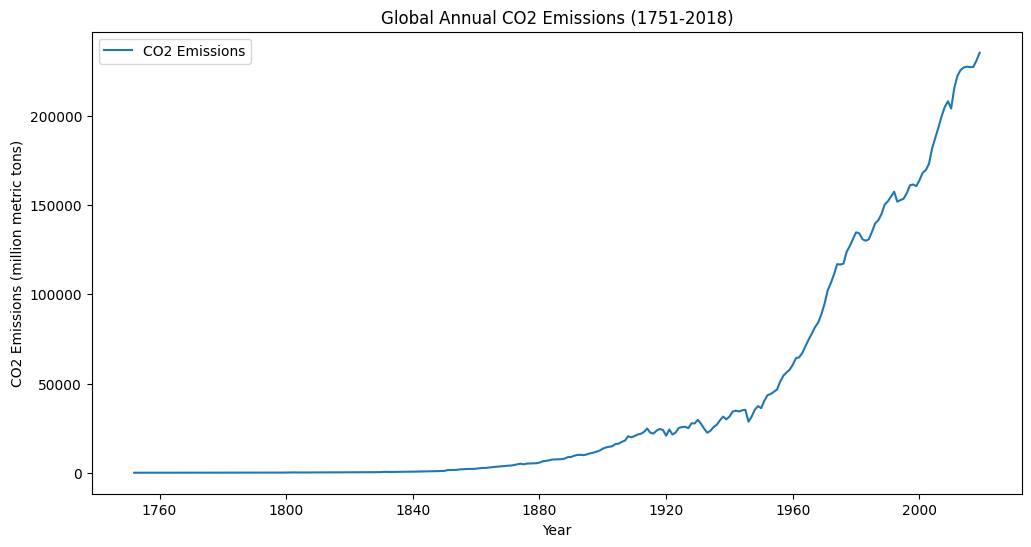

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(co2_data.index, co2_data, label='CO2 Emissions')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (million metric tons)')
plt.title('Global Annual CO2 Emissions (1751-2018)')
plt.legend()
plt.show()

In [ ]:
start_date = pd.to_datetime('1751', format='%Y')
end_date = pd.to_datetime('2019', format='%Y')
co2_data1 = df.loc[(df.index >= start_date) & (df.index <= end_date), 'co2']
co2_data1 =co2_data1.groupby(pd.Grouper(freq='Y')).sum()

<ipython-input-43-009c54cd91ba>:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  co2_data1 =co2_data1.groupby(pd.Grouper(freq='Y')).sum()


In [ ]:
print(co2_data1)

year_copy
1751-12-31        56.442
1752-12-31        57.030
1753-12-31        57.660
1754-12-31        58.404
1755-12-31        58.758
                 ...    
2015-12-31    227211.442
2016-12-31    227301.955
2017-12-31    230881.498
2018-12-31    235257.257
2019-12-31    237289.378
Freq: YE-DEC, Name: co2, Length: 269, dtype: float64


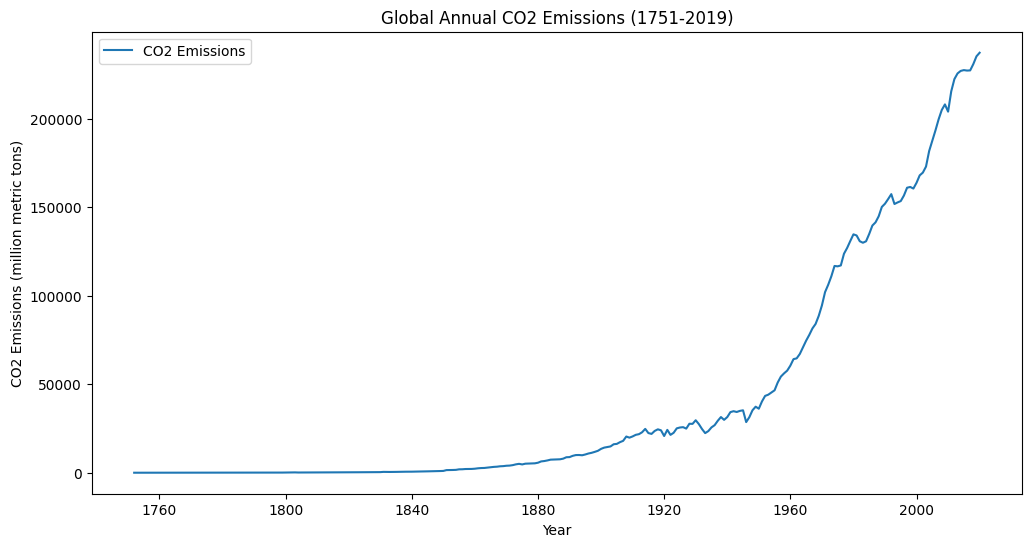

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(co2_data1.index, co2_data1, label='CO2 Emissions')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (million metric tons)')
plt.title('Global Annual CO2 Emissions (1751-2019)')
plt.legend()
plt.show()

In [ ]:
start_date = pd.to_datetime('1751', format='%Y')
end_date = pd.to_datetime('2021', format='%Y')
co2_data2 = df.loc[(df.index >= start_date) & (df.index <= end_date), 'co2']
co2_data2 =co2_data2.groupby(pd.Grouper(freq='Y')).sum()

<ipython-input-46-883c9afe4e5e>:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  co2_data2 =co2_data2.groupby(pd.Grouper(freq='Y')).sum()


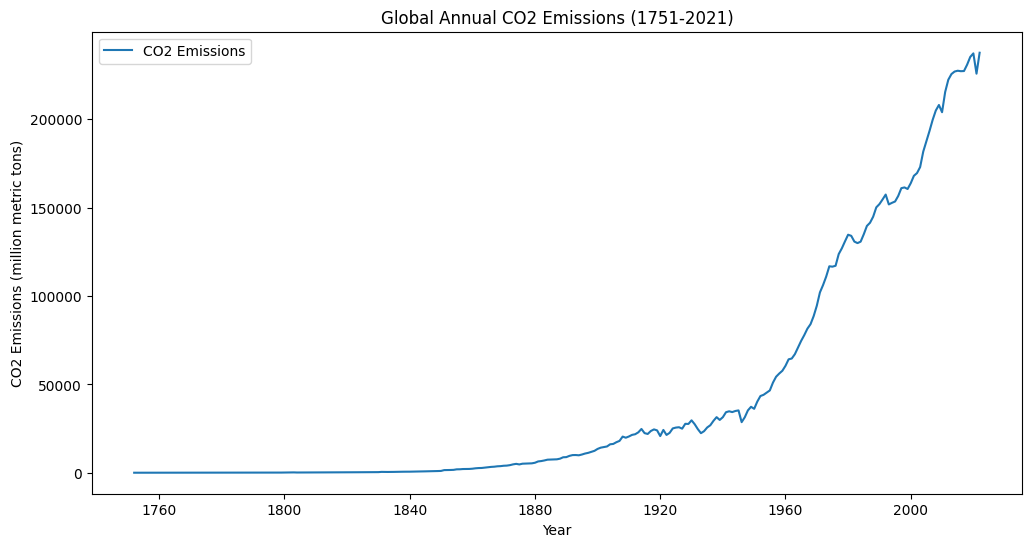

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(co2_data2.index, co2_data2, label='CO2 Emissions')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (million metric tons)')
plt.title('Global Annual CO2 Emissions (1751-2021)')
plt.legend()
plt.show()

In [ ]:
start_date = pd.to_datetime('1751', format='%Y')
end_date = pd.to_datetime('2023', format='%Y')
co2_data3 = df.loc[(df.index >= start_date) & (df.index <= end_date), 'co2']
co2_data3 =co2_data3.groupby(pd.Grouper(freq='Y')).sum()

<ipython-input-48-fcb8c7362825>:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  co2_data3 =co2_data3.groupby(pd.Grouper(freq='Y')).sum()


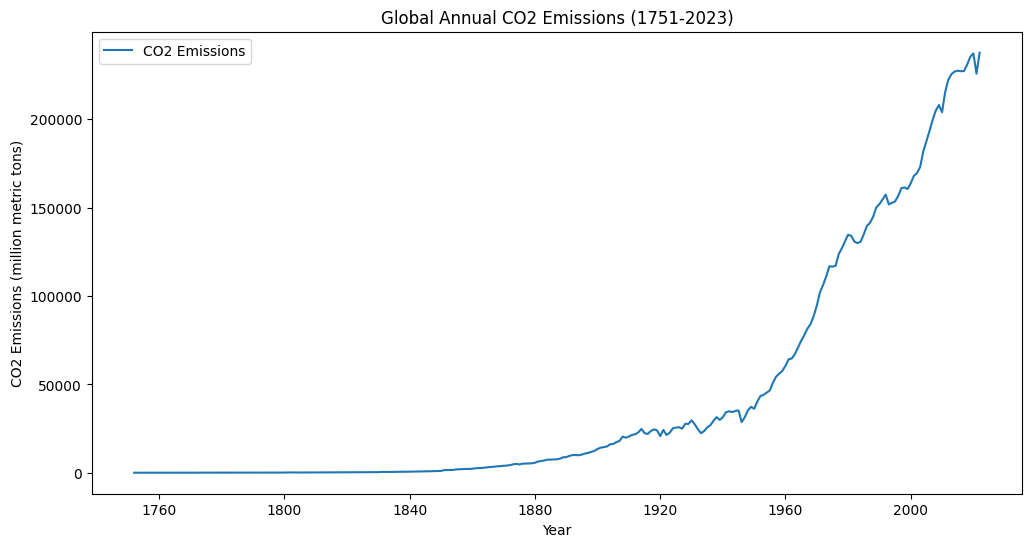

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(co2_data2.index, co2_data2, label='CO2 Emissions')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (million metric tons)')
plt.title('Global Annual CO2 Emissions (1751-2023)')
plt.legend()
plt.show()

<ipython-input-50-0eb094884751>:16: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()


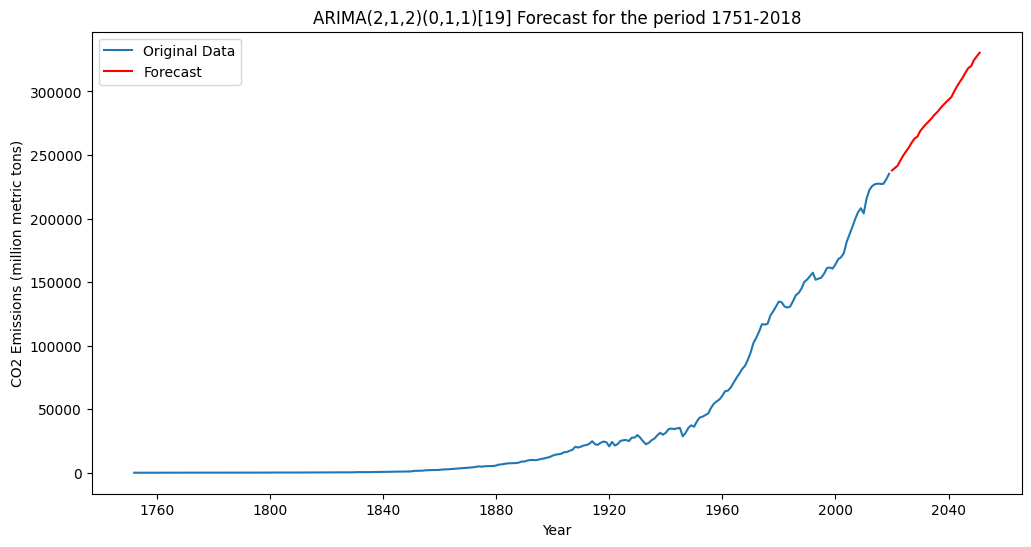

MAPE: 54.01%


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Calculate MAPE
def calculate_mape(actual, forecast):
    actual = np.nan_to_num(actual)
    forecast = np.nan_to_num(forecast)
    return (np.abs(actual - forecast) / actual).mean() * 100

# Selecting the data for the period 1751-2018
start_date = pd.to_datetime('1751', format='%Y')
end_date = pd.to_datetime('2018', format='%Y')
co2_data = df.loc[(df.index >= start_date) & (df.index <= end_date), 'co2']
co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()

# Fit the ARIMA model
model = ARIMA(co2_data, order=(1, 1, 2), seasonal_order=(0, 1, 1, 19))
model_fit = model.fit()

# Forecasting for 32 years
forecast_years = 32
forecast = model_fit.forecast(steps=forecast_years)

# Calculate the actual values for the period 1751-2018
actual_values = co2_data[-forecast_years:]

# Calculate the MAPE
mape = calculate_mape(actual_values, forecast)

# Plotting the original data and the forecasted values
plt.figure(figsize=(12, 6))
plt.plot(co2_data.index, co2_data, label='Original Data')
plt.plot(forecast.index, forecast, color='red', label='Forecast')
#plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color='gray', alpha=0.3)
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (million metric tons)')
plt.title('ARIMA(2,1,2)(0,1,1)[19] Forecast for the period 1751-2018')
plt.legend()
plt.show()

print(f"MAPE: {mape:.2f}%")


<ipython-input-51-03e15f0930af>:16: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()


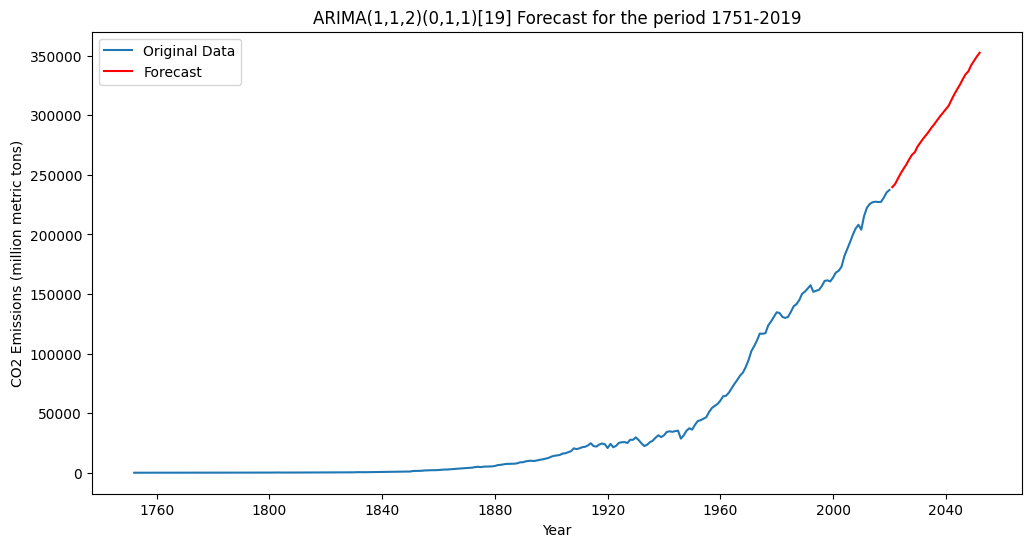

MAPE: 57.89%


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Calculate MAPE
def calculate_mape(actual, forecast):
    actual = np.nan_to_num(actual)
    forecast = np.nan_to_num(forecast)
    return (np.abs(actual - forecast) / actual).mean() * 100

# Selecting the data for the period 1751-2019
start_date = pd.to_datetime('1751', format='%Y')
end_date = pd.to_datetime('2019', format='%Y')
co2_data = df.loc[(df.index >= start_date) & (df.index <= end_date), 'co2']
co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()

# Fit the ARIMA model
model = ARIMA(co2_data, order=(1, 1, 2), seasonal_order=(0, 1, 1, 19))
model_fit = model.fit()

# Forecasting for 32 years
forecast_years = 32
forecast = model_fit.forecast(steps=forecast_years)

# Calculate the actual values for the period 1751-2019
actual_values = co2_data[-forecast_years:]

# Calculate the MAPE
mape = calculate_mape(actual_values, forecast)

# Plotting the original data and the forecasted values
plt.figure(figsize=(12, 6))
plt.plot(co2_data.index, co2_data, label='Original Data')
plt.plot(forecast.index, forecast, color='red', label='Forecast')
#plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color='gray', alpha=0.3)
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (million metric tons)')
plt.title('ARIMA(1,1,2)(0,1,1)[19] Forecast for the period 1751-2019')
plt.legend()
plt.show()

print(f"MAPE: {mape:.2f}%")


<ipython-input-52-33146e2c8db0>:16: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()


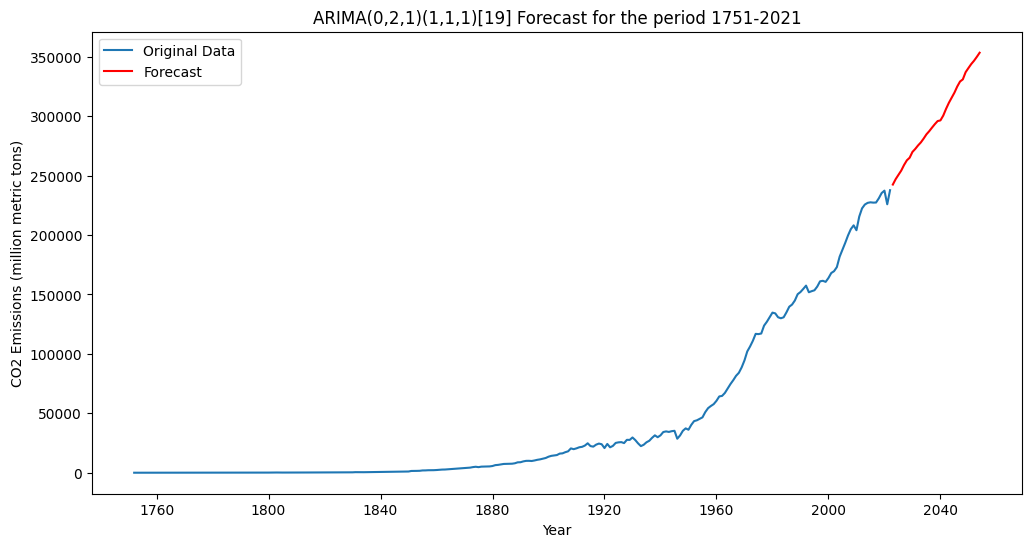

MAPE: 54.71%


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Calculate MAPE
def calculate_mape(actual, forecast):
    actual = np.nan_to_num(actual)
    forecast = np.nan_to_num(forecast)
    return (np.abs(actual - forecast) / actual).mean() * 100

# Selecting the data for the period 1751-2021
start_date = pd.to_datetime('1751', format='%Y')
end_date = pd.to_datetime('2021', format='%Y')
co2_data = df.loc[(df.index >= start_date) & (df.index <= end_date), 'co2']
co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()

# Fit the ARIMA model
model = ARIMA(co2_data, order=(0, 2, 1), seasonal_order=(1, 1, 1, 19))
model_fit = model.fit()

# Forecasting for 32 years
forecast_years = 32
forecast = model_fit.forecast(steps=forecast_years)

# Calculate the actual values for the period 1751-2021
actual_values = co2_data[-forecast_years:]

# Calculate the MAPE
mape = calculate_mape(actual_values, forecast)

# Plotting the original data and the forecasted values
plt.figure(figsize=(12, 6))
plt.plot(co2_data.index, co2_data, label='Original Data')
plt.plot(forecast.index, forecast, color='red', label='Forecast')
#plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color='gray', alpha=0.3)
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (million metric tons)')
plt.title('ARIMA(0,2,1)(1,1,1)[19] Forecast for the period 1751-2021')
plt.legend()
plt.show()

print(f"MAPE: {mape:.2f}%")


<ipython-input-53-3fd92020416b>:16: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()


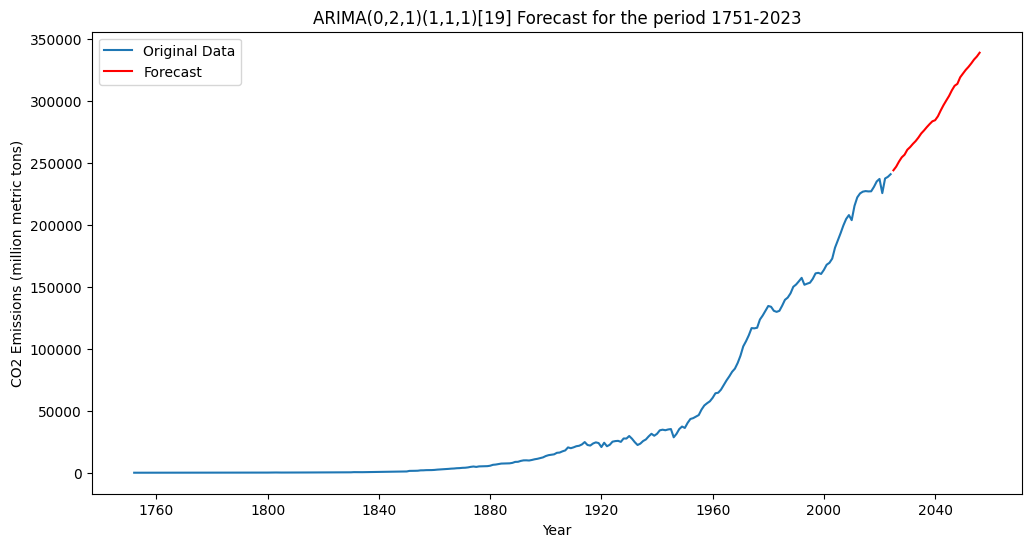

MAPE: 47.72%


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Calculate MAPE
def calculate_mape(actual, forecast):
    actual = np.nan_to_num(actual)
    forecast = np.nan_to_num(forecast)
    return (np.abs(actual - forecast) / actual).mean() * 100

# Selecting the data for the period 1751-2023
start_date = pd.to_datetime('1751', format='%Y')
end_date = pd.to_datetime('2023', format='%Y')
co2_data = df.loc[(df.index >= start_date) & (df.index <= end_date), 'co2']
co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()

# Fit the ARIMA model
model = ARIMA(co2_data, order=(0, 2, 1), seasonal_order=(1, 1, 1, 19))
model_fit = model.fit()

# Forecasting for 32 years
forecast_years = 32
forecast = model_fit.forecast(steps=forecast_years)

# Calculate the actual values for the period 1751-2023
actual_values = co2_data[-forecast_years:]

# Calculate the MAPE
mape = calculate_mape(actual_values, forecast)

# Plotting the original data and the forecasted values
plt.figure(figsize=(12, 6))
plt.plot(co2_data.index, co2_data, label='Original Data')
plt.plot(forecast.index, forecast, color='red', label='Forecast')
#plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color='gray', alpha=0.3)
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (million metric tons)')
plt.title('ARIMA(0,2,1)(1,1,1)[19] Forecast for the period 1751-2023')
plt.legend()
plt.show()

print(f"MAPE: {mape:.2f}%")


In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

# Convert 'year' column to datetime type if needed
df['year'] = pd.to_datetime(df['year'])

# Prepare the features (GDP and population) and target variable (CO2 emissions)
X = df['population']
y = df['co2']

if X.shape[0] > 0:
    # Drop rows with missing values in both X and y
    combined_data = pd.concat([X, y], axis=1).dropna()

    if combined_data.shape[0] > 0:
        # Separate X and y again
        X = combined_data['population']
        y = combined_data['co2']

        # Create an imputer to fill missing values with column means
        imputer = SimpleImputer(strategy='mean')
        X = imputer.fit_transform(X.values.reshape(-1, 1))

        # Create and train the linear regression model
        model = LinearRegression()
        model.fit(X, y)

        # Filter the DataFrame for the years 2019, 2020, 2021, and 2022
        years = [2019, 2020, 2021, 2022]
        data_years = df[df['year'].dt.year.isin(years)]

        if data_years.shape[0] > 0:
            # Prepare the features for the selected years
            X_years = data_years['population']
            X_years = imputer.transform(X_years.values.reshape(-1, 1))

            # Predict CO2 emissions for the selected years
            y_pred_years = model.predict(X_years)

            if isinstance(y_pred_years, float):
                y_pred_years = [y_pred_years]

            # Calculate the total carbon emissions for each year
            total_emissions_years = sum(y_pred_years)

            for year, total_emissions in zip(years, [total_emissions_years]):
                print(f'Total carbon emissions in {year}: {total_emissions}')
        else:
            print('No data available for the selected years.')
    else:
        print('Insufficient data after dropping missing values.')
else:
    print('No data available.')


Total carbon emissions in 2019: 505834.27500454924


In [ ]:
co2_emissions_2019 = co2_data2.loc['2019']
print("Annual CO2 emissions in 2019:", co2_emissions_2019)

Annual CO2 emissions in 2019: year_copy
2019-12-31    237289.378
Freq: YE-DEC, Name: co2, dtype: float64


In [ ]:
co2_emissions_2019 = co2_data2.loc['2019'] / 10000
print("Annual CO2 emissions in 2019 (gigatons):", co2_emissions_2019)


Annual CO2 emissions in 2019 (gigatons): year_copy
2019-12-31    23.728938
Freq: YE-DEC, Name: co2, dtype: float64


<ipython-input-57-13a4f7a7b6a7>:16: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()


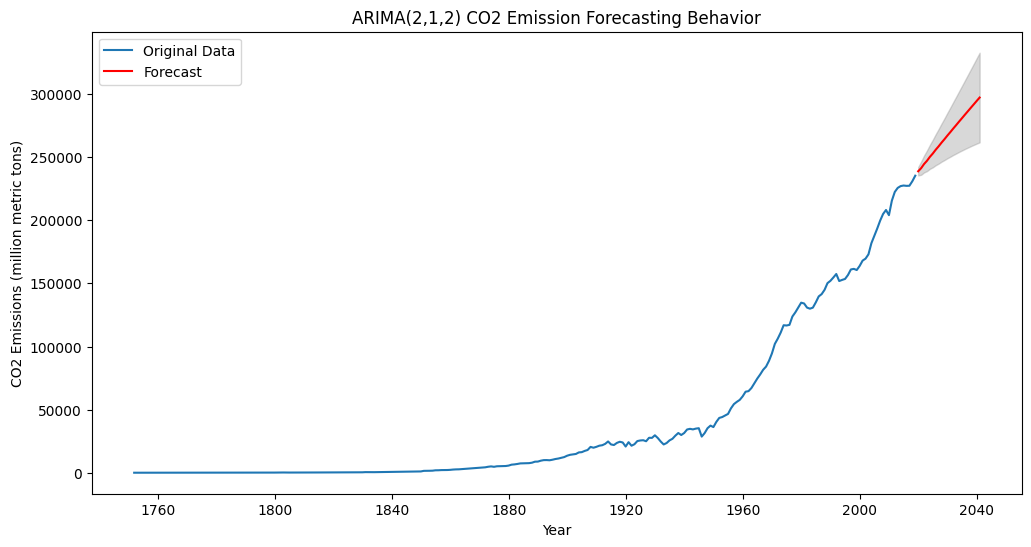

MAPE: 34.79%


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Calculate MAPE
def calculate_mape(actual, forecast):
    actual = np.nan_to_num(actual)
    forecast = np.nan_to_num(forecast)
    return (np.abs(actual - forecast) / actual).mean() * 100

# Selecting the data for the period Pre-COVID-19
start_date = pd.to_datetime('1751', format='%Y')  # Replace with the desired start date
end_date = pd.to_datetime('2018', format='%Y')  # Replace with the desired end date
co2_data = df.loc[(df.index >= start_date) & (df.index <= end_date), 'co2']
co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()

# Fit the ARIMA model
model = ARIMA(co2_data, order=(2, 1, 2))
model_fit = model.fit()

# Forecasting for the desired period
forecast_years = 2040 - end_date.year  # Replace 2040 with the desired end year
forecast = model_fit.get_forecast(steps=forecast_years)

# Calculate the actual values for the period Pre-COVID-19
actual_values = co2_data[-forecast_years:]

# Extract the forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
ci = forecast.conf_int()

# Calculate the MAPE
mape = calculate_mape(actual_values, forecast_values[-len(actual_values):])

# Plotting the original data and the forecasted values
plt.figure(figsize=(12, 6))
plt.plot(co2_data.index, co2_data, label='Original Data')
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color='gray', alpha=0.3)
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (million metric tons)')
plt.title('ARIMA(2,1,2) CO2 Emission Forecasting Behavior')
plt.legend()
plt.show()

print(f"MAPE: {mape:.2f}%")



<ipython-input-58-cca7f79a60bf>:16: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()


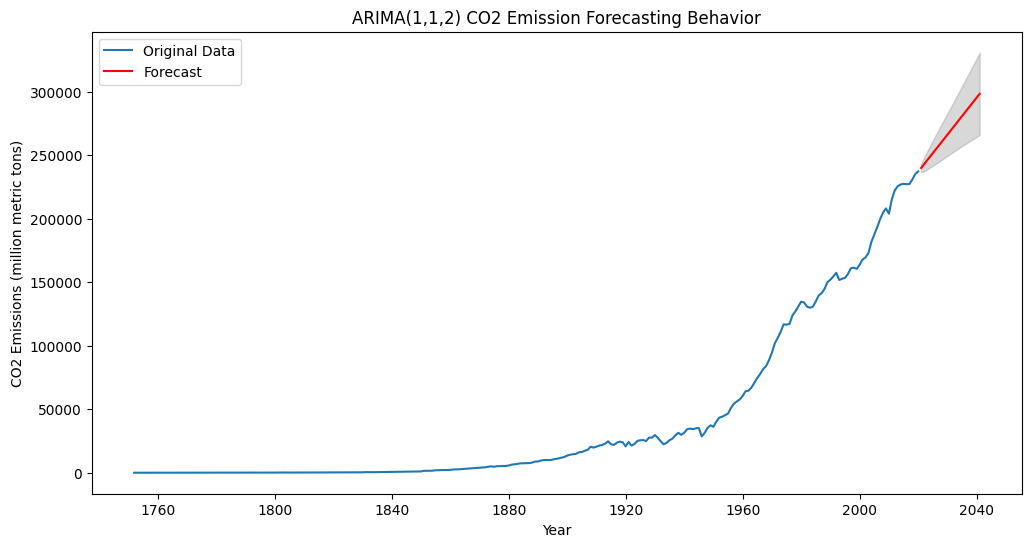

MAPE: 31.38%


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Calculate MAPE
def calculate_mape(actual, forecast):
    actual = np.nan_to_num(actual)
    forecast = np.nan_to_num(forecast)
    return (np.abs(actual - forecast) / actual).mean() * 100

# Selecting the data for the period start-COVID-19
start_date = pd.to_datetime('1751', format='%Y')  # Replace with the desired start date
end_date = pd.to_datetime('2019', format='%Y')  # Replace with the desired end date
co2_data = df.loc[(df.index >= start_date) & (df.index <= end_date), 'co2']
co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()

# Fit the ARIMA model
model = ARIMA(co2_data, order=(1, 1, 2))
model_fit = model.fit()

# Forecasting for the desired period
forecast_years = 2040 - end_date.year  # Replace 2040 with the desired end year
forecast = model_fit.get_forecast(steps=forecast_years)

# Calculate the actual values for the period Pre-COVID-19
actual_values = co2_data[-forecast_years:]

# Extract the forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
ci = forecast.conf_int()

# Calculate the MAPE
mape = calculate_mape(actual_values, forecast_values[-len(actual_values):])

# Plotting the original data and the forecasted values
plt.figure(figsize=(12, 6))
plt.plot(co2_data.index, co2_data, label='Original Data')
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color='gray', alpha=0.3)
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (million metric tons)')
plt.title('ARIMA(1,1,2) CO2 Emission Forecasting Behavior')
plt.legend()
plt.show()

print(f"MAPE: {mape:.2f}%")


<ipython-input-59-45152bcec98c>:16: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()


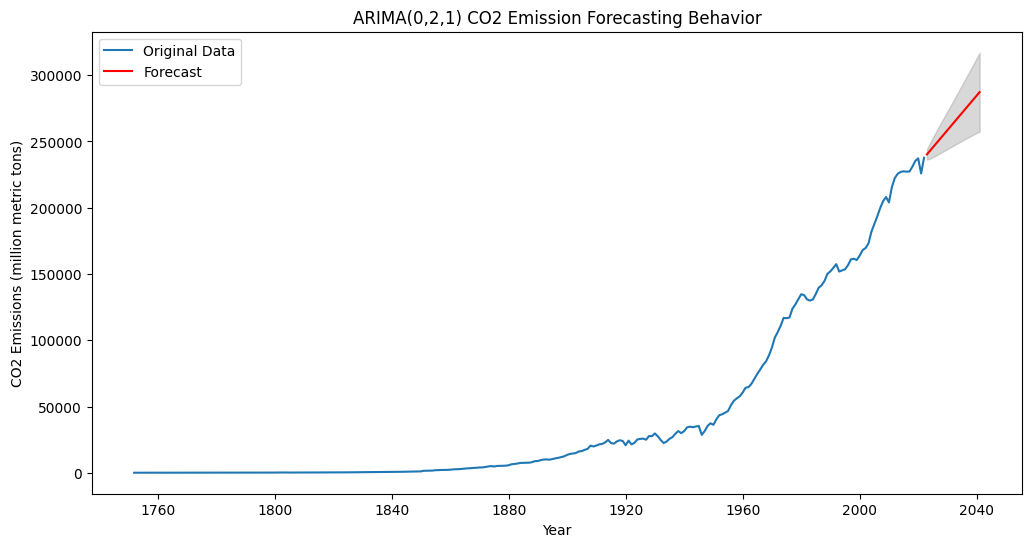

MAPE: 21.94%


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Calculate MAPE
def calculate_mape(actual, forecast):
    actual = np.nan_to_num(actual)
    forecast = np.nan_to_num(forecast)
    return (np.abs(actual - forecast) / actual).mean() * 100

# Selecting the data for the period trans-COVID-19
start_date = pd.to_datetime('1751', format='%Y')  # Replace with the desired start date
end_date = pd.to_datetime('2021', format='%Y')  # Replace with the desired end date
co2_data = df.loc[(df.index >= start_date) & (df.index <= end_date), 'co2']
co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()

# Fit the ARIMA model
model = ARIMA(co2_data, order=(0, 2, 1))
model_fit = model.fit()

# Forecasting for the desired period
forecast_years = 2040 - end_date.year  # Replace 2040 with the desired end year
forecast = model_fit.get_forecast(steps=forecast_years)

# Calculate the actual values for the period Pre-COVID-19
actual_values = co2_data[-forecast_years:]

# Extract the forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
ci = forecast.conf_int()

# Calculate the MAPE
mape = calculate_mape(actual_values, forecast_values[-len(actual_values):])

# Plotting the original data and the forecasted values
plt.figure(figsize=(12, 6))
plt.plot(co2_data.index, co2_data, label='Original Data')
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color='gray', alpha=0.3)
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (million metric tons)')
plt.title('ARIMA(0,2,1) CO2 Emission Forecasting Behavior')
plt.legend()
plt.show()

print(f"MAPE: {mape:.2f}%")


<ipython-input-60-1038f4f1c18f>:16: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()


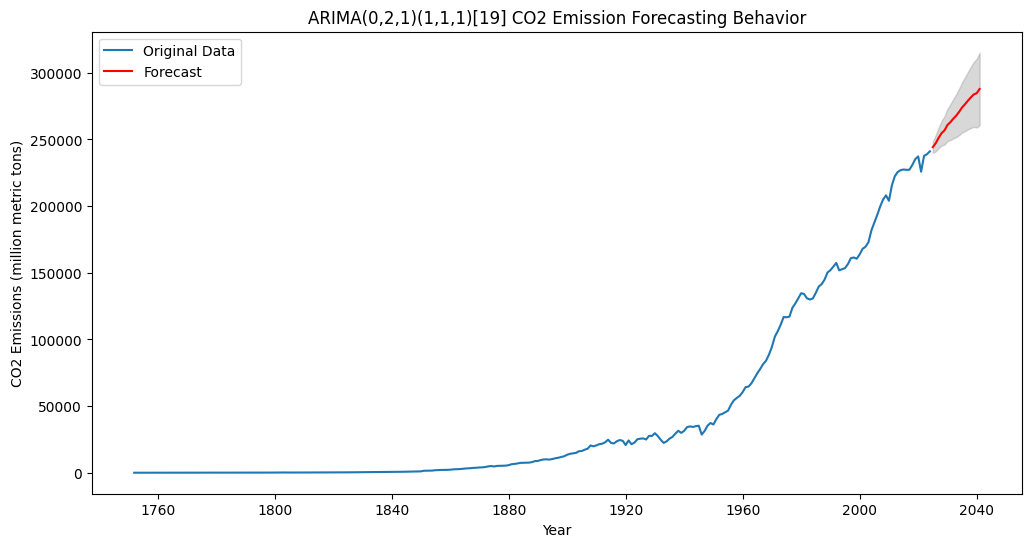

MAPE: 18.62%


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Calculate MAPE
def calculate_mape(actual, forecast):
    actual = np.nan_to_num(actual)
    forecast = np.nan_to_num(forecast)
    return (np.abs(actual - forecast) / actual).mean() * 100

# Selecting the data for the period post-COVID-19
start_date = pd.to_datetime('1751', format='%Y')  # Replace with the desired start date
end_date = pd.to_datetime('2023', format='%Y')  # Replace with the desired end date
co2_data = df.loc[(df.index >= start_date) & (df.index <= end_date), 'co2']
co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()

# Fit the ARIMA model
model = ARIMA(co2_data, order=(0, 2, 1), seasonal_order=(1, 1, 1, 19))
model_fit = model.fit()

# Forecasting for the desired period
forecast_years = 2040 - end_date.year  # Replace 2040 with the desired end year
forecast = model_fit.get_forecast(steps=forecast_years)

# Calculate the actual values for the period trans-COVID-19
actual_values = co2_data[-forecast_years:]

# Extract the forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
ci = forecast.conf_int()

# Calculate the MAPE
mape = calculate_mape(actual_values, forecast_values[-len(actual_values):])

# Plotting the original data and the forecasted values
plt.figure(figsize=(12, 6))
plt.plot(co2_data.index, co2_data, label='Original Data')
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color='gray', alpha=0.3)
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (million metric tons)')
plt.title('ARIMA(0,2,1)(1,1,1)[19] CO2 Emission Forecasting Behavior')
plt.legend()
plt.show()

print(f"MAPE: {mape:.2f}%")


<ipython-input-61-ce650f909d66>:16: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()


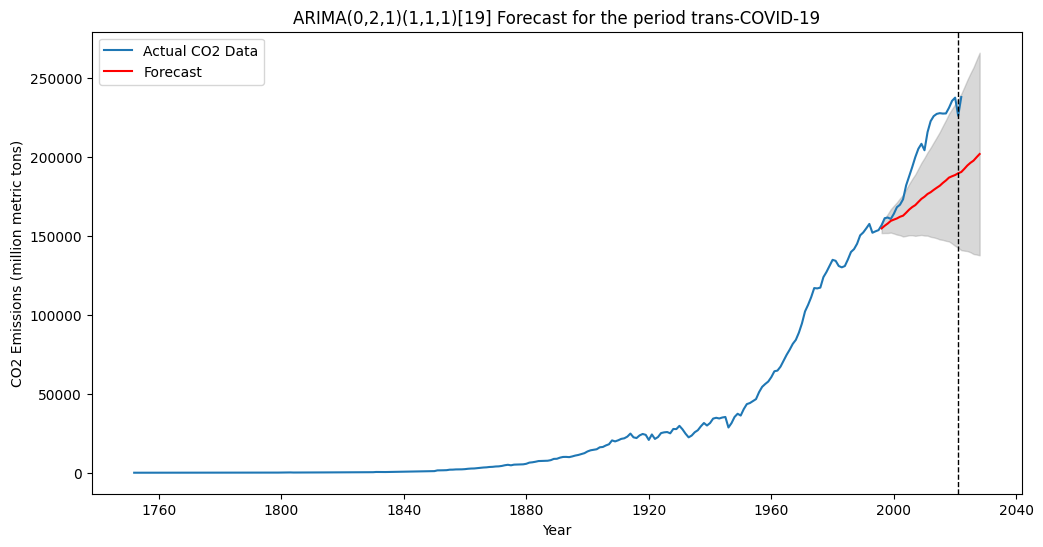

MAPE: 9.87%


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Calculate MAPE
def calculate_mape(actual, forecast):
    actual = np.nan_to_num(actual)
    forecast = np.nan_to_num(forecast)
    return (np.abs(actual - forecast) / actual).mean() * 100

# Selecting the data for the period trans-COVID-19
start_date = pd.to_datetime('1751', format='%Y')  # Replace with the desired start date
end_date = pd.to_datetime('2021', format='%Y')  # Replace with the desired end date
co2_data = df.loc[(df.index >= start_date) & (df.index <= end_date), 'co2']
co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()

# Train-test split
train_data = co2_data.loc[co2_data.index < pd.to_datetime('1995', format='%Y')]
test_data = co2_data.loc[co2_data.index >= pd.to_datetime('1995', format='%Y')]
forc= co2_data.loc[co2_data.index >= pd.to_datetime('2021', format='%Y')]
# Fit the ARIMA model using training data
model = ARIMA(train_data, order=(0, 2, 1), seasonal_order=(1, 1, 1, 19))  # Update the order and seasonal_order values as desired
model_fit = model.fit()

# Forecasting for the testing period
forecast_years = len(forc) + 32  # Extend the forecast by 32 years
forecast = model_fit.get_forecast(steps=forecast_years)

# Extract the forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
ci = forecast.conf_int()

# Plotting the actual CO2 data and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(co2_data.index, co2_data, label='Actual CO2 Data')
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color='gray', alpha=0.3)
plt.axvline(x=pd.to_datetime('2021', format='%Y'), color='black', linestyle='--', linewidth=1)
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (million metric tons)')
plt.title('ARIMA(0,2,1)(1,1,1)[19] Forecast for the period trans-COVID-19')
plt.legend()
plt.show()

# Calculate the MAPE for the testing period
mape = calculate_mape(test_data, forecast_values[-len(test_data):])

print(f"MAPE: {mape:.2f}%")


<ipython-input-62-85c2b48cd830>:16: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()


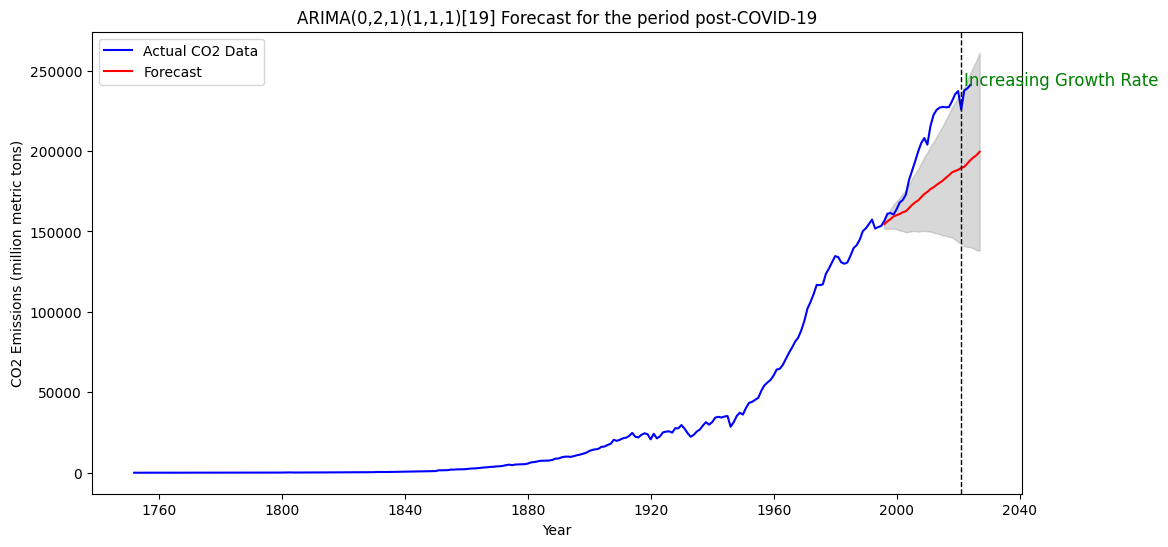

MAPE: 13.57%


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Calculate MAPE
def calculate_mape(actual, forecast):
    actual = np.nan_to_num(actual)
    forecast = np.nan_to_num(forecast)
    return (np.abs(actual - forecast) / actual).mean() * 100

# Selecting the data for the period post-COVID-19
start_date = pd.to_datetime('1751', format='%Y')  # Replace with the desired start date
end_date = pd.to_datetime('2023', format='%Y')  # Replace with the desired end date
co2_data = df.loc[(df.index >= start_date) & (df.index <= end_date), 'co2']
co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()

# Train-test split
train_data = co2_data.loc[co2_data.index < pd.to_datetime('1995', format='%Y')]
test_data = co2_data.loc[co2_data.index >= pd.to_datetime('1995', format='%Y')]

# Fit the ARIMA model using training data
model = ARIMA(train_data, order=(0, 2, 1), seasonal_order=(1, 1, 1, 19))  # Update the order and seasonal_order values as desired
model_fit = model.fit()

# Forecasting for the desired period
forecast_years = 32  # Forecast for the next 32 years
forecast = model_fit.get_forecast(steps=forecast_years)

# Extract the forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
ci = forecast.conf_int()

# Plotting the actual CO2 data and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(co2_data.index, co2_data, color='blue', label='Actual CO2 Data')
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color='gray', alpha=0.3)
plt.axvline(x=pd.to_datetime('2021', format='%Y'), color='black', linestyle='--', linewidth=1)

# Plotting the increasing growth rate information
plt.text(pd.to_datetime('2022', format='%Y'), co2_data.max(), 'Increasing Growth Rate', fontsize=12, color='green')

plt.xlabel('Year')
plt.ylabel('CO2 Emissions (million metric tons)')
plt.title('ARIMA(0,2,1)(1,1,1)[19] Forecast for the period post-COVID-19')
plt.legend()
plt.show()

# Calculate the MAPE for the testing period
mape = calculate_mape(test_data, forecast_values[:len(test_data)])

print(f"MAPE: {mape:.2f}%")


<ipython-input-63-c69a245623fc>:16: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()


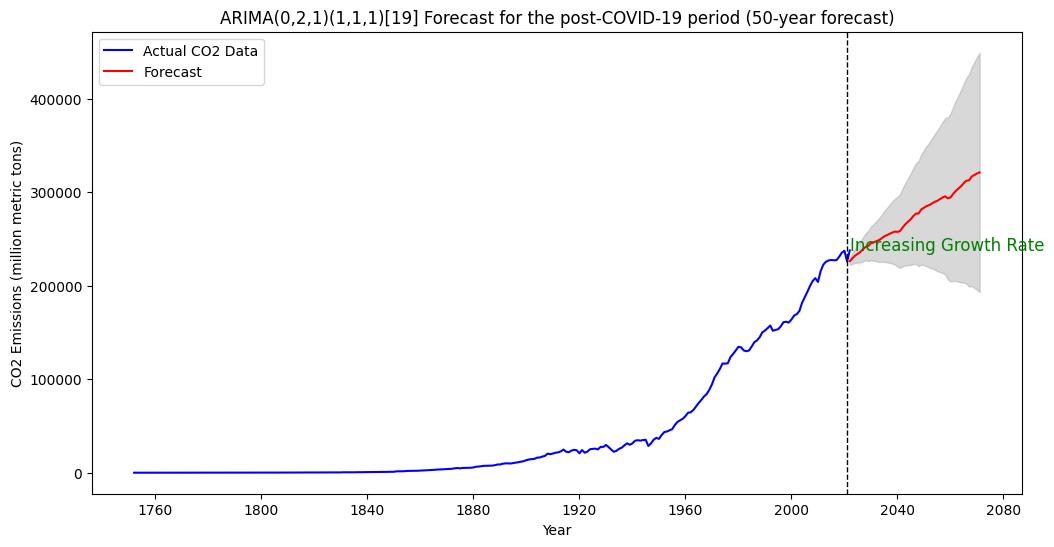

MAPE: 4.79%


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Calculate MAPE
def calculate_mape(actual, forecast):
    actual = np.nan_to_num(actual)
    forecast = np.nan_to_num(forecast)
    return (np.abs(actual - forecast) / actual).mean() * 100

# Selecting the data for the post-COVID-19 period
start_date = pd.to_datetime('1751', format='%Y')  # Replace with the desired start date
end_date = pd.to_datetime('2021', format='%Y')  # Replace with the desired end date
co2_data = df.loc[(df.index >= start_date) & (df.index <= end_date), 'co2']
co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()

# Train-test split
train_data = co2_data.loc[co2_data.index < pd.to_datetime('2021', format='%Y')]
test_data = co2_data.loc[co2_data.index >= pd.to_datetime('2021', format='%Y')]

# Fit the ARIMA model using training data
model = ARIMA(train_data, order=(0, 2, 1), seasonal_order=(1, 1, 1, 19))  # Update the order and seasonal_order values as desired
model_fit = model.fit()

# Forecasting for the desired period
forecast_years = 50  # Forecast for the next 50 years
forecast = model_fit.get_forecast(steps=forecast_years)

# Extract the forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
ci = forecast.conf_int()

# Plotting the actual CO2 data and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(co2_data.index, co2_data, color='blue', label='Actual CO2 Data')
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color='gray', alpha=0.3)
plt.axvline(x=pd.to_datetime('2021', format='%Y'), color='black', linestyle='--', linewidth=1)

# Plotting the increasing growth rate information
plt.text(pd.to_datetime('2022', format='%Y'), co2_data.max(), 'Increasing Growth Rate', fontsize=12, color='green')

plt.xlabel('Year')
plt.ylabel('CO2 Emissions (million metric tons)')
plt.title('ARIMA(0,2,1)(1,1,1)[19] Forecast for the post-COVID-19 period (50-year forecast)')
plt.legend()
plt.show()

# Calculate the MAPE for the testing period
mape = calculate_mape(test_data, forecast_values[:len(test_data)])

print(f"MAPE: {mape:.2f}%")


<ipython-input-64-9be49c914a7f>:16: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()


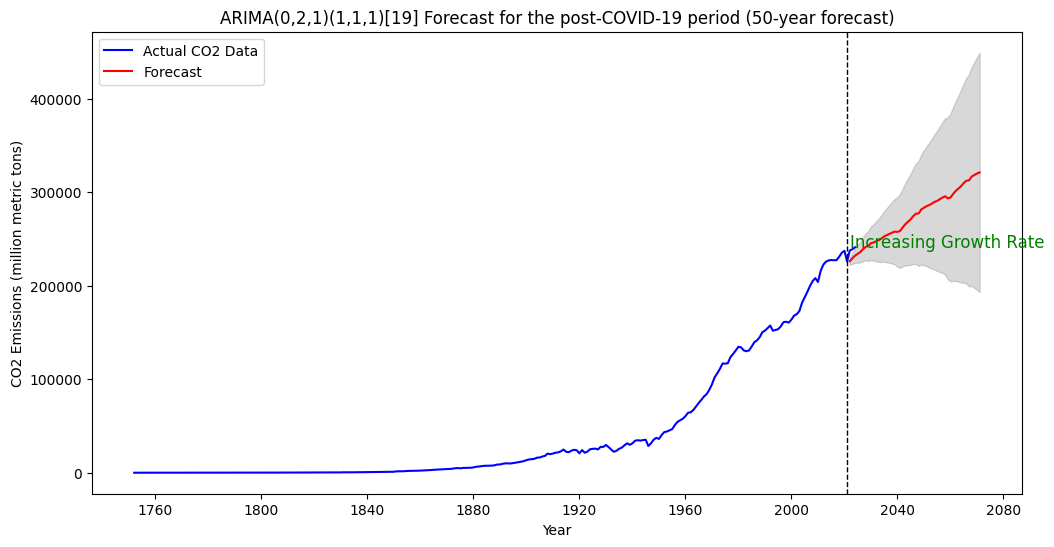

MAPE: 4.19%


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Calculate MAPE
def calculate_mape(actual, forecast):
    actual = np.nan_to_num(actual)
    forecast = np.nan_to_num(forecast)
    return (np.abs(actual - forecast) / actual).mean() * 100

# Selecting the data for the post-COVID-19 period
start_date = pd.to_datetime('1751', format='%Y')  # Replace with the desired start date
end_date = pd.to_datetime('2023', format='%Y')  # Replace with the desired end date
co2_data = df.loc[(df.index >= start_date) & (df.index <= end_date), 'co2']
co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()

# Train-test split
train_data = co2_data.loc[co2_data.index < pd.to_datetime('2021', format='%Y')]
test_data = co2_data.loc[co2_data.index >= pd.to_datetime('2021', format='%Y')]

# Fit the ARIMA model using training data
model = ARIMA(train_data, order=(0, 2, 1), seasonal_order=(1, 1, 1, 19))  # Update the order and seasonal_order values as desired
model_fit = model.fit()

# Forecasting for the desired period
forecast_years = 50  # Forecast for the next 50 years
forecast = model_fit.get_forecast(steps=forecast_years)

# Extract the forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
ci = forecast.conf_int()

# Plotting the actual CO2 data and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(co2_data.index, co2_data, color='blue', label='Actual CO2 Data')
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color='gray', alpha=0.3)
plt.axvline(x=pd.to_datetime('2021', format='%Y'), color='black', linestyle='--', linewidth=1)

# Plotting the increasing growth rate information
plt.text(pd.to_datetime('2022', format='%Y'), co2_data.max(), 'Increasing Growth Rate', fontsize=12, color='green')

plt.xlabel('Year')
plt.ylabel('CO2 Emissions (million metric tons)')
plt.title('ARIMA(0,2,1)(1,1,1)[19] Forecast for the post-COVID-19 period (50-year forecast)')
plt.legend()
plt.show()

# Calculate the MAPE for the testing period
mape = calculate_mape(test_data, forecast_values[:len(test_data)])

print(f"MAPE: {mape:.2f}%")


<ipython-input-65-c53f83688236>:18: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


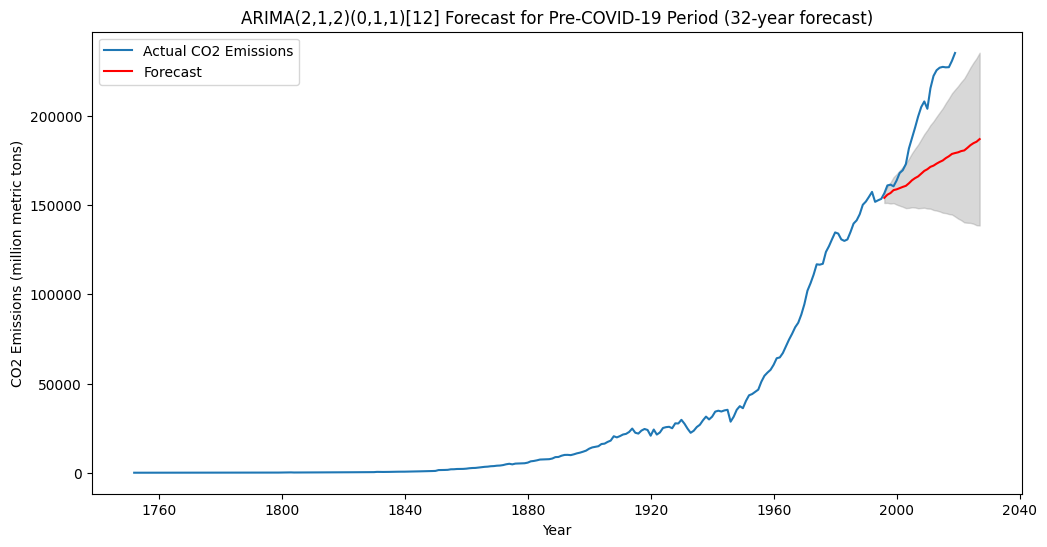

MAPE: 14.22%


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Calculate MAPE
def calculate_mape(actual, forecast):
    actual = np.nan_to_num(actual)
    forecast = np.nan_to_num(forecast)
    return (np.abs(actual - forecast) / actual).mean() * 100



# Selecting the data for the pre-COVID-19 period
start_date = pd.to_datetime('1751', format='%Y')
end_date = pd.to_datetime('2018', format='%Y')
co2_data = df.loc[(df['year'] >= start_date) & (df['year'] <= end_date), 'co2']
co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()

# Train-test split
train_data = co2_data.loc[co2_data.index < pd.to_datetime('1995', format='%Y')]
test_data = co2_data.loc[co2_data.index >= pd.to_datetime('1995', format='%Y')]

# Fit the ARIMA model using training data
model = ARIMA(train_data, order=(2, 1, 2), seasonal_order=(0, 1, 1, 19))
model_fit = model.fit()

# Forecasting for the next 32 years
forecast_years = 32
forecast = model_fit.get_forecast(steps=forecast_years)

# Extract the forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
ci = forecast.conf_int()

# Plotting the actual CO2 data and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(co2_data.index, co2_data, label='Actual CO2 Emissions')
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color='gray', alpha=0.3)
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (million metric tons)')
plt.title('ARIMA(2,1,2)(0,1,1)[12] Forecast for Pre-COVID-19 Period (32-year forecast)')
plt.legend()
plt.show()

# Calculate the MAPE for the testing period
mape = calculate_mape(test_data, forecast_values[:len(test_data)])
print(f"MAPE: {mape:.2f}%")


In [ ]:
import pandas as pd


# Convert 'year' column to datetime format
df['year'] = pd.to_datetime(df['year'], format='%Y')

# Filter the dataset for years 1918-1919
start_date = pd.to_datetime('1918', format='%Y')
end_date = pd.to_datetime('1919', format='%Y')
co2_data = df[(df['year'] >= start_date) & (df['year'] <= end_date)]

# Group by country and calculate the total carbon emissions
grouped_data = co2_data.groupby('country')['co2'].sum().reset_index()

# Sort the data by total emissions in descending order
grouped_data = grouped_data.sort_values('co2', ascending=False)

# Display the table
print(grouped_data)


                   country       co2
248                  World  6533.525
172             OECD (GCP)  6182.849
98   High-income countries  6172.343
166          North America  3475.505
167    North America (GCP)  3467.238
..                     ...       ...
118                 Kosovo     0.000
119                 Kuwait     0.000
120      Kuwaiti Oil Fires     0.000
122                   Laos     0.000
126                Lesotho     0.000

[252 rows x 2 columns]


In [ ]:
# Convert 'year' column to datetime format
df['year'] = pd.to_datetime(df['year'], format='%Y')

# Filter the dataset for the year 1919
year = pd.to_datetime('1919', format='%Y')
co2_data = df[df['year'] == year]

# Group by country and calculate the total carbon emissions
grouped_data = co2_data.groupby('country')['co2'].sum().reset_index()

# Sort the data by total emissions in descending order
grouped_data = grouped_data.sort_values('co2', ascending=False)

# Display the table
print(grouped_data)

                   country       co2
248                  World  3033.839
172             OECD (GCP)  2854.078
98   High-income countries  2842.800
166          North America  1601.085
167    North America (GCP)  1597.610
..                     ...       ...
117               Kiribati     0.000
118                 Kosovo     0.000
119                 Kuwait     0.000
120      Kuwaiti Oil Fires     0.000
126                Lesotho     0.000

[252 rows x 2 columns]


In [ ]:
import pandas as pd

# Select the data for the period 1918-2021 in the world
start_date = pd.to_datetime('1918', format='%Y')
end_date = pd.to_datetime('2021', format='%Y')
co2_data_world = df.loc[(df['year'] >= start_date) & (df['year'] <= end_date) & (df['country'] == 'World')]

# Create a table of CO2 emissions for each year between 1918 and 2021
co2_table = pd.DataFrame({'Year': co2_data_world['year'], 'CO2 Emissions': co2_data_world['co2']})

# Display the table
print(co2_table)


                 Year  CO2 Emissions
year_copy                           
1918-01-01 1918-01-01       3499.686
1919-01-01 1919-01-01       3033.839
1920-01-01 1920-01-01       3537.837
1921-01-01 1921-01-01       3106.184
1922-01-01 1922-01-01       3254.463
...               ...            ...
2017-01-01 2017-01-01      35989.898
2018-01-01 2018-01-01      36730.426
2019-01-01 2019-01-01      37104.273
2020-01-01 2020-01-01      35126.527
2021-01-01 2021-01-01      36991.734

[104 rows x 2 columns]


<ipython-input-69-5526f94e1261>:12: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


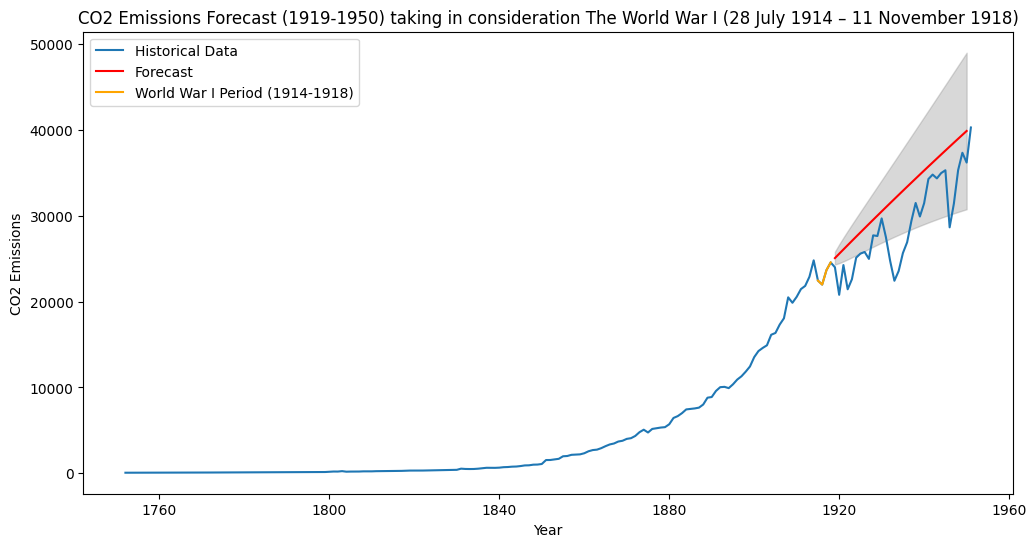

Total Forecasted CO2 Emissions: 1043513.17


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Select the data for the period 1751-1919
start_date = pd.to_datetime('1751', format='%Y')
start_date_war = pd.to_datetime('1914', format='%Y')  # Update end date for training data
end_date_train = pd.to_datetime('1918', format='%Y')  # Update end date for training data
end_date_war = pd.to_datetime('1918', format='%Y')  # Define end date for World War period
end_date_forecast = pd.to_datetime('1950', format='%Y')
co2_data = df.loc[(df['year'] >= start_date) & (df['year'] <= end_date_forecast), 'co2']
co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()

# Train the ARIMA model using the data from 1751 to 1918
train_data = co2_data.loc[(co2_data.index >= start_date) & (co2_data.index <= end_date_train)]
model = ARIMA(train_data, order=(2, 1, 2))
model_fit = model.fit()

# Get CO2 values during the World War period
war_data = co2_data.loc[(co2_data.index > start_date_war) & (co2_data.index <= end_date_war)]

# Combine training data with World War period data
train_data = pd.concat([train_data, war_data])

# Forecasting for the period 1919-2021
forecast_years = end_date_forecast.year - end_date_war.year
forecast = model_fit.get_forecast(steps=forecast_years)

# Extract the forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
ci = forecast.conf_int()

# Calculate the total forecasted CO2 emissions
total_forecast = forecast_values.sum()

# Plotting the actual data and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(co2_data.index, co2_data, label='Historical Data')
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
plt.plot(war_data.index, war_data, color='orange', label='World War I Period (1914-1918)')
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color='gray', alpha=0.3)
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.title('CO2 Emissions Forecast (1919-1950) taking in consideration The World War I (28 July 1914 – 11 November 1918)')
plt.legend()

plt.show()

print(f"Total Forecasted CO2 Emissions: {total_forecast:.2f}")
from sklearn.metrics import r2_score



<ipython-input-70-b7d3c86953dc>:13: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/d

Optimal SARIMA Parameters:
p: 0, d: 2, q: 5
P: 0, D: 0, Q: 0, S: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


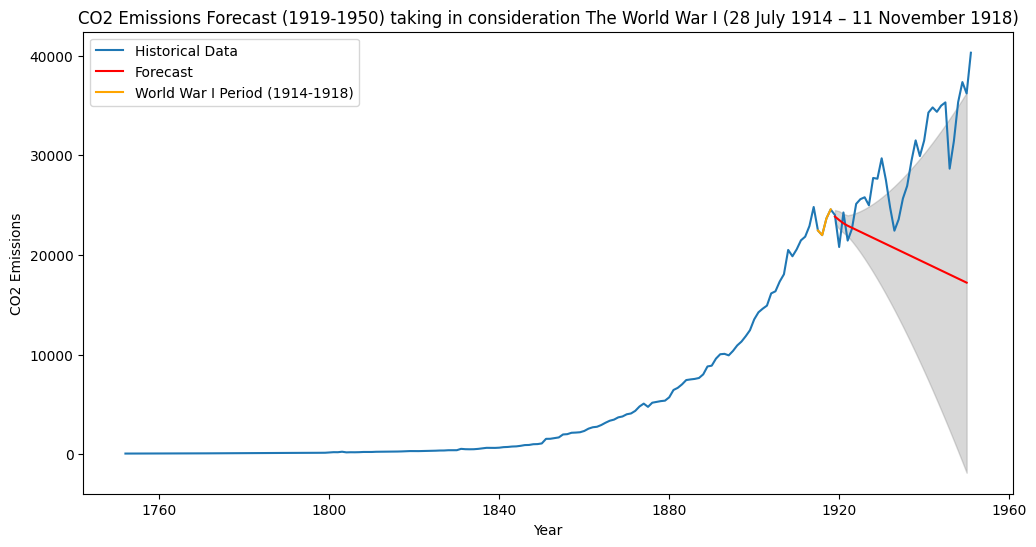

CO2 Emissions During World War I (1914-1918):
year_copy
1914-12-31    22454.920
1915-12-31    21986.036
1916-12-31    23659.557
1917-12-31    24567.970
Freq: YE-DEC, Name: co2, dtype: float64
Total Forecasted CO2 Emissions: 652643.61
Mean Absolute Percentage Error (MAPE): 27.05%


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# Select the data for the period 1751-1919
start_date = pd.to_datetime('1751', format='%Y')
start_date_war = pd.to_datetime('1914', format='%Y')
end_date_train = pd.to_datetime('1918', format='%Y')
end_date_war = pd.to_datetime('1918', format='%Y')
end_date_forecast = pd.to_datetime('1950', format='%Y')
co2_data = df.loc[(df['year'] >= start_date) & (df['year'] <= end_date_forecast), 'co2']
co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()

# Calculate optimal parameters for SARIMA using auto_arima
sarima_model = auto_arima(co2_data, seasonal=True, stepwise=True, suppress_warnings=True)

# Get optimal SARIMA parameters
optimal_p, optimal_d, optimal_q = sarima_model.order
optimal_P, optimal_D, optimal_Q, _ = sarima_model.seasonal_order


# Get optimal SARIMA parameters
optimal_p, optimal_d, optimal_q = sarima_model.order
optimal_P, optimal_D, optimal_Q, optimal_S = sarima_model.seasonal_order
# Manually specify the seasonal component based on domain knowledge
optimal_S = 1  # Change this value according to your data's seasonal pattern

print(f"Optimal SARIMA Parameters:")
print(f"p: {optimal_p}, d: {optimal_d}, q: {optimal_q}")
print(f"P: {optimal_P}, D: {optimal_D}, Q: {optimal_Q}, S: {optimal_S}")



# Train the SARIMA model using the optimal parameters
train_data = co2_data.loc[(co2_data.index >= start_date) & (co2_data.index <= end_date_train)]
sarima_model_fit = ARIMA(train_data, order=(optimal_p, optimal_d, optimal_q), seasonal_order=(optimal_P, optimal_D, optimal_Q, 12)).fit()

# Get CO2 values during the World War period
war_data = co2_data.loc[(co2_data.index > start_date_war) & (co2_data.index <= end_date_war)]

# Combine training data with World War period data
train_data = pd.concat([train_data, war_data])

# Forecasting for the period 1919-2021
forecast_years = end_date_forecast.year - end_date_war.year
forecast = sarima_model_fit.get_forecast(steps=forecast_years)

# Extract the forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
ci = forecast.conf_int()

# Calculate the total forecasted CO2 emissions
total_forecast = forecast_values.sum()

# Calculate the MAPE
mape = (abs(co2_data.loc[end_date_war:end_date_forecast] - forecast_values) / co2_data.loc[end_date_war:end_date_forecast]).mean() * 100

# Plotting the actual data and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(co2_data.index, co2_data, label='Historical Data')
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
plt.plot(war_data.index, war_data, color='orange', label='World War I Period (1914-1918)')
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color='gray', alpha=0.3)
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.title('CO2 Emissions Forecast (1919-1950) taking in consideration The World War I (28 July 1914 – 11 November 1918)')
plt.legend()
plt.savefig("ww1.eps") #save as eps
# Save the plot as a JPEG file
plt.savefig("ww1.jpeg", format='jpeg') # save as jpeg
# Save the plot as a TIFF file
plt.savefig("ww1.tiff", format='tiff')
plt.show()
print(f"CO2 Emissions During World War I (1914-1918):")
print(war_data)
print(f"Total Forecasted CO2 Emissions: {total_forecast:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")



<ipython-input-71-ab91a142085a>:13: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/d

Optimal SARIMA Parameters:
p: 0, d: 2, q: 5
P: 0, D: 0, Q: 0, S: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


CO2 Emissions During World War I (1914-1918):
year_copy
1914-12-31    22454.920
1915-12-31    21986.036
1916-12-31    23659.557
1917-12-31    24567.970
Freq: YE-DEC, Name: co2, dtype: float64
Total Forecasted CO2 Emissions: 721235.56
Mean Absolute Percentage Error (MAPE): 21.78%


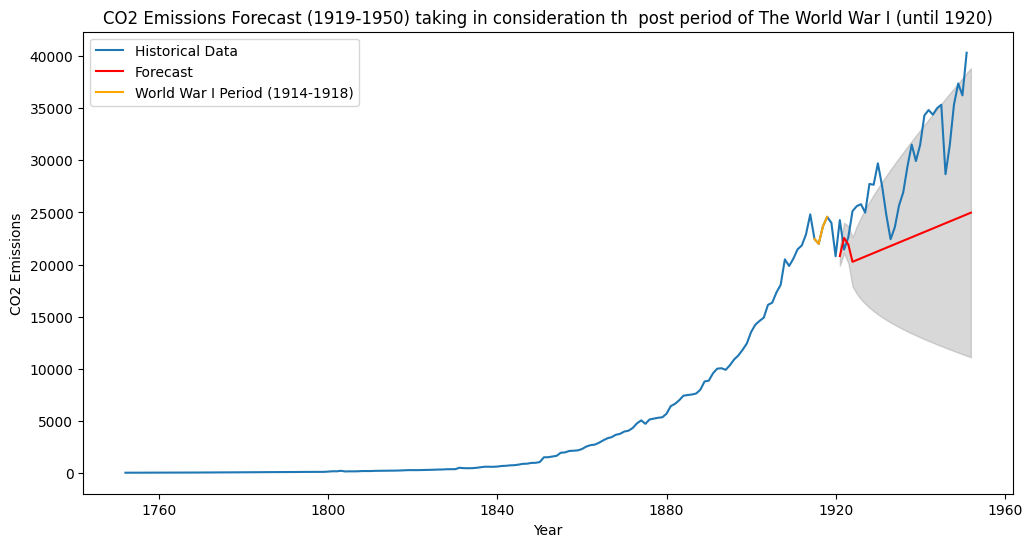

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# Select the data for the period 1751-1919
start_date = pd.to_datetime('1751', format='%Y')
start_date_war = pd.to_datetime('1914', format='%Y')
end_date_train = pd.to_datetime('1920', format='%Y')
end_date_war = pd.to_datetime('1918', format='%Y')
end_date_forecast = pd.to_datetime('1950', format='%Y')
co2_data = df.loc[(df['year'] >= start_date) & (df['year'] <= end_date_forecast), 'co2']
co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()

# Calculate optimal parameters for SARIMA using auto_arima
sarima_model = auto_arima(co2_data, seasonal=True, stepwise=True, suppress_warnings=True)

# Get optimal SARIMA parameters
optimal_p, optimal_d, optimal_q = sarima_model.order
optimal_P, optimal_D, optimal_Q, optimal_S = sarima_model.seasonal_order
# Manually specify the seasonal component based on domain knowledge
optimal_S = 1  # Change this value according to your data's seasonal pattern

print(f"Optimal SARIMA Parameters:")
print(f"p: {optimal_p}, d: {optimal_d}, q: {optimal_q}")
print(f"P: {optimal_P}, D: {optimal_D}, Q: {optimal_Q}, S: {optimal_S}")



# Train the SARIMA model using the optimal parameters
train_data = co2_data.loc[(co2_data.index >= start_date) & (co2_data.index <= end_date_train)]
sarima_model_fit = ARIMA(train_data, order=(optimal_p, optimal_d, optimal_q), seasonal_order=(optimal_P, optimal_D, optimal_Q, 12)).fit()

# Get CO2 values during the World War period
war_data = co2_data.loc[(co2_data.index > start_date_war) & (co2_data.index <= end_date_war)]

# Combine training data with World War period data
train_data = pd.concat([train_data, war_data])

# Forecasting for the period 1919-2021
forecast_years = end_date_forecast.year - end_date_war.year
forecast = sarima_model_fit.get_forecast(steps=forecast_years)

# Extract the forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
ci = forecast.conf_int()

# Calculate the total forecasted CO2 emissions
total_forecast = forecast_values.sum()

# Calculate the MAPE
mape = (abs(co2_data.loc[end_date_war:end_date_forecast] - forecast_values) / co2_data.loc[end_date_war:end_date_forecast]).mean() * 100

# Plotting the actual data and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(co2_data.index, co2_data, label='Historical Data')
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
plt.plot(war_data.index, war_data, color='orange', label='World War I Period (1914-1918)')
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color='gray', alpha=0.3)
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.title('CO2 Emissions Forecast (1919-1950) taking in consideration th  post period of The World War I (until 1920)')
plt.legend()
plt.savefig("post_ww1.eps") #save as eps
# Save the plot as a TIFF file
plt.savefig("post_ww1.tiff", format='tiff')
print(f"CO2 Emissions During World War I (1914-1918):")
print(war_data)
print(f"Total Forecasted CO2 Emissions: {total_forecast:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")



<ipython-input-72-96711b14d0a2>:19: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0791
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0250
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0148
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0076
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0024
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0040
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0040
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0022
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0025
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0015
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0040
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0022
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0021
Epoch 16/50
5/5 ━━━━━━━━━━━━━━━━━━

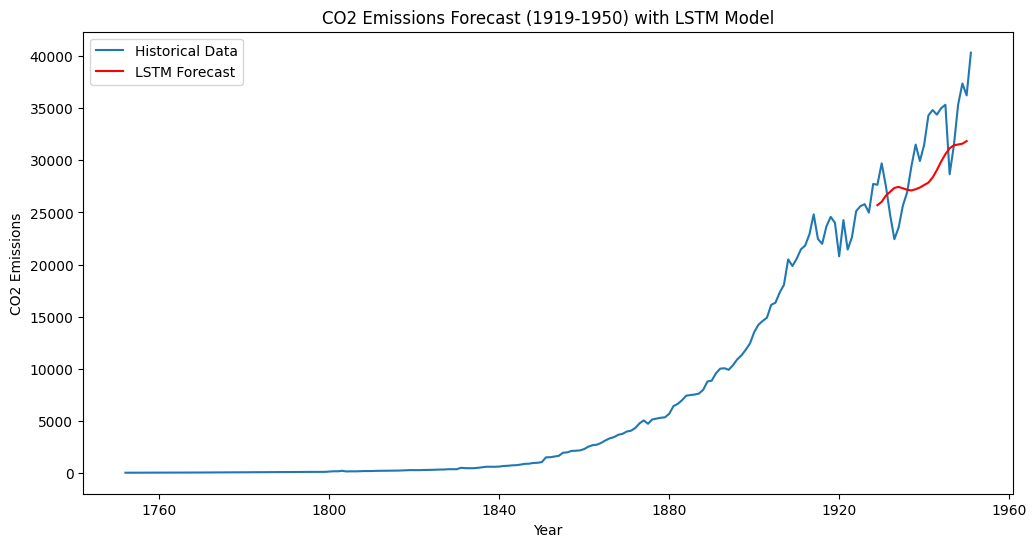

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

# Step 1: Prepare the data
start_date = pd.to_datetime('1751', format='%Y')
start_date_war = pd.to_datetime('1914', format='%Y')
end_date_train = pd.to_datetime('1920', format='%Y')
end_date_war = pd.to_datetime('1918', format='%Y')
end_date_forecast = pd.to_datetime('1950', format='%Y')

# Filter and aggregate data
co2_data = df.loc[(df['year'] >= start_date) & (df['year'] <= end_date_forecast), 'co2']
co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()

# Select training and forecast periods
train_data = co2_data.loc[(co2_data.index >= start_date) & (co2_data.index <= end_date_train)]

# Step 2: Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))

# Step 3: Create data for LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 10  # Look-back period
X_train, y_train = create_dataset(train_scaled, time_step)

# Reshaping X_train for LSTM (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

# Step 4: Build the LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer

model.compile(optimizer='adam', loss='mean_squared_error')

# Step 5: Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Step 6: Prepare the forecast data (post-WWI period)
forecast_years = end_date_forecast.year - end_date_war.year
forecast_data = co2_data.loc[(co2_data.index > end_date_war) & (co2_data.index <= end_date_forecast)]

# Scale the forecast data
forecast_scaled = scaler.transform(forecast_data.values.reshape(-1, 1))

# Step 7: Prepare the test data
X_test, _ = create_dataset(forecast_scaled, time_step)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Step 8: Make predictions
forecast_predictions = model.predict(X_test)

# Inverse transform the forecasted values
forecast_values = scaler.inverse_transform(forecast_predictions)

# Step 9: Align actual and predicted values for R² calculation
# Ensure actual_values and forecast_values have the same shape
actual_values = forecast_data.values[time_step:]  # Remove initial time steps that we can't predict
forecast_values = forecast_values[:len(actual_values)]  # Slice forecast to match the length of actual values

# Step 10: Calculate R²
r_squared = r2_score(actual_values, forecast_values)

# Print the R² value
print(f"R² for the post-World War I period (1919–1950): {r_squared:.4f}")

# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(co2_data.index, co2_data, label='Historical Data')
plt.plot(forecast_data.index[time_step:], forecast_values, color='red', label='LSTM Forecast')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.title('CO2 Emissions Forecast (1919-1950) with LSTM Model')
plt.legend()
plt.show()


<ipython-input-73-560e16b3302a>:12: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/d

Optimal SARIMA Parameters:
p: 0, d: 2, q: 5
P: 0, D: 0, Q: 0, S: 1


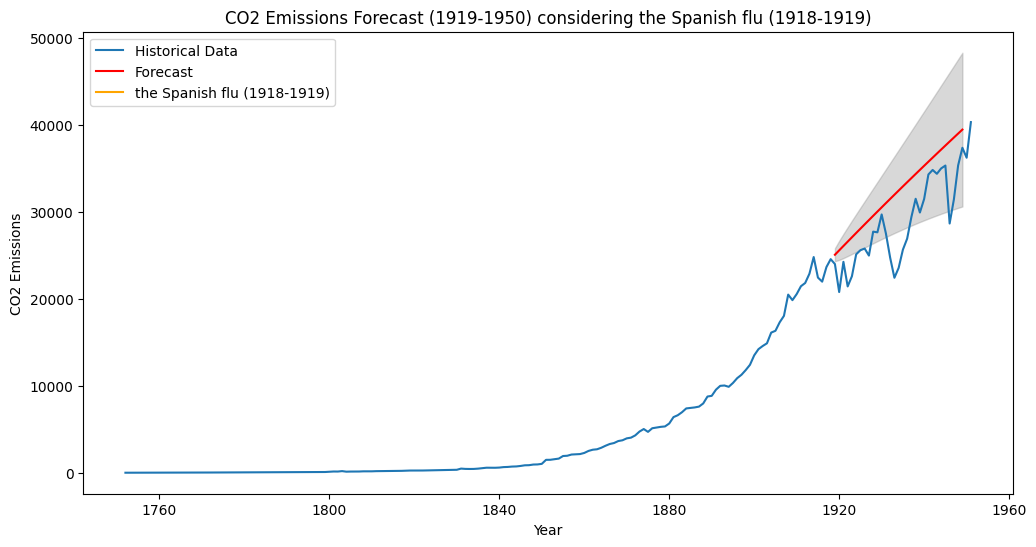

CO2 Emissions During the Spanish Flu (1918-1919):
year_copy
1918-12-31    24005.805
Freq: YE-DEC, Name: co2, dtype: float64
Total CO2 Emissions During the Spanish Flu: 24005.81
Total Forecasted CO2 Emissions: 1003622.29
Mean Absolute Percentage Error (MAPE): 4.45%


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Select the data for the period 1751-1919
start_date = pd.to_datetime('1751', format='%Y')
start_date_flu = pd.to_datetime('1918', format='%Y')
end_date_flu = pd.to_datetime('1919', format='%Y')  # Define end date for Spanish flu period
end_date_train = pd.to_datetime('1919', format='%Y')  # Update end date for training data
end_date_forecast = pd.to_datetime('1950', format='%Y')
co2_data = df.loc[(df['year'] >= start_date) & (df['year'] <= end_date_forecast), 'co2']
co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()

# Calculate optimal parameters for SARIMA using auto_arima
sarima_model = auto_arima(co2_data, seasonal=True, stepwise=True, suppress_warnings=True)

# Get optimal SARIMA parameters
optimal_p, optimal_d, optimal_q = sarima_model.order
optimal_P, optimal_D, optimal_Q, optimal_S = sarima_model.seasonal_order
# Manually specify the seasonal component based on domain knowledge
optimal_S = 1  # Change this value according to your data's seasonal pattern

print(f"Optimal SARIMA Parameters:")
print(f"p: {optimal_p}, d: {optimal_d}, q: {optimal_q}")
print(f"P: {optimal_P}, D: {optimal_D}, Q: {optimal_Q}, S: {optimal_S}")

# Train the SARIMA model using the optimal parameters
train_data = co2_data.loc[(co2_data.index >= start_date) & (co2_data.index <= end_date_train)]
sarima_model_fit = ARIMA(train_data, order=(optimal_p, optimal_d, optimal_q), seasonal_order=(optimal_P, optimal_D, optimal_Q, 12)).fit()

# Get CO2 values during the Spanish flu period
flu_data = co2_data.loc[(co2_data.index > start_date_flu) & (co2_data.index <= end_date_flu)]

# Combine training data with Spanish flu period data
train_data = pd.concat([train_data, flu_data])

# Forecasting for the period 1919-2021
forecast_years = end_date_forecast.year - end_date_flu.year
forecast = model_fit.get_forecast(steps=forecast_years)

# Extract the forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
ci = forecast.conf_int()

# Calculate the total forecasted CO2 emissions
total_forecast = forecast_values.sum()
# Calculate CO2 emissions during the Spanish flu period
co2_emissions_during_flu = flu_data.sum()
# Plotting the actual data and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(co2_data.index, co2_data, label='Historical Data')
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
plt.plot(flu_data.index, flu_data, color='orange', label='the Spanish flu (1918-1919)')
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color='gray', alpha=0.3)
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.title('CO2 Emissions Forecast (1919-1950) considering the Spanish flu (1918-1919)')
plt.legend()
plt.savefig("spanishflu.eps") #save as eps
# Save the plot as a TIFF file
plt.savefig("spanishflu.tiff", format='tiff')
plt.show()
print(f"CO2 Emissions During the Spanish Flu (1918-1919):")
print(flu_data)
print(f"Total CO2 Emissions During the Spanish Flu: {co2_emissions_during_flu:.2f}")
print(f"Total Forecasted CO2 Emissions: {total_forecast:.2f}")
# Calculate the MAPE
mape = (abs(co2_data.loc[start_date_flu:end_date_flu] - forecast_values.loc[start_date_flu:end_date_flu]) / co2_data.loc[start_date_flu:end_date_flu]).mean() * 100

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")



<ipython-input-74-6243147b6fe2>:12: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/d

Optimal SARIMA Parameters:
p: 0, d: 2, q: 5
P: 0, D: 0, Q: 0, S: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


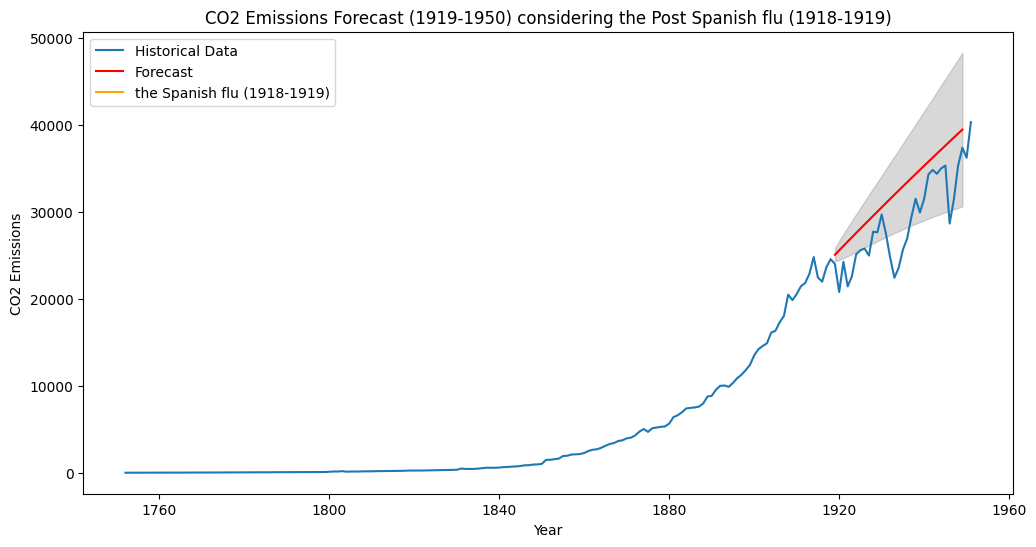

CO2 Emissions During the Spanish Flu (1918-1919):
year_copy
1918-12-31    24005.805
Freq: YE-DEC, Name: co2, dtype: float64
Total CO2 Emissions During the Spanish Flu: 24005.81
Total Forecasted CO2 Emissions: 1003622.29
Mean Absolute Percentage Error (MAPE): 4.45%


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Select the data for the period 1751-1919
start_date = pd.to_datetime('1751', format='%Y')
start_date_flu = pd.to_datetime('1918', format='%Y')
end_date_flu = pd.to_datetime('1919', format='%Y')  # Define end date for Spanish flu period
end_date_train = pd.to_datetime('1921', format='%Y')  # Update end date for training data
end_date_forecast = pd.to_datetime('1950', format='%Y')
co2_data = df.loc[(df['year'] >= start_date) & (df['year'] <= end_date_forecast), 'co2']
co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()

# Calculate optimal parameters for SARIMA using auto_arima
sarima_model = auto_arima(co2_data, seasonal=True, stepwise=True, suppress_warnings=True)

# Get optimal SARIMA parameters
optimal_p, optimal_d, optimal_q = sarima_model.order
optimal_P, optimal_D, optimal_Q, optimal_S = sarima_model.seasonal_order
# Manually specify the seasonal component based on domain knowledge
optimal_S = 1  # Change this value according to your data's seasonal pattern

print(f"Optimal SARIMA Parameters:")
print(f"p: {optimal_p}, d: {optimal_d}, q: {optimal_q}")
print(f"P: {optimal_P}, D: {optimal_D}, Q: {optimal_Q}, S: {optimal_S}")

# Train the SARIMA model using the optimal parameters
train_data = co2_data.loc[(co2_data.index >= start_date) & (co2_data.index <= end_date_train)]
sarima_model_fit = ARIMA(train_data, order=(optimal_p, optimal_d, optimal_q), seasonal_order=(optimal_P, optimal_D, optimal_Q, 12)).fit()

# Get CO2 values during the Spanish flu period
flu_data = co2_data.loc[(co2_data.index > start_date_flu) & (co2_data.index <= end_date_flu)]

# Combine training data with Spanish flu period data
train_data = pd.concat([train_data, flu_data])

# Forecasting for the period 1919-2021
forecast_years = end_date_forecast.year - end_date_flu.year
forecast = model_fit.get_forecast(steps=forecast_years)

# Extract the forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
ci = forecast.conf_int()

# Calculate the total forecasted CO2 emissions
total_forecast = forecast_values.sum()
# Calculate CO2 emissions during the Spanish flu period
co2_emissions_during_flu = flu_data.sum()
# Plotting the actual data and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(co2_data.index, co2_data, label='Historical Data')
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
plt.plot(flu_data.index, flu_data, color='orange', label='the Spanish flu (1918-1919)')
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color='gray', alpha=0.3)
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.title('CO2 Emissions Forecast (1919-1950) considering the Post Spanish flu (1918-1919)')
plt.legend()
plt.show()
print(f"CO2 Emissions During the Spanish Flu (1918-1919):")
print(flu_data)
print(f"Total CO2 Emissions During the Spanish Flu: {co2_emissions_during_flu:.2f}")
print(f"Total Forecasted CO2 Emissions: {total_forecast:.2f}")
# Calculate the MAPE
mape = (abs(co2_data.loc[start_date_flu:end_date_flu] - forecast_values.loc[start_date_flu:end_date_flu]) / co2_data.loc[start_date_flu:end_date_flu]).mean() * 100

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")



<ipython-input-75-fc711c273e52>:13: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/d

Optimal SARIMA Parameters:
p: 0, d: 2, q: 5
P: 0, D: 0, Q: 0, S: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


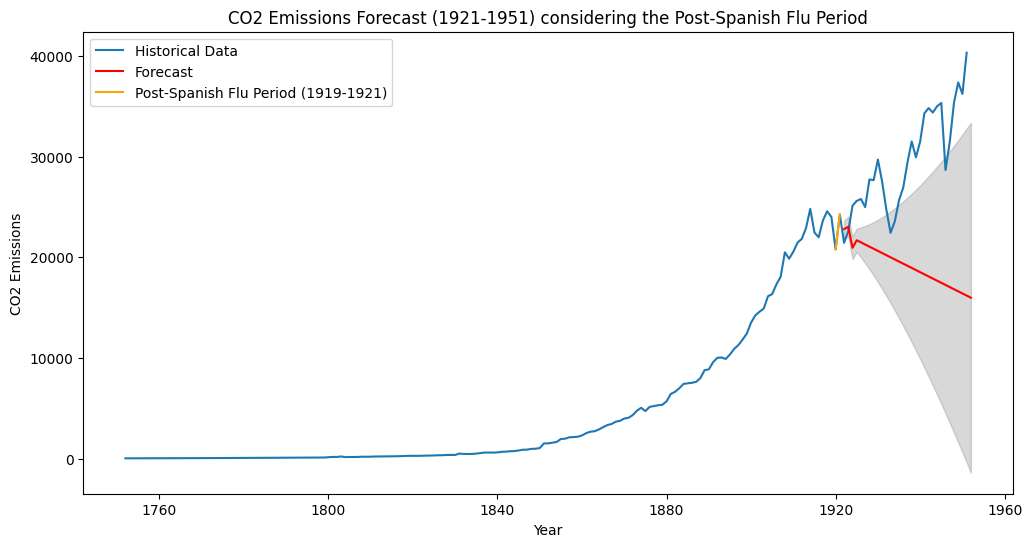

CO2 Emissions During the Post-Spanish Flu Period (1919-1921):
year_copy
1919-12-31    20795.157
1920-12-31    24260.857
Freq: YE-DEC, Name: co2, dtype: float64
Total Forecasted CO2 Emissions: 594345.12
Mean Absolute Percentage Error (MAPE): 31.63%
ADF Statistic: 3.8898073993323967
p-value: 1.0


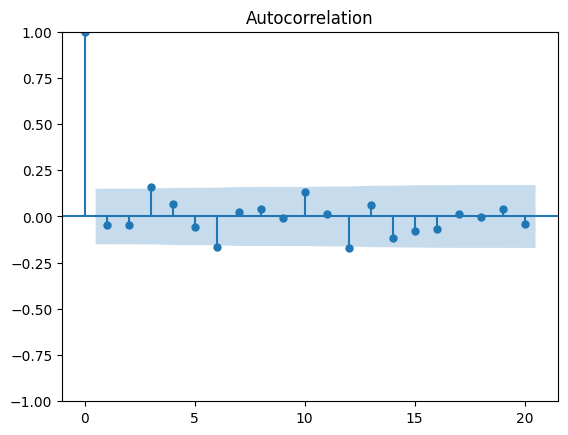

ARCH Statistic: 107.25505119401042
p-value: 1.9062965353622507e-18
Jarque-Bera Statistic: 2124.6302489248164
p-value: 0.0


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# Select the data for the period 1751-1919
start_date = pd.to_datetime('1751', format='%Y')
start_date_flu = pd.to_datetime('1918', format='%Y')
end_date_train = pd.to_datetime('1921', format='%Y')
end_date_flu = pd.to_datetime('1919', format='%Y')
end_date_forecast = pd.to_datetime('1950', format='%Y')
co2_data = df.loc[(df['year'] >= start_date) & (df['year'] <= end_date_forecast), 'co2']
co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()

# Calculate optimal parameters for SARIMA using auto_arima
sarima_model = auto_arima(co2_data, seasonal=True, stepwise=True, suppress_warnings=True)

# Get optimal SARIMA parameters
optimal_p, optimal_d, optimal_q = sarima_model.order
optimal_P, optimal_D, optimal_Q, optimal_S = sarima_model.seasonal_order
# Manually specify the seasonal component based on domain knowledge
optimal_S = 1  # Change this value according to your data's seasonal pattern

print(f"Optimal SARIMA Parameters:")
print(f"p: {optimal_p}, d: {optimal_d}, q: {optimal_q}")
print(f"P: {optimal_P}, D: {optimal_D}, Q: {optimal_Q}, S: {optimal_S}")

# Train the SARIMA model using the optimal parameters
train_data = co2_data.loc[(co2_data.index >= start_date) & (co2_data.index <= end_date_train)]
sarima_model_fit = ARIMA(train_data, order=(optimal_p, optimal_d, optimal_q), seasonal_order=(optimal_P, optimal_D, optimal_Q, 12)).fit()

# Get CO2 values during the post-Spanish Flu period
post_flu_data = co2_data.loc[(co2_data.index > end_date_flu) & (co2_data.index <= end_date_train)]

# Combine training data with post-Spanish Flu period data
train_data = pd.concat([train_data, post_flu_data])

# Forecasting for the period 1920-2021
forecast_years = end_date_forecast.year - end_date_flu.year
forecast = sarima_model_fit.get_forecast(steps=forecast_years)

# Extract the forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
ci = forecast.conf_int()

# Calculate the total forecasted CO2 emissions
total_forecast = forecast_values.sum()

# Calculate the MAPE
mape_data = co2_data.loc[end_date_flu:end_date_forecast]
mape_forecast = forecast_values.loc[end_date_flu:end_date_forecast]
mape = (abs(mape_data - mape_forecast) / mape_data).mean() * 100

# Plotting the actual data and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(co2_data.index, co2_data, label='Historical Data')
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
plt.plot(post_flu_data.index, post_flu_data, color='orange', label='Post-Spanish Flu Period (1919-1921)')
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color='gray', alpha=0.3)
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.title('CO2 Emissions Forecast (1921-1951) considering the Post-Spanish Flu Period')
plt.legend()
plt.savefig("post_spanishflu.eps") #save as eps
# Save the plot as a TIFF file
plt.savefig("post_spanishflu.tiff", format='tiff')
plt.show()

print(f"CO2 Emissions During the Post-Spanish Flu Period (1919-1921):")
print(post_flu_data)
print(f"Total Forecasted CO2 Emissions: {total_forecast:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
adf_test_result = adfuller(train_data)
print("ADF Statistic:", adf_test_result[0])
print("p-value:", adf_test_result[1])
from statsmodels.graphics.tsaplots import plot_acf

# Plot ACF for residuals
plot_acf(sarima_model_fit.resid, lags=20)
plt.show()

from statsmodels.stats.diagnostic import het_arch

# Perform ARCH test for heteroskedasticity
het_arch_test_result = het_arch(sarima_model_fit.resid)
print("ARCH Statistic:", het_arch_test_result[0])
print("p-value:", het_arch_test_result[1])

from scipy.stats import jarque_bera

# Perform Jarque-Bera test for normality
jarque_bera_test_result = jarque_bera(sarima_model_fit.resid)
print("Jarque-Bera Statistic:", jarque_bera_test_result[0])
print("p-value:", jarque_bera_test_result[1])


<ipython-input-76-e35a16c259b5>:11: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()


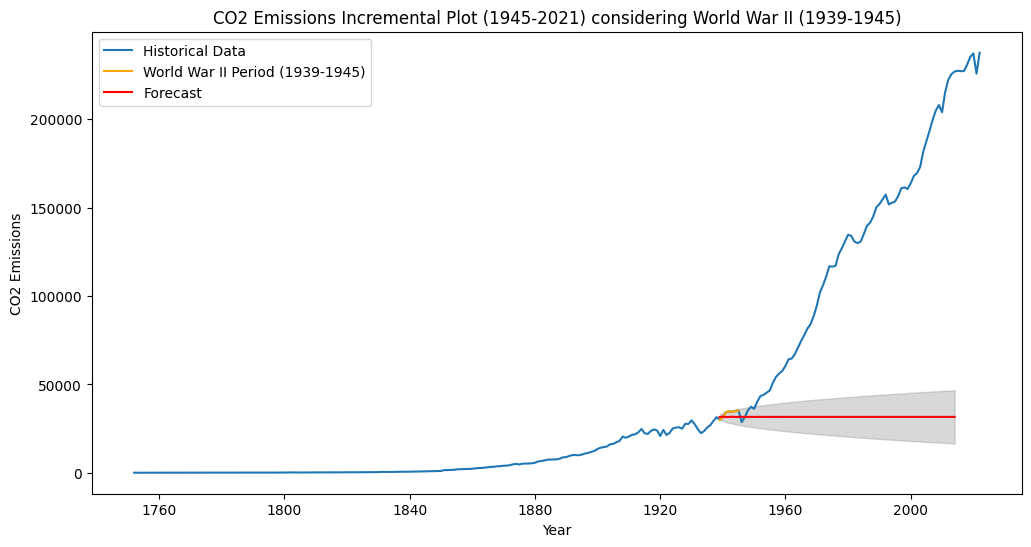

Total Forecasted CO2 Emissions: 2405114.65


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Select the data for the period 1751-1945
start_date = pd.to_datetime('1751', format='%Y')
end_date_train = pd.to_datetime('1938', format='%Y')  # Update end date for training data
end_date_war = pd.to_datetime('1945', format='%Y')  # Define end date for World War II period
end_date_forecast = pd.to_datetime('2021', format='%Y')
co2_data = df.loc[(df['year'] >= start_date) & (df['year'] <= end_date_forecast), 'co2']
co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()

# Train the ARIMA model using the data from 1751 to 1938
train_data = co2_data.loc[(co2_data.index >= start_date) & (co2_data.index <= end_date_train)]
model = ARIMA(train_data, order=(2, 1, 2))
model_fit = model.fit()

# Get CO2 values during the World War II period
war_data = co2_data.loc[(co2_data.index > end_date_train) & (co2_data.index <= end_date_war)]

# Combine training data with World War II period data
train_data = pd.concat([train_data, war_data])

# Forecasting for the period 1945-2021
forecast_years = end_date_forecast.year - end_date_war.year
forecast = model_fit.get_forecast(steps=forecast_years)

# Extract the forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
ci = forecast.conf_int()

# Calculate the total forecasted CO2 emissions
total_forecast = forecast_values.sum()

# Plotting the incremental plot for World War II period
plt.figure(figsize=(12, 6))
plt.plot(co2_data.index, co2_data, label='Historical Data')
plt.plot(war_data.index, war_data, color='orange', label='World War II Period (1939-1945)')
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color='gray', alpha=0.3)
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.title('CO2 Emissions Incremental Plot (1945-2021) considering World War II (1939-1945)')
plt.legend()
plt.show()

print(f"Total Forecasted CO2 Emissions: {total_forecast:.2f}")


<ipython-input-77-dbafb8a1ac84>:12: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/d

Optimal ARIMA Parameters: p = 0, d = 2, q = 1


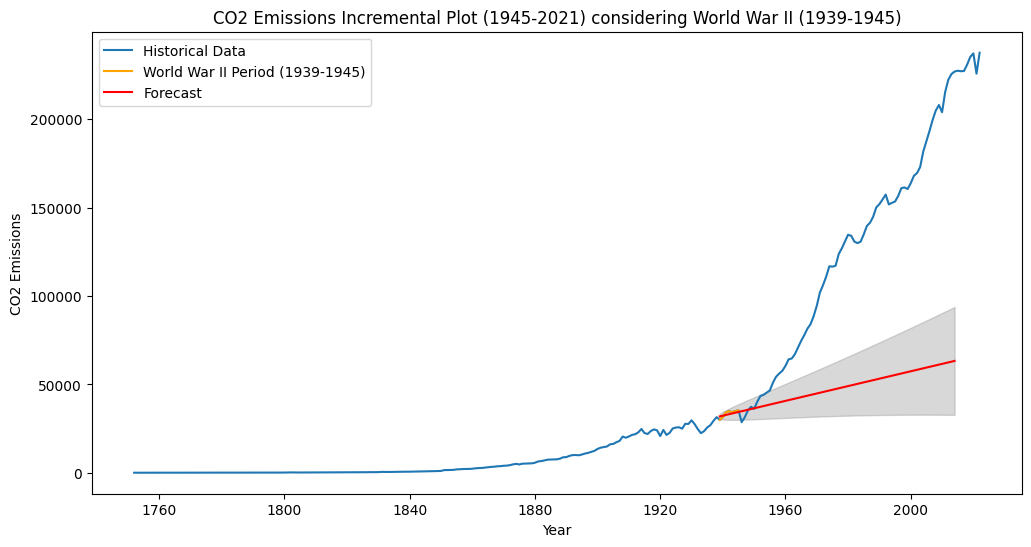

Total Forecasted CO2 Emissions: 3618283.83


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

# Select the data for the period 1751-1945
start_date = pd.to_datetime('1751', format='%Y')
end_date_train = pd.to_datetime('1938', format='%Y')  # Update end date for training data
end_date_war = pd.to_datetime('1945', format='%Y')  # Define end date for World War II period
end_date_forecast = pd.to_datetime('2021', format='%Y')
co2_data = df.loc[(df['year'] >= start_date) & (df['year'] <= end_date_forecast), 'co2']
co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()

# Train the ARIMA model using the data from 1751 to 1938
train_data = co2_data.loc[(co2_data.index >= start_date) & (co2_data.index <= end_date_train)]

# Use auto_arima to find the optimal parameters
model = auto_arima(train_data, seasonal=False, stepwise=True)
# Print the optimal values of p, d, and q
print(f"Optimal ARIMA Parameters: p = {model.order[0]}, d = {model.order[1]}, q = {model.order[2]}")

# Fit the ARIMA model with the optimal parameters
model_fit = ARIMA(train_data, order=model.order).fit()

# Get CO2 values during the World War II period
war_data = co2_data.loc[(co2_data.index > end_date_train) & (co2_data.index <= end_date_war)]

# Combine training data with World War II period data
train_data = pd.concat([train_data, war_data])

# Forecasting for the period 1945-2021
forecast_years = end_date_forecast.year - end_date_war.year
forecast = model_fit.get_forecast(steps=forecast_years)

# Extract the forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
ci = forecast.conf_int()

# Calculate the total forecasted CO2 emissions
total_forecast = forecast_values.sum()

# Plotting the incremental plot for World War II period
plt.figure(figsize=(12, 6))
plt.plot(co2_data.index, co2_data, label='Historical Data')
plt.plot(war_data.index, war_data, color='orange', label='World War II Period (1939-1945)')
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color='gray', alpha=0.3)
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.title('CO2 Emissions Incremental Plot (1945-2021) considering World War II (1939-1945)')
plt.legend()
plt.show()

print(f"Total Forecasted CO2 Emissions: {total_forecast:.2f}")


<ipython-input-78-a75c9748c950>:13: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/d

Optimal SARIMA Parameters:
p: 0, d: 2, q: 1
P: 0, D: 0, Q: 0, S: 1


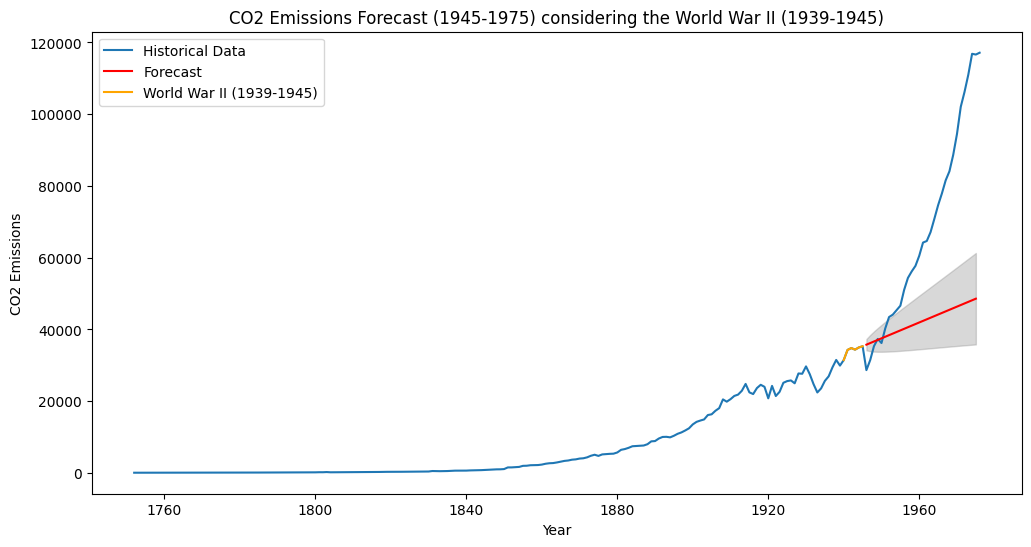

CO2 Emissions During World War II (1939-1945):
year_copy
1939-12-31    31476.906
1940-12-31    34287.666
1941-12-31    34806.538
1942-12-31    34365.102
1943-12-31    34982.579
1944-12-31    35312.390
Freq: YE-DEC, Name: co2, dtype: float64
Total Forecasted CO2 Emissions: 1264898.73
Mean Absolute Percentage Error (MAPE): 31.23%


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# Select the data for the period 1751-1919
start_date = pd.to_datetime('1751', format='%Y')
start_date_ww2 = pd.to_datetime('1939', format='%Y')
end_date_train = pd.to_datetime('1945', format='%Y')
end_date_ww2 = pd.to_datetime('1945', format='%Y')
end_date_forecast = pd.to_datetime('1975', format='%Y')
co2_data = df.loc[(df['year'] >= start_date) & (df['year'] <= end_date_forecast), 'co2']
co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()

# Calculate optimal parameters for SARIMA using auto_arima
sarima_model = auto_arima(co2_data, seasonal=True, stepwise=True, suppress_warnings=True)

# Get optimal SARIMA parameters
optimal_p, optimal_d, optimal_q = sarima_model.order
optimal_P, optimal_D, optimal_Q, optimal_S = sarima_model.seasonal_order
# Manually specify the seasonal component based on domain knowledge
optimal_S = 1  # Change this value according to your data's seasonal pattern

print(f"Optimal SARIMA Parameters:")
print(f"p: {optimal_p}, d: {optimal_d}, q: {optimal_q}")
print(f"P: {optimal_P}, D: {optimal_D}, Q: {optimal_Q}, S: {optimal_S}")

# Train the SARIMA model using the optimal parameters
train_data = co2_data.loc[(co2_data.index >= start_date) & (co2_data.index <= end_date_train)]
sarima_model_fit = ARIMA(train_data, order=(optimal_p, optimal_d, optimal_q), seasonal_order=(optimal_P, optimal_D, optimal_Q, 12)).fit()

# Get CO2 values during the World War II period
ww2_data = co2_data.loc[(co2_data.index > start_date_ww2) & (co2_data.index <= end_date_ww2)]

# Combine training data with World War II period data
train_data = pd.concat([train_data, ww2_data])

# Forecasting for the period 1946-1975
forecast_years = end_date_forecast.year - end_date_ww2.year
forecast = sarima_model_fit.get_forecast(steps=forecast_years)

# Extract the forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
ci = forecast.conf_int()

# Calculate the total forecasted CO2 emissions
total_forecast = forecast_values.sum()

# Calculate the MAPE
mape_data = co2_data.loc[end_date_ww2:end_date_forecast]
mape_forecast = forecast_values.loc[end_date_ww2:end_date_forecast]
mape = (abs(mape_data - mape_forecast) / mape_data).mean() * 100

# Plotting the actual data and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(co2_data.index, co2_data, label='Historical Data')
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
plt.plot(ww2_data.index, ww2_data, color='orange', label='World War II (1939-1945)')
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color='gray', alpha=0.3)
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.title('CO2 Emissions Forecast (1945-1975) considering the World War II (1939-1945)')
plt.legend()
plt.savefig("WWII.eps") #save as eps
# Save the plot as a TIFF file
plt.savefig("WWII.tiff", format='tiff')
plt.show()

print(f"CO2 Emissions During World War II (1939-1945):")
print(ww2_data)
print(f"Total Forecasted CO2 Emissions: {total_forecast:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


<ipython-input-79-11b5de12777c>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/di

Optimal SARIMA Parameters:
p: 2, d: 2, q: 1
P: 0, D: 0, Q: 0, S: 1


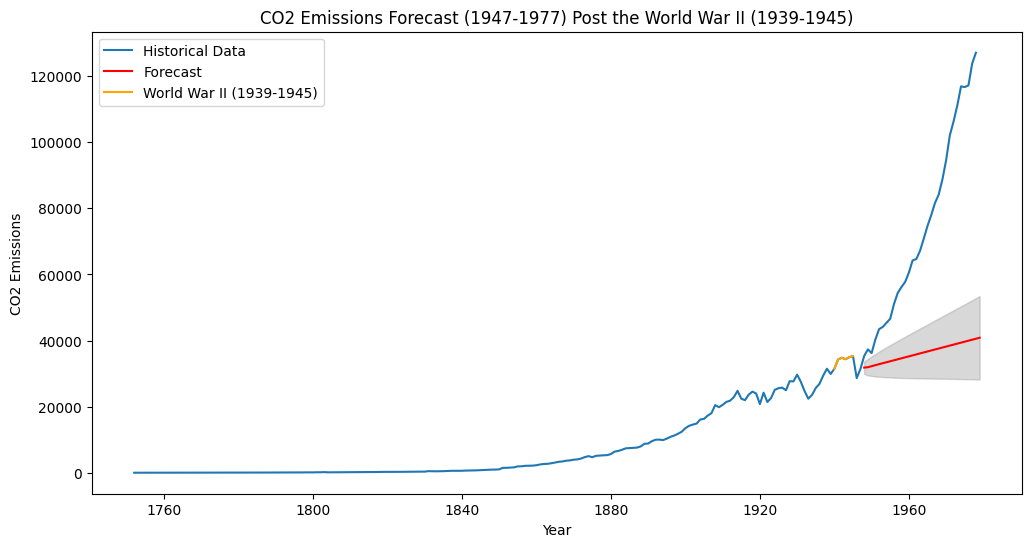

CO2 Emissions During World War II (1939-1945):
year_copy
1939-12-31    31476.906
1940-12-31    34287.666
1941-12-31    34806.538
1942-12-31    34365.102
1943-12-31    34982.579
1944-12-31    35312.390
Freq: YE-DEC, Name: co2, dtype: float64
Total Forecasted CO2 Emissions: 1160620.52
Mean Absolute Percentage Error (MAPE): 43.91%


In [ ]:
start_date = pd.to_datetime('1751', format='%Y')
start_date_ww2 = pd.to_datetime('1939', format='%Y')
end_date_train = pd.to_datetime('1947', format='%Y')
end_date_ww2 = pd.to_datetime('1945', format='%Y')
end_date_forecast = pd.to_datetime('1977', format='%Y')
co2_data = df.loc[(df['year'] >= start_date) & (df['year'] <= end_date_forecast), 'co2']
co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()

# Calculate optimal parameters for SARIMA using auto_arima
sarima_model = auto_arima(co2_data, seasonal=True, stepwise=True, suppress_warnings=True)

# Get optimal SARIMA parameters
optimal_p, optimal_d, optimal_q = sarima_model.order
optimal_P, optimal_D, optimal_Q, optimal_S = sarima_model.seasonal_order
# Manually specify the seasonal component based on domain knowledge
optimal_S = 1  # Change this value according to your data's seasonal pattern

print(f"Optimal SARIMA Parameters:")
print(f"p: {optimal_p}, d: {optimal_d}, q: {optimal_q}")
print(f"P: {optimal_P}, D: {optimal_D}, Q: {optimal_Q}, S: {optimal_S}")

# Train the SARIMA model using the optimal parameters
train_data = co2_data.loc[(co2_data.index >= start_date) & (co2_data.index <= end_date_train)]
sarima_model_fit = ARIMA(train_data, order=(optimal_p, optimal_d, optimal_q), seasonal_order=(optimal_P, optimal_D, optimal_Q, 12)).fit()

# Get CO2 values during the World War II period
ww2_data = co2_data.loc[(co2_data.index > start_date_ww2) & (co2_data.index <= end_date_ww2)]

# Combine training data with World War II period data
train_data = pd.concat([train_data, ww2_data])

# Forecasting for the period 1946-1975
forecast_years = end_date_forecast.year - end_date_ww2.year
forecast = sarima_model_fit.get_forecast(steps=forecast_years)

# Extract the forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
ci = forecast.conf_int()

# Calculate the total forecasted CO2 emissions
total_forecast = forecast_values.sum()

# Calculate the MAPE
mape_data = co2_data.loc[end_date_ww2:end_date_forecast]
mape_forecast = forecast_values.loc[end_date_ww2:end_date_forecast]
mape = (abs(mape_data - mape_forecast) / mape_data).mean() * 100

# Plotting the actual data and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(co2_data.index, co2_data, label='Historical Data')
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
plt.plot(ww2_data.index, ww2_data, color='orange', label='World War II (1939-1945)')
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color='gray', alpha=0.3)
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.title('CO2 Emissions Forecast (1947-1977) Post the World War II (1939-1945)')
plt.legend()
plt.savefig("post_WWII.eps") #save as eps
# Save the plot as a TIFF file
plt.savefig("post_WWII.tiff", format='tiff')
plt.show()

print(f"CO2 Emissions During World War II (1939-1945):")
print(ww2_data)
print(f"Total Forecasted CO2 Emissions: {total_forecast:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


<ipython-input-80-73e4e2df17be>:13: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/d

Optimal SARIMA Parameters:
p: 1, d: 2, q: 1
P: 0, D: 0, Q: 0, S: 1


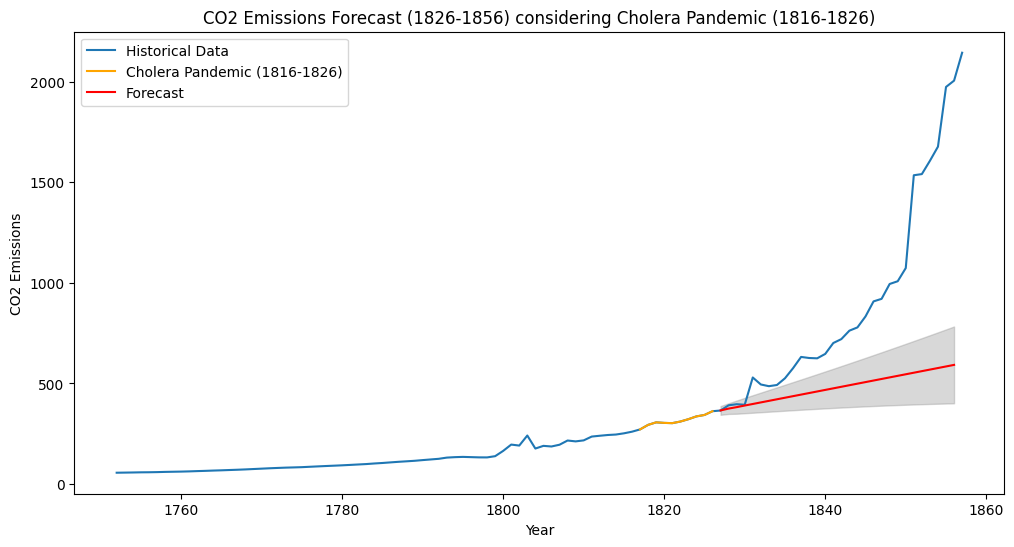

Total Forecasted CO2 Emissions: 14387.79
Mean Absolute Percentage Error (MAPE): 34.61%


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# Select the data for the period 1751-1850
start_date = pd.to_datetime('1751', format='%Y')
end_date_train = pd.to_datetime('1826', format='%Y')  # Update end date for training data
date_pandemic_start = pd.to_datetime('1816', format='%Y')  # Define start date for Cholera Pandemic
end_date_pandemic = pd.to_datetime('1826', format='%Y')  # Define end date for Cholera Pandemic
end_date_forecast = pd.to_datetime('1856', format='%Y')
co2_data = df.loc[(df['year'] >= start_date) & (df['year'] <= end_date_forecast), 'co2']
co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()

# Train the ARIMA model using the data from 1751 to 1850
train_data = co2_data.loc[(co2_data.index >= start_date) & (co2_data.index <= end_date_train)]

# Calculate optimal parameters for SARIMA using auto_arima
sarima_model = auto_arima(train_data, seasonal=True, stepwise=True, suppress_warnings=True)
optimal_p, optimal_d, optimal_q = sarima_model.order
optimal_P, optimal_D, optimal_Q, optimal_S = sarima_model.seasonal_order
optimal_S = 1  # Manually specify the seasonal component based on domain knowledge
print(f"Optimal SARIMA Parameters:")
print(f"p: {optimal_p}, d: {optimal_d}, q: {optimal_q}")
print(f"P: {optimal_P}, D: {optimal_D}, Q: {optimal_Q}, S: {optimal_S}")

# Train the SARIMA model using the optimal parameters
train_data = co2_data.loc[(co2_data.index >= start_date) & (co2_data.index <= end_date_train)]
sarima_model_fit = ARIMA(train_data, order=(optimal_p, optimal_d, optimal_q), seasonal_order=(optimal_P, optimal_D, optimal_Q, 12)).fit()

# Calculate the MAPE
mape_data = co2_data.loc[end_date_pandemic:end_date_forecast]
forecast = sarima_model_fit.get_forecast(steps=len(mape_data))
forecast_values = forecast.predicted_mean
mape = (abs(mape_data - forecast_values) / mape_data).mean() * 100

# Get CO2 values during the Cholera Pandemic period
pandemic_data = co2_data.loc[(co2_data.index >= date_pandemic_start) & (co2_data.index <= end_date_pandemic)]

# Forecasting for the period 1851-1900
forecast_years = end_date_forecast.year - end_date_pandemic.year
forecast = sarima_model_fit.get_forecast(steps=forecast_years)
forecast_values = forecast.predicted_mean
ci = forecast.conf_int()

# Calculate the total forecasted CO2 emissions
total_forecast = forecast_values.sum()

# Plotting the incremental plot for Cholera Pandemic period
plt.figure(figsize=(12, 6))
plt.plot(co2_data.index, co2_data, label='Historical Data')
plt.plot(pandemic_data.index, pandemic_data, color='orange', label='Cholera Pandemic (1816-1826)')
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color='gray', alpha=0.3)
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.title('CO2 Emissions Forecast (1826-1856) considering Cholera Pandemic (1816-1826)')
plt.legend()
plt.savefig("Cholera.eps")  # Save as EPS
# Save the plot as a TIFF file
plt.savefig("Cholera.tiff", format='tiff')
plt.show()

print(f"Total Forecasted CO2 Emissions: {total_forecast:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


<ipython-input-81-b878905a9de5>:17: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/d

Optimal SARIMA Parameters:
p: 2, d: 2, q: 3
P: 0, D: 0, Q: 0, S: 0


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


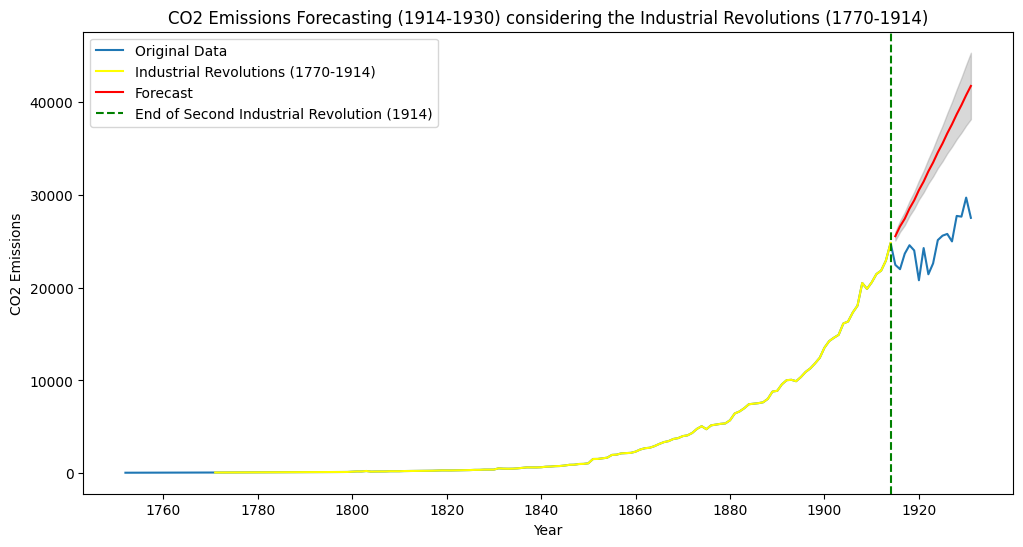

CO2 Emissions During the Industrial Revolutions (1770-1914):
year_copy
1751-12-31       56.442
1752-12-31       57.030
1753-12-31       57.660
1754-12-31       58.404
1755-12-31       58.758
                ...    
1909-12-31    20560.242
1910-12-31    21461.125
1911-12-31    21831.765
1912-12-31    22899.971
1913-12-31    24812.261
Freq: YE-DEC, Name: co2, Length: 163, dtype: float64
Total Forecasted CO2 Emissions (1914-1930): 570590.56
Mean Absolute Percentage Error (MAPE): 34.65%


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import numpy as np



# Select the data for the period 1751-1950
start_date = pd.to_datetime('1751', format='%Y')
end_date_revolution = pd.to_datetime('1914', format='%Y')  # End date for First and Second Industrial Revolution
start_date_revolution = pd.to_datetime('1770', format='%Y')  # Start date for First and Second Industrial Revolution
start_date_forecast = pd.to_datetime('1914', format='%Y')  # Start date for forecasting
end_date_forecast = pd.to_datetime('1930', format='%Y')    # End date for forecasting

co2_data = df.loc[(df['year'] >= start_date) & (df['year'] <= end_date_forecast), 'co2']
co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()

# Train the ARIMA model using the data from 1751 to 1914
train_data = co2_data.loc[(co2_data.index >= start_date) & (co2_data.index <= end_date_revolution)]

# Perform auto_arima to find optimal parameters
sarima_model = auto_arima(train_data, seasonal=True, stepwise=True, suppress_warnings=True)

# Get optimal SARIMA parameters
optimal_p, optimal_d, optimal_q = sarima_model.order
optimal_P, optimal_D, optimal_Q, optimal_S = sarima_model.seasonal_order

print(f"Optimal SARIMA Parameters:")
print(f"p: {optimal_p}, d: {optimal_d}, q: {optimal_q}")
print(f"P: {optimal_P}, D: {optimal_D}, Q: {optimal_Q}, S: {optimal_S}")

# Train the SARIMA model using the optimal parameters
sarima_model_fit = ARIMA(train_data, order=(optimal_p, optimal_d, optimal_q), seasonal_order=(optimal_P, optimal_D, optimal_Q, optimal_S)).fit()

# Forecasting for the period 1914-1930
forecast_years = end_date_forecast.year - start_date_forecast.year + 1
forecast = sarima_model_fit.get_forecast(steps=forecast_years)

# Extract the forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
ci = forecast.conf_int()

# Calculate the total forecasted CO2 emissions
total_forecast = forecast_values.sum()

# Calculate the MAPE (Mean Absolute Percentage Error)
actual_values = co2_data.loc[start_date_forecast:end_date_forecast]
mape = (abs(actual_values - forecast_values) / actual_values).mean() * 100

# Plotting the original data and the forecasted values
plt.figure(figsize=(12, 6))

# Plot the original data
plt.plot(co2_data.index, co2_data, label='Original Data')

# Highlight the revolution period with a yellow line
plt.plot(co2_data.loc[(co2_data.index >= start_date_revolution) & (co2_data.index <= end_date_revolution)].index,
         co2_data.loc[(co2_data.index >= start_date_revolution) & (co2_data.index <= end_date_revolution)],
         color='yellow', label='Industrial Revolutions (1770-1914)')

# Plot the forecasted values
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')

# Add confidence intervals for the forecast
plt.fill_between(forecast_values.index, ci.iloc[:, 0], ci.iloc[:, 1], color='gray', alpha=0.3)

# Add a vertical line at the end of the revolution period
plt.axvline(x=end_date_revolution, color='green', linestyle='--', label='End of Second Industrial Revolution (1914)')

plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.title('CO2 Emissions Forecasting (1914-1930) considering the Industrial Revolutions (1770-1914)')
plt.legend()

# Save the plot as a JPEG file
plt.savefig("industrial_revolution_forecast.jpg", format='jpeg')
# Save the plot as a TIFF file
plt.savefig("industrial_revolution_forecast.tiff", format='tiff')
plt.show()

print(f"CO2 Emissions During the Industrial Revolutions (1770-1914):")
print(co2_data.loc[(co2_data.index >= start_date) & (co2_data.index <= end_date_revolution)])
print(f"Total Forecasted CO2 Emissions (1914-1930): {total_forecast:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


<ipython-input-82-b39d6ef01504>:12: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/d

Optimal SARIMA Parameters:
p: 0, d: 2, q: 2
P: 0, D: 0, Q: 0, S: 0


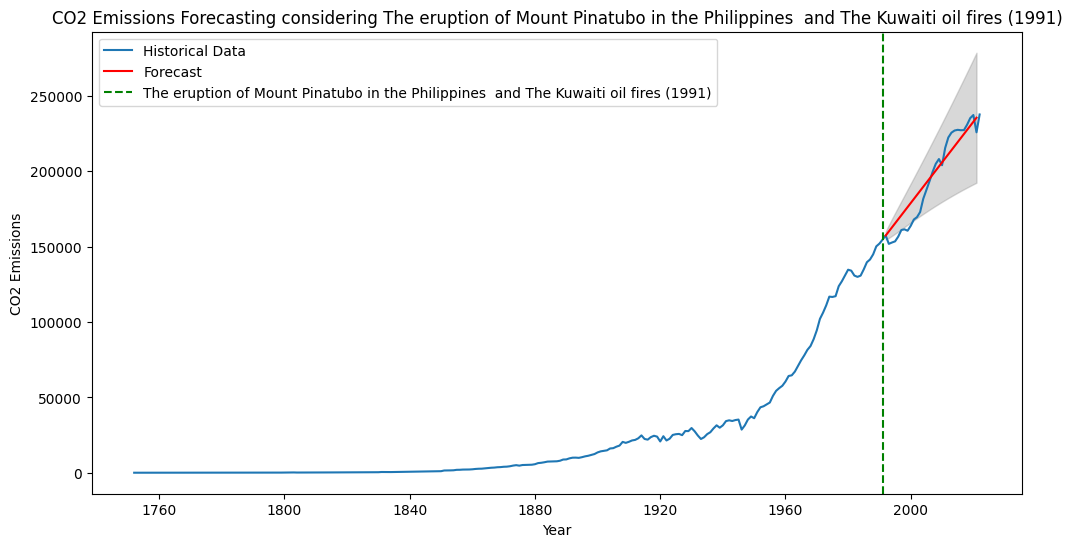

Total Forecasted CO2 Emissions (1991-2021): 5893170.68
Mean Absolute Percentage Error (MAPE): 4.45%


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

# Select the data for the period 1751-1991
start_date = pd.to_datetime('1751', format='%Y')
end_date_train = pd.to_datetime('1991', format='%Y')  # Update end date for training data
end_date_forecast = pd.to_datetime('2021', format='%Y')

co2_data = df.loc[(df['year'] >= start_date) & (df['year'] <= end_date_forecast), 'co2']
co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()

# Train the ARIMA model using the data from 1751 to 1991
train_data = co2_data.loc[(co2_data.index >= start_date) & (co2_data.index <= end_date_train)]

# Perform auto_arima to find optimal parameters
sarima_model = auto_arima(train_data, seasonal=True, stepwise=True, suppress_warnings=True)

# Get optimal SARIMA parameters
optimal_p, optimal_d, optimal_q = sarima_model.order
optimal_P, optimal_D, optimal_Q, optimal_S = sarima_model.seasonal_order

print(f"Optimal SARIMA Parameters:")
print(f"p: {optimal_p}, d: {optimal_d}, q: {optimal_q}")
print(f"P: {optimal_P}, D: {optimal_D}, Q: {optimal_Q}, S: {optimal_S}")

# Train the SARIMA model using the optimal parameters
sarima_model_fit = ARIMA(train_data, order=(optimal_p, optimal_d, optimal_q), seasonal_order=(optimal_P, optimal_D, optimal_Q, optimal_S)).fit()

# Forecasting for the next 30 years
forecast_years = 30
forecast = sarima_model_fit.get_forecast(steps=forecast_years)

# Extract the forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
ci = forecast.conf_int()

# Calculate the total forecasted CO2 emissions
total_forecast = forecast_values.sum()

# Calculate the MAPE (Mean Absolute Percentage Error)
actual_values = co2_data.loc[end_date_train:end_date_forecast]
mape = (abs(actual_values - forecast_values[:len(actual_values)]) / actual_values).mean() * 100

# Plotting the original data and the forecasted values
plt.figure(figsize=(12, 6))

# Plot the original data
plt.plot(co2_data.index, co2_data, label='Historical Data')



# Plot the forecasted values
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')

# Add confidence intervals for the forecast
plt.fill_between(forecast_values.index, ci.iloc[:, 0], ci.iloc[:, 1], color='gray', alpha=0.3)

# Add a vertical line at 1991
plt.axvline(x=end_date_train, color='green', linestyle='--', label='The eruption of Mount Pinatubo in the Philippines  and The Kuwaiti oil fires (1991)')

plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.title('CO2 Emissions Forecasting considering The eruption of Mount Pinatubo in the Philippines  and The Kuwaiti oil fires (1991)')
plt.legend()

# Save the plot as a JPEG file
plt.savefig("Pinatubo.jpg", format='jpeg')
# Save the plot as a TIFF file
plt.savefig("Pinatubo.tiff", format='tiff')
plt.show()

print(f"Total Forecasted CO2 Emissions (1991-2021): {total_forecast:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# Select the data for the period 1751-1919
start_date = pd.to_datetime('1751', format='%Y')
start_date_war = pd.to_datetime('1914', format='%Y')
end_date_train = pd.to_datetime('1918', format='%Y')
end_date_war = pd.to_datetime('1918', format='%Y')
end_date_forecast = pd.to_datetime('1950', format='%Y')
co2_data = df.loc[(df['year'] >= start_date) & (df['year'] <= end_date_forecast), 'co2']
co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()

# Calculate optimal parameters for SARIMA using auto_arima
sarima_model = auto_arima(co2_data, seasonal=True, stepwise=True, suppress_warnings=True,trace=True)

# Get optimal SARIMA parameters
optimal_p, optimal_d, optimal_q = sarima_model.order
optimal_P, optimal_D, optimal_Q, _ = sarima_model.seasonal_order


# Get optimal SARIMA parameters
optimal_p, optimal_d, optimal_q = sarima_model.order
optimal_P, optimal_D, optimal_Q, optimal_S = sarima_model.seasonal_order
# Manually specify the seasonal component based on domain knowledge
optimal_S = 1  # Change this value according to your data's seasonal pattern

print(f"Optimal SARIMA Parameters:")
print(f"p: {optimal_p}, d: {optimal_d}, q: {optimal_q}")
print(f"P: {optimal_P}, D: {optimal_D}, Q: {optimal_Q}, S: {optimal_S}")



# Train the SARIMA model using the optimal parameters
train_data = co2_data.loc[(co2_data.index >= start_date) & (co2_data.index <= end_date_train)]
sarima_model_fit = ARIMA(train_data, order=(optimal_p, optimal_d, optimal_q), seasonal_order=(optimal_P, optimal_D, optimal_Q, 12)).fit()

# Get CO2 values during the World War period
war_data = co2_data.loc[(co2_data.index > start_date_war) & (co2_data.index <= end_date_war)]

# Combine training data with World War period data
train_data = pd.concat([train_data, war_data])

# Forecasting for the period 1919-2021
forecast_years = end_date_forecast.year - end_date_war.year
forecast = sarima_model_fit.get_forecast(steps=forecast_years)

# Extract the forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
ci = forecast.conf_int()

# Calculate the total forecasted CO2 emissions
total_forecast = forecast_values.sum()

# Calculate the MAPE
mape = (abs(co2_data.loc[end_date_war:end_date_forecast] - forecast_values) / co2_data.loc[end_date_war:end_date_forecast]).mean() * 100

# Plotting the actual data and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(co2_data.index, co2_data, label='Historical Data')
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
plt.plot(war_data.index, war_data, color='orange', label='World War I Period (1914-1918)')
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color='gray', alpha=0.3)
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.title('CO2 Emissions Forecast (1919-1950) taking in consideration The World War I (28 July 1914 – 11 November 1918)')
plt.legend()
plt.savefig("ww1.eps") #save as eps
plt.show()
print(f"CO2 Emissions During World War I (1914-1918):")
print(war_data)
print(f"Total Forecasted CO2 Emissions: {total_forecast:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
from sklearn.metrics import r2_score

from statsmodels.graphics.tsaplots import plot_acf

# Plot the autocorrelation function (ACF)
plot_acf(train_data, lags=40)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Plot')
plt.show()


import seaborn as sns
import matplotlib.pyplot as plt

# Remove NaN values from the actual data and forecasted values
actual_values = co2_data.loc[end_date_war:end_date_forecast].values
forecast_values = forecast_values[~np.isnan(actual_values)]
actual_values = actual_values[~np.isnan(actual_values)]
fitted_values = sarima_model_fit.fittedvalues

# Plot residuals against fitted values
plt.scatter(fitted_values, sarima_model_fit.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()


from statsmodels.graphics.tsaplots import plot_acf

# Plot the autocorrelation function (ACF) of the residuals
plot_acf(sarima_model_fit.resid)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.show()


import scipy.stats as stats

# Create a Q-Q plot of residuals
qq_values = stats.probplot(sarima_model_fit.resid, dist="norm", plot=plt)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# Select the data for the period 1751-1919
start_date = pd.to_datetime('1751', format='%Y')
start_date_war = pd.to_datetime('1914', format='%Y')
end_date_train = pd.to_datetime('1920', format='%Y')
end_date_war = pd.to_datetime('1918', format='%Y')
end_date_forecast = pd.to_datetime('1950', format='%Y')
co2_data = df.loc[(df['year'] >= start_date) & (df['year'] <= end_date_forecast), 'co2']
co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()

# Calculate optimal parameters for SARIMA using auto_arima
sarima_model = auto_arima(co2_data, seasonal=True, stepwise=True, suppress_warnings=True)

# Get optimal SARIMA parameters
optimal_p, optimal_d, optimal_q = sarima_model.order
optimal_P, optimal_D, optimal_Q, optimal_S = sarima_model.seasonal_order
# Manually specify the seasonal component based on domain knowledge
optimal_S = 1  # Change this value according to your data's seasonal pattern

print(f"Optimal SARIMA Parameters:")
print(f"p: {optimal_p}, d: {optimal_d}, q: {optimal_q}")
print(f"P: {optimal_P}, D: {optimal_D}, Q: {optimal_Q}, S: {optimal_S}")



# Train the SARIMA model using the optimal parameters
train_data = co2_data.loc[(co2_data.index >= start_date) & (co2_data.index <= end_date_train)]
sarima_model_fit = ARIMA(train_data, order=(optimal_p, optimal_d, optimal_q), seasonal_order=(optimal_P, optimal_D, optimal_Q, 12)).fit()

# Get CO2 values during the World War period
war_data = co2_data.loc[(co2_data.index > start_date_war) & (co2_data.index <= end_date_war)]

# Combine training data with World War period data
train_data = pd.concat([train_data, war_data])

# Forecasting for the period 1919-2021
forecast_years = end_date_forecast.year - end_date_war.year
forecast = sarima_model_fit.get_forecast(steps=forecast_years)

# Extract the forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
ci = forecast.conf_int()

# Calculate the total forecasted CO2 emissions
total_forecast = forecast_values.sum()

# Calculate the MAPE
mape = (abs(co2_data.loc[end_date_war:end_date_forecast] - forecast_values) / co2_data.loc[end_date_war:end_date_forecast]).mean() * 100

# Plotting the actual data and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(co2_data.index, co2_data, label='Historical Data')
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
plt.plot(war_data.index, war_data, color='orange', label='World War I Period (1914-1918)')
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color='gray', alpha=0.3)
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.title('CO2 Emissions Forecast (1919-1950) taking in consideration th  post period of The World War I (until 1920)')
plt.legend()
plt.savefig("post_ww1.eps") #save as eps
plt.show()
print(f"CO2 Emissions During World War I (1914-1918):")
print(war_data)
print(f"Total Forecasted CO2 Emissions: {total_forecast:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
from statsmodels.graphics.tsaplots import plot_acf

# Plot the autocorrelation function (ACF)
plot_acf(train_data, lags=40)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Plot')
plt.show()

# Remove NaN values from the actual data and forecasted values
actual_values = co2_data.loc[end_date_war:end_date_forecast].values
forecast_values = forecast_values[~np.isnan(actual_values)]
actual_values = actual_values[~np.isnan(actual_values)]
fitted_values = sarima_model_fit.fittedvalues

# Plot residuals against fitted values
plt.scatter(fitted_values, sarima_model_fit.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()


from statsmodels.graphics.tsaplots import plot_acf

# Plot the autocorrelation function (ACF) of the residuals
plot_acf(sarima_model_fit.resid)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.show()

residuals = sarima_model_fit.resid

# Generate Q-Q plot
qq_values = stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')

# Save the plot as EPS
plt.savefig('qq_plot_residuals.eps', format='eps')

# Display the plot
plt.show()



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf

# Select the data for the period 1751-1919
start_date = pd.to_datetime('1751', format='%Y')
start_date_flu = pd.to_datetime('1918', format='%Y')
end_date_flu = pd.to_datetime('1919', format='%Y')  # Define end date for Spanish flu period
end_date_train = pd.to_datetime('1919', format='%Y')  # Update end date for training data
end_date_forecast = pd.to_datetime('1950', format='%Y')
co2_data = df.loc[(df['year'] >= start_date) & (df['year'] <= end_date_forecast), 'co2']
co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()

# Calculate optimal parameters for SARIMA using auto_arima
sarima_model = auto_arima(co2_data, seasonal=True, stepwise=True, suppress_warnings=True)

# Get optimal SARIMA parameters
optimal_p, optimal_d, optimal_q = sarima_model.order
optimal_P, optimal_D, optimal_Q, optimal_S = sarima_model.seasonal_order
# Manually specify the seasonal component based on domain knowledge
optimal_S = 1  # Change this value according to your data's seasonal pattern

print(f"Optimal SARIMA Parameters:")
print(f"p: {optimal_p}, d: {optimal_d}, q: {optimal_q}")
print(f"P: {optimal_P}, D: {optimal_D}, Q: {optimal_Q}, S: {optimal_S}")

# Train the SARIMA model using the optimal parameters
train_data = co2_data.loc[(co2_data.index >= start_date) & (co2_data.index <= end_date_train)]
sarima_model_fit = ARIMA(train_data, order=(optimal_p, optimal_d, optimal_q), seasonal_order=(optimal_P, optimal_D, optimal_Q, 12)).fit()

# Get CO2 values during the Spanish flu period
flu_data = co2_data.loc[(co2_data.index > start_date_flu) & (co2_data.index <= end_date_flu)]

# Combine training data with Spanish flu period data
train_data = pd.concat([train_data, flu_data])

# Forecasting for the period 1919-2021
forecast_years = end_date_forecast.year - end_date_flu.year
forecast = model_fit.get_forecast(steps=forecast_years)

# Extract the forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
ci = forecast.conf_int()

# Calculate the total forecasted CO2 emissions
total_forecast = forecast_values.sum()
# Calculate CO2 emissions during the Spanish flu period
co2_emissions_during_flu = flu_data.sum()
# Plotting the actual data and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(co2_data.index, co2_data, label='Historical Data')
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
plt.plot(flu_data.index, flu_data, color='orange', label='the Spanish flu (1918-1919)')
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color='gray', alpha=0.3)
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.title('CO2 Emissions Forecast (1919-1950) considering the Spanish flu (1918-1919)')
plt.legend()
plt.savefig("spanishflu.eps") #save as eps


# Q-Q plot
plt.figure(figsize=(8, 6))
qqplot(co2_data, line='s')
plt.title('Q-Q Plot of CO2 Emissions')
plt.savefig("qq_plot.eps") #save as eps
plt.show()

print(f"CO2 Emissions During the Spanish Flu (1918-1919):")
print(flu_data)
print(f"Total CO2 Emissions During the Spanish Flu: {co2_emissions_during_flu:.2f}")
print(f"Total Forecasted CO2 Emissions: {total_forecast:.2f}")
# Calculate the MAPE
mape = (abs(co2_data.loc[start_date_flu:end_date_flu] - forecast_values.loc[start_date_flu:end_date_flu]) / co2_data.loc[start_date_flu:end_date_flu]).mean() * 100

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.graphics.gofplots import qqplot

# Select the data for the period 1751-1919
start_date = pd.to_datetime('1751', format='%Y')
start_date_flu = pd.to_datetime('1918', format='%Y')
end_date_train = pd.to_datetime('1921', format='%Y')
end_date_flu = pd.to_datetime('1919', format='%Y')
end_date_forecast = pd.to_datetime('1950', format='%Y')
co2_data = df.loc[(df['year'] >= start_date) & (df['year'] <= end_date_forecast), 'co2']
co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()

# Calculate optimal parameters for SARIMA using auto_arima
sarima_model = auto_arima(co2_data, seasonal=True, stepwise=True, suppress_warnings=True)

# Get optimal SARIMA parameters
optimal_p, optimal_d, optimal_q = sarima_model.order
optimal_P, optimal_D, optimal_Q, optimal_S = sarima_model.seasonal_order
# Manually specify the seasonal component based on domain knowledge
optimal_S = 1  # Change this value according to your data's seasonal pattern

print(f"Optimal SARIMA Parameters:")
print(f"p: {optimal_p}, d: {optimal_d}, q: {optimal_q}")
print(f"P: {optimal_P}, D: {optimal_D}, Q: {optimal_Q}, S: {optimal_S}")

# Train the SARIMA model using the optimal parameters
train_data = co2_data.loc[(co2_data.index >= start_date) & (co2_data.index <= end_date_train)]
sarima_model_fit = ARIMA(train_data, order=(optimal_p, optimal_d, optimal_q), seasonal_order=(optimal_P, optimal_D, optimal_Q, 12)).fit()

# Get CO2 values during the post-Spanish Flu period
post_flu_data = co2_data.loc[(co2_data.index > end_date_flu) & (co2_data.index <= end_date_train)]

# Combine training data with post-Spanish Flu period data
train_data = pd.concat([train_data, post_flu_data])

# Forecasting for the period 1920-2021
forecast_years = end_date_forecast.year - end_date_flu.year
forecast = sarima_model_fit.get_forecast(steps=forecast_years)

# Extract the forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
ci = forecast.conf_int()

# Calculate the total forecasted CO2 emissions
total_forecast = forecast_values.sum()

# Calculate the MAPE
mape_data = co2_data.loc[end_date_flu:end_date_forecast]
mape_forecast = forecast_values.loc[end_date_flu:end_date_forecast]
mape = (abs(mape_data - mape_forecast) / mape_data).mean() * 100

# Plotting the actual data and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(co2_data.index, co2_data, label='Historical Data')
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
plt.plot(post_flu_data.index, post_flu_data, color='orange', label='Post-Spanish Flu Period (1919-1921)')
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color='gray', alpha=0.3)
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.title('CO2 Emissions Forecast (1921-1951) considering the Post-Spanish Flu Period')
plt.legend()
plt.savefig("post_spanishflu.eps") #save as eps

# Q-Q plot
plt.figure(figsize=(8, 6))
qqplot(sarima_model_fit.resid, line='s')
plt.title('Q-Q Plot of SARIMA Residuals')
plt.savefig("sarima_resid_qq_plot.eps") #save as eps
plt.show()

print(f"CO2 Emissions During the Post-Spanish Flu Period (1919-1921):")
print(post_flu_data)
print(f"Total Forecasted CO2 Emissions: {total_forecast:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")



# Plot ACF for residuals
plt.figure(figsize=(8, 6))
plot_acf(sarima_model_fit.resid, lags=20)
plt.title('ACF Plot of SARIMA Residuals')
plt.savefig("sarima_resid_acf_plot.eps") #save as eps
plt.show()



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# Select the data for the period 1751-1919
start_date = pd.to_datetime('1751', format='%Y')
start_date_flu = pd.to_datetime('1918', format='%Y')
end_date_train = pd.to_datetime('1921', format='%Y')
end_date_flu = pd.to_datetime('1919', format='%Y')
end_date_forecast = pd.to_datetime('1950', format='%Y')
co2_data = df.loc[(df['year'] >= start_date) & (df['year'] <= end_date_forecast), 'co2']
co2_data = co2_data.groupby(pd.Grouper(freq='Y')).sum()

# Calculate optimal parameters for SARIMA using auto_arima
sarima_model = auto_arima(co2_data, seasonal=True, stepwise=True, suppress_warnings=True)

# Get optimal SARIMA parameters
optimal_p, optimal_d, optimal_q = sarima_model.order
optimal_P, optimal_D, optimal_Q, optimal_S = sarima_model.seasonal_order
# Manually specify the seasonal component based on domain knowledge
optimal_S = 1  # Change this value according to your data's seasonal pattern

print(f"Optimal SARIMA Parameters:")
print(f"p: {optimal_p}, d: {optimal_d}, q: {optimal_q}")
print(f"P: {optimal_P}, D: {optimal_D}, Q: {optimal_Q}, S: {optimal_S}")

# Train the SARIMA model using the optimal parameters
train_data = co2_data.loc[(co2_data.index >= start_date) & (co2_data.index <= end_date_train)]
sarima_model_fit = ARIMA(train_data, order=(optimal_p, optimal_d, optimal_q), seasonal_order=(optimal_P, optimal_D, optimal_Q, 12)).fit()

# Get CO2 values during the post-Spanish Flu period
post_flu_data = co2_data.loc[(co2_data.index > end_date_flu) & (co2_data.index <= end_date_train)]

# Combine training data with post-Spanish Flu period data
train_data = pd.concat([train_data, post_flu_data])

# Forecasting for the period 1920-2021
forecast_years = end_date_forecast.year - end_date_flu.year
forecast = sarima_model_fit.get_forecast(steps=forecast_years)

# Extract the forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
ci = forecast.conf_int()

# Calculate the total forecasted CO2 emissions
total_forecast = forecast_values.sum()

# Calculate the MAPE
mape_data = co2_data.loc[end_date_flu:end_date_forecast]
mape_forecast = forecast_values.loc[end_date_flu:end_date_forecast]
mape = (abs(mape_data - mape_forecast) / mape_data).mean() * 100

# Plotting the actual data and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(co2_data.index, co2_data, label='Historical Data')
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
plt.plot(post_flu_data.index, post_flu_data, color='orange', label='Post-Spanish Flu Period (1919-1921)')
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color='gray', alpha=0.3)
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.title('CO2 Emissions Forecast (1921-1951) considering the Post-Spanish Flu Period')
plt.legend()
plt.savefig("post_spanishflu.eps") #save as eps
# Save the plot as a TIFF file
plt.savefig("post_spanishflu.tiff", format='tiff')
plt.show()

print(f"CO2 Emissions During the Post-Spanish Flu Period (1919-1921):")
print(post_flu_data)
print(f"Total Forecasted CO2 Emissions: {total_forecast:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
adf_test_result = adfuller(train_data)
print("ADF Statistic:", adf_test_result[0])
print("p-value:", adf_test_result[1])
from statsmodels.graphics.tsaplots import plot_acf

# Plot ACF for residuals
plot_acf(sarima_model_fit.resid, lags=20)
plt.show()

from statsmodels.stats.diagnostic import het_arch

# Perform ARCH test for heteroskedasticity
het_arch_test_result = het_arch(sarima_model_fit.resid)
print("ARCH Statistic:", het_arch_test_result[0])
print("p-value:", het_arch_test_result[1])

from scipy.stats import jarque_bera

# Perform Jarque-Bera test for normality
jarque_bera_test_result = jarque_bera(sarima_model_fit.resid)
print("Jarque-Bera Statistic:", jarque_bera_test_result[0])
print("p-value:", jarque_bera_test_result[1])
